In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
from datetime import datetime, timedelta
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# ======================================================= DEFINICJA SIECI ==========================================================

class LeNet5CIFAR10(nn.Module):
    def __init__(self, num_layers, layer_sizes, dropout_rate):
        super(LeNet5CIFAR10, self).__init__()

        # Validate input
        if num_layers < 2 or num_layers > 10:
            raise ValueError("num_layers must be between 2 and 10")
        if len(layer_sizes) != num_layers:
            raise ValueError("layer_sizes length must match num_layers")
        
        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Dropout(dropout_rate)
        )

        self.conv2=nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Dropout(dropout_rate)
        )

        # Fully connected layers
        self.fcs = nn.ModuleList()  # Initialize as a list to hold the layers dynamically

        # Define the first fully connected layer, input size matches flattened conv output
        input_size = 16 * 5 * 5
        self.fcs.append(nn.Linear(input_size, layer_sizes[0]))

        # Define the intermediate layers based on `num_layers` and `layer_sizes`
        for i in range(1, num_layers - 1):
            self.fcs.append(nn.Linear(layer_sizes[i - 1], layer_sizes[i]))

        # Output layer
        self.fcs.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.reshape(out.size(0), -1)

        # Apply fully connected layers with ReLU activations for all but last
        for layer in self.fcs[:-1]:
            out = F.relu(layer(out))

        # Final layer (no activation to allow for softmax)
        # x = self.fcs[-1](x)
        return self.fcs[-1](out)

        # Apply softmax for class probabilities
        # return F.softmax(x, dim=1)

        print("END FORWARD")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import datetime
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Podział danych treningowych na zbiór treningowy i walidacyjny (90% na trening, 10% na walidację)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

def train_and_eval(learning_rate, num_layers, layer_sizes, batch_size, dropout_rate, weight_decay):
  # Stworzenie DataLoaderów
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
  val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

  net = LeNet5CIFAR10(num_layers, layer_sizes, dropout_rate).to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

  start_time = datetime.datetime.now()
  # Pętla treningowa
  num_epochs = 15
  for epoch in range(num_epochs):
      net.train()
      for inputs, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)

          # Przepuszczenie danych przez sieć, obliczenie funkcji kosztu i wstecznej propagacji
          outputs = net(inputs)
          optimizer.zero_grad()
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
      print(f"epoch {epoch+1}/{num_epochs}, elapsed time: {datetime.datetime.now() - start_time}")


  # Testowanie modelu - obliczenie accuracy
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = net(inputs)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy = correct / total
  return accuracy, net

Files already downloaded and verified
Files already downloaded and verified


In [71]:
train_and_eval(0.00032612430218809, 2, [943, 10], 32, 0.0652566450453942, 1.35021744016308e-05)
# Hyperparameters of trial number 84
#   Learning Rate: 0.0003261243021880896
#   Dropout Rate: 0.06525664504539422
#   Weight Decay: 1.3502174401630838e-05
#   Number of Layers: 2
#   Batch Size: 32
#   Layer Sizes: [943, 10]

epoch 1/50, elapsed time: 0:00:23.351481
epoch 2/50, elapsed time: 0:00:40.206933
epoch 3/50, elapsed time: 0:00:57.859807
epoch 4/50, elapsed time: 0:01:21.382910
epoch 5/50, elapsed time: 0:01:39.525503
epoch 6/50, elapsed time: 0:01:58.560174
epoch 7/50, elapsed time: 0:02:14.607538
epoch 8/50, elapsed time: 0:02:32.380440
epoch 9/50, elapsed time: 0:02:49.580538
epoch 10/50, elapsed time: 0:03:07.779247
epoch 11/50, elapsed time: 0:03:24.970432
epoch 12/50, elapsed time: 0:03:45.368555
epoch 13/50, elapsed time: 0:04:01.913200
epoch 14/50, elapsed time: 0:04:21.476160
epoch 15/50, elapsed time: 0:04:42.909519
epoch 16/50, elapsed time: 0:05:01.802934
epoch 17/50, elapsed time: 0:05:19.404777
epoch 18/50, elapsed time: 0:05:42.419396
epoch 19/50, elapsed time: 0:05:59.729635
epoch 20/50, elapsed time: 0:06:25.776633
epoch 21/50, elapsed time: 0:06:45.446591
epoch 22/50, elapsed time: 0:07:08.276091
epoch 23/50, elapsed time: 0:07:24.816539
epoch 24/50, elapsed time: 0:07:43.569060
e

0.6719

In [59]:
import optuna
import datetime
import logging
import sys

In [ ]:
print(datetime.datetime.now())
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    num_layers = int(trial.suggest_float("num_layers", 2.0, 10.0, step=1.0, log=False))
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])

    layer_sizes = []
    layer_sizes.append(int(trial.suggest_float("layer-1-size", 128, 1024, step=1.0, log=False)))
    for i in range(1, num_layers-1):
      name = "layer-{}-size".format(i+1)
      layer_sizes.append(int(trial.suggest_float(name, 64, 1024, step=1.0, log=False)))

    layer_sizes.append(10)

    print(f"Hyperparameters of trial number {trial.number}")
    print(f"  Learning Rate: {learning_rate}")
    print(f"  Dropout Rate: {dropout_rate}")
    print(f"  Weight Decay: {weight_decay}")
    print(f"  Number of Layers: {num_layers}")
    print(f"  Batch Size: {batch_size}")
    print(f"  Layer Sizes: {layer_sizes}")

    # Trening modelu z hiperparametrami
    accuracy = train_and_eval(
        learning_rate,
        num_layers,
        layer_sizes,
        batch_size,
        dropout_rate,
        weight_decay
    )
    print()
    print(f"  Accuracy: {accuracy}")
    print(f"  Elapsed time: {datetime.datetime.now() - trial.datetime_start}")
    print()
    print()
    print()

    return accuracy

optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "mro-kadet-04"
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name, direction="maximize")

study.optimize(objective, n_trials=1000)

print("Najlepsze hiperparametry: ", study.best_params)
print("Najlepsza dokładność: ", study.best_value)

2024-11-01 02:18:47.721311


[I 2024-11-01 02:18:49,694] A new study created in RDB with name: mro-kadet-04


A new study created in RDB with name: mro-kadet-04
A new study created in RDB with name: mro-kadet-04
A new study created in RDB with name: mro-kadet-04
A new study created in RDB with name: mro-kadet-04
A new study created in RDB with name: mro-kadet-04
A new study created in RDB with name: mro-kadet-04
A new study created in RDB with name: mro-kadet-04
Hyperparameters of trial number 0
  Learning Rate: 0.002037847496967966
  Dropout Rate: 0.4524419894039575
  Weight Decay: 0.0003643103187585856
  Number of Layers: 2
  Batch Size: 64
  Layer Sizes: [848, 10]


[I 2024-11-01 02:21:06,955] Trial 0 finished with value: 0.5717 and parameters: {'learning_rate': 0.002037847496967966, 'dropout_rate': 0.4524419894039575, 'weight_decay': 0.0003643103187585856, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 848.0}. Best is trial 0 with value: 0.5717.



  Accuracy: 0.5717
  Elapsed time: 0:02:17.149210



Trial 0 finished with value: 0.5717 and parameters: {'learning_rate': 0.002037847496967966, 'dropout_rate': 0.4524419894039575, 'weight_decay': 0.0003643103187585856, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 848.0}. Best is trial 0 with value: 0.5717.
Trial 0 finished with value: 0.5717 and parameters: {'learning_rate': 0.002037847496967966, 'dropout_rate': 0.4524419894039575, 'weight_decay': 0.0003643103187585856, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 848.0}. Best is trial 0 with value: 0.5717.
Trial 0 finished with value: 0.5717 and parameters: {'learning_rate': 0.002037847496967966, 'dropout_rate': 0.4524419894039575, 'weight_decay': 0.0003643103187585856, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 848.0}. Best is trial 0 with value: 0.5717.
Trial 0 finished with value: 0.5717 and parameters: {'learning_rate': 0.002037847496967966, 'dropout_rate': 0.4524419894039575, 'weight_decay': 0.00036431

[I 2024-11-01 02:22:42,034] Trial 1 finished with value: 0.3983 and parameters: {'learning_rate': 1.5052828106605899e-05, 'dropout_rate': 0.4153954527819515, 'weight_decay': 0.004258579382123662, 'num_layers': 4.0, 'batch_size': 256, 'layer-1-size': 473.0, 'layer-2-size': 955.0, 'layer-3-size': 685.0}. Best is trial 0 with value: 0.5717.



  Accuracy: 0.3983
  Elapsed time: 0:01:34.941218



Trial 1 finished with value: 0.3983 and parameters: {'learning_rate': 1.5052828106605899e-05, 'dropout_rate': 0.4153954527819515, 'weight_decay': 0.004258579382123662, 'num_layers': 4.0, 'batch_size': 256, 'layer-1-size': 473.0, 'layer-2-size': 955.0, 'layer-3-size': 685.0}. Best is trial 0 with value: 0.5717.
Trial 1 finished with value: 0.3983 and parameters: {'learning_rate': 1.5052828106605899e-05, 'dropout_rate': 0.4153954527819515, 'weight_decay': 0.004258579382123662, 'num_layers': 4.0, 'batch_size': 256, 'layer-1-size': 473.0, 'layer-2-size': 955.0, 'layer-3-size': 685.0}. Best is trial 0 with value: 0.5717.
Trial 1 finished with value: 0.3983 and parameters: {'learning_rate': 1.5052828106605899e-05, 'dropout_rate': 0.4153954527819515, 'weight_decay': 0.004258579382123662, 'num_layers': 4.0, 'batch_size': 256, 'layer-1-size': 473.0, 'layer-2-size': 955.0, 'layer-3-size': 685.0}. Best is trial 0 with value: 0.5717.
Trial 1 fi

[I 2024-11-01 02:40:55,010] Trial 2 finished with value: 0.5948 and parameters: {'learning_rate': 0.0040150350386017625, 'dropout_rate': 0.18432207655014676, 'weight_decay': 4.428329909245621e-05, 'num_layers': 5.0, 'batch_size': 16, 'layer-1-size': 771.0, 'layer-2-size': 619.0, 'layer-3-size': 112.0, 'layer-4-size': 853.0}. Best is trial 2 with value: 0.5948.


Trial 2 finished with value: 0.5948 and parameters: {'learning_rate': 0.0040150350386017625, 'dropout_rate': 0.18432207655014676, 'weight_decay': 4.428329909245621e-05, 'num_layers': 5.0, 'batch_size': 16, 'layer-1-size': 771.0, 'layer-2-size': 619.0, 'layer-3-size': 112.0, 'layer-4-size': 853.0}. Best is trial 2 with value: 0.5948.
Trial 2 finished with value: 0.5948 and parameters: {'learning_rate': 0.0040150350386017625, 'dropout_rate': 0.18432207655014676, 'weight_decay': 4.428329909245621e-05, 'num_layers': 5.0, 'batch_size': 16, 'layer-1-size': 771.0, 'layer-2-size': 619.0, 'layer-3-size': 112.0, 'layer-4-size': 853.0}. Best is trial 2 with value: 0.5948.
Trial 2 finished with value: 0.5948 and parameters: {'learning_rate': 0.0040150350386017625, 'dropout_rate': 0.18432207655014676, 'weight_decay': 4.428329909245621e-05, 'num_layers': 5.0, 'batch_size': 16, 'layer-1-size': 771.0, 'layer-2-size': 619.0, 'layer-3-size': 112.0, 'layer-4-size': 853.0}. Best is trial 2 with value: 0.5

[I 2024-11-01 02:42:47,415] Trial 3 finished with value: 0.4048 and parameters: {'learning_rate': 2.4837524018200634e-05, 'dropout_rate': 0.24572207723539796, 'weight_decay': 0.0026280330577008793, 'num_layers': 6.0, 'batch_size': 256, 'layer-1-size': 459.0, 'layer-2-size': 66.0, 'layer-3-size': 570.0, 'layer-4-size': 298.0, 'layer-5-size': 537.0}. Best is trial 2 with value: 0.5948.



  Accuracy: 0.4048
  Elapsed time: 0:01:52.302411



Trial 3 finished with value: 0.4048 and parameters: {'learning_rate': 2.4837524018200634e-05, 'dropout_rate': 0.24572207723539796, 'weight_decay': 0.0026280330577008793, 'num_layers': 6.0, 'batch_size': 256, 'layer-1-size': 459.0, 'layer-2-size': 66.0, 'layer-3-size': 570.0, 'layer-4-size': 298.0, 'layer-5-size': 537.0}. Best is trial 2 with value: 0.5948.
Trial 3 finished with value: 0.4048 and parameters: {'learning_rate': 2.4837524018200634e-05, 'dropout_rate': 0.24572207723539796, 'weight_decay': 0.0026280330577008793, 'num_layers': 6.0, 'batch_size': 256, 'layer-1-size': 459.0, 'layer-2-size': 66.0, 'layer-3-size': 570.0, 'layer-4-size': 298.0, 'layer-5-size': 537.0}. Best is trial 2 with value: 0.5948.
Trial 3 finished with value: 0.4048 and parameters: {'learning_rate': 2.4837524018200634e-05, 'dropout_rate': 0.24572207723539796, 'weight_decay': 0.0026280330577008793, 'num_layers': 6.0, 'batch_size': 256, 'layer-1-size': 459.

[I 2024-11-01 02:53:23,609] Trial 4 finished with value: 0.1 and parameters: {'learning_rate': 0.0023251930561475434, 'dropout_rate': 0.35313473760099856, 'weight_decay': 0.00029650789651163647, 'num_layers': 10.0, 'batch_size': 128, 'layer-1-size': 701.0, 'layer-2-size': 380.0, 'layer-3-size': 570.0, 'layer-4-size': 733.0, 'layer-5-size': 1011.0, 'layer-6-size': 253.0, 'layer-7-size': 462.0, 'layer-8-size': 263.0, 'layer-9-size': 313.0}. Best is trial 2 with value: 0.5948.


Trial 4 finished with value: 0.1 and parameters: {'learning_rate': 0.0023251930561475434, 'dropout_rate': 0.35313473760099856, 'weight_decay': 0.00029650789651163647, 'num_layers': 10.0, 'batch_size': 128, 'layer-1-size': 701.0, 'layer-2-size': 380.0, 'layer-3-size': 570.0, 'layer-4-size': 733.0, 'layer-5-size': 1011.0, 'layer-6-size': 253.0, 'layer-7-size': 462.0, 'layer-8-size': 263.0, 'layer-9-size': 313.0}. Best is trial 2 with value: 0.5948.
Trial 4 finished with value: 0.1 and parameters: {'learning_rate': 0.0023251930561475434, 'dropout_rate': 0.35313473760099856, 'weight_decay': 0.00029650789651163647, 'num_layers': 10.0, 'batch_size': 128, 'layer-1-size': 701.0, 'layer-2-size': 380.0, 'layer-3-size': 570.0, 'layer-4-size': 733.0, 'layer-5-size': 1011.0, 'layer-6-size': 253.0, 'layer-7-size': 462.0, 'layer-8-size': 263.0, 'layer-9-size': 313.0}. Best is trial 2 with value: 0.5948.
Trial 4 finished with value: 0.1 and parameters: {'learning_rate': 0.0023251930561475434, 'dropout

[I 2024-11-01 02:55:17,849] Trial 5 finished with value: 0.517 and parameters: {'learning_rate': 0.005121921919832015, 'dropout_rate': 0.3175245370701787, 'weight_decay': 0.004265640822086492, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 782.0, 'layer-2-size': 438.0, 'layer-3-size': 875.0, 'layer-4-size': 939.0}. Best is trial 2 with value: 0.5948.



  Accuracy: 0.517
  Elapsed time: 0:01:54.130938



Trial 5 finished with value: 0.517 and parameters: {'learning_rate': 0.005121921919832015, 'dropout_rate': 0.3175245370701787, 'weight_decay': 0.004265640822086492, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 782.0, 'layer-2-size': 438.0, 'layer-3-size': 875.0, 'layer-4-size': 939.0}. Best is trial 2 with value: 0.5948.
Trial 5 finished with value: 0.517 and parameters: {'learning_rate': 0.005121921919832015, 'dropout_rate': 0.3175245370701787, 'weight_decay': 0.004265640822086492, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 782.0, 'layer-2-size': 438.0, 'layer-3-size': 875.0, 'layer-4-size': 939.0}. Best is trial 2 with value: 0.5948.
Trial 5 finished with value: 0.517 and parameters: {'learning_rate': 0.005121921919832015, 'dropout_rate': 0.3175245370701787, 'weight_decay': 0.004265640822086492, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 782.0, 'layer-2-size': 438.0, 'layer-3-size': 875.0, 'layer-4-si

[I 2024-11-01 03:07:45,620] Trial 6 finished with value: 0.5257 and parameters: {'learning_rate': 2.9463036234049367e-05, 'dropout_rate': 0.1571398004514994, 'weight_decay': 0.0011895609211815964, 'num_layers': 6.0, 'batch_size': 16, 'layer-1-size': 200.0, 'layer-2-size': 461.0, 'layer-3-size': 358.0, 'layer-4-size': 686.0, 'layer-5-size': 316.0}. Best is trial 2 with value: 0.5948.



  Accuracy: 0.5257
  Elapsed time: 0:12:27.660941



Trial 6 finished with value: 0.5257 and parameters: {'learning_rate': 2.9463036234049367e-05, 'dropout_rate': 0.1571398004514994, 'weight_decay': 0.0011895609211815964, 'num_layers': 6.0, 'batch_size': 16, 'layer-1-size': 200.0, 'layer-2-size': 461.0, 'layer-3-size': 358.0, 'layer-4-size': 686.0, 'layer-5-size': 316.0}. Best is trial 2 with value: 0.5948.
Trial 6 finished with value: 0.5257 and parameters: {'learning_rate': 2.9463036234049367e-05, 'dropout_rate': 0.1571398004514994, 'weight_decay': 0.0011895609211815964, 'num_layers': 6.0, 'batch_size': 16, 'layer-1-size': 200.0, 'layer-2-size': 461.0, 'layer-3-size': 358.0, 'layer-4-size': 686.0, 'layer-5-size': 316.0}. Best is trial 2 with value: 0.5948.
Trial 6 finished with value: 0.5257 and parameters: {'learning_rate': 2.9463036234049367e-05, 'dropout_rate': 0.1571398004514994, 'weight_decay': 0.0011895609211815964, 'num_layers': 6.0, 'batch_size': 16, 'layer-1-size': 200.0, '

[I 2024-11-01 03:11:19,739] Trial 7 finished with value: 0.2674 and parameters: {'learning_rate': 1.4320650566408862e-05, 'dropout_rate': 0.3912383970063016, 'weight_decay': 0.0070480225931611, 'num_layers': 7.0, 'batch_size': 64, 'layer-1-size': 246.0, 'layer-2-size': 979.0, 'layer-3-size': 71.0, 'layer-4-size': 433.0, 'layer-5-size': 68.0, 'layer-6-size': 770.0}. Best is trial 2 with value: 0.5948.



  Accuracy: 0.2674
  Elapsed time: 0:03:34.015701



Trial 7 finished with value: 0.2674 and parameters: {'learning_rate': 1.4320650566408862e-05, 'dropout_rate': 0.3912383970063016, 'weight_decay': 0.0070480225931611, 'num_layers': 7.0, 'batch_size': 64, 'layer-1-size': 246.0, 'layer-2-size': 979.0, 'layer-3-size': 71.0, 'layer-4-size': 433.0, 'layer-5-size': 68.0, 'layer-6-size': 770.0}. Best is trial 2 with value: 0.5948.
Trial 7 finished with value: 0.2674 and parameters: {'learning_rate': 1.4320650566408862e-05, 'dropout_rate': 0.3912383970063016, 'weight_decay': 0.0070480225931611, 'num_layers': 7.0, 'batch_size': 64, 'layer-1-size': 246.0, 'layer-2-size': 979.0, 'layer-3-size': 71.0, 'layer-4-size': 433.0, 'layer-5-size': 68.0, 'layer-6-size': 770.0}. Best is trial 2 with value: 0.5948.
Trial 7 finished with value: 0.2674 and parameters: {'learning_rate': 1.4320650566408862e-05, 'dropout_rate': 0.3912383970063016, 'weight_decay': 0.0070480225931611, 'num_layers': 7.0, 'batch_si

[I 2024-11-01 03:20:17,833] Trial 8 finished with value: 0.1 and parameters: {'learning_rate': 0.0031580200157884618, 'dropout_rate': 0.46580865759934686, 'weight_decay': 0.0011398664218011387, 'num_layers': 8.0, 'batch_size': 128, 'layer-1-size': 211.0, 'layer-2-size': 988.0, 'layer-3-size': 355.0, 'layer-4-size': 167.0, 'layer-5-size': 974.0, 'layer-6-size': 245.0, 'layer-7-size': 604.0}. Best is trial 2 with value: 0.5948.



  Accuracy: 0.1
  Elapsed time: 0:08:57.976770



Trial 8 finished with value: 0.1 and parameters: {'learning_rate': 0.0031580200157884618, 'dropout_rate': 0.46580865759934686, 'weight_decay': 0.0011398664218011387, 'num_layers': 8.0, 'batch_size': 128, 'layer-1-size': 211.0, 'layer-2-size': 988.0, 'layer-3-size': 355.0, 'layer-4-size': 167.0, 'layer-5-size': 974.0, 'layer-6-size': 245.0, 'layer-7-size': 604.0}. Best is trial 2 with value: 0.5948.
Trial 8 finished with value: 0.1 and parameters: {'learning_rate': 0.0031580200157884618, 'dropout_rate': 0.46580865759934686, 'weight_decay': 0.0011398664218011387, 'num_layers': 8.0, 'batch_size': 128, 'layer-1-size': 211.0, 'layer-2-size': 988.0, 'layer-3-size': 355.0, 'layer-4-size': 167.0, 'layer-5-size': 974.0, 'layer-6-size': 245.0, 'layer-7-size': 604.0}. Best is trial 2 with value: 0.5948.
Trial 8 finished with value: 0.1 and parameters: {'learning_rate': 0.0031580200157884618, 'dropout_rate': 0.46580865759934686, 'weight_decay': 0.

[I 2024-11-01 03:23:15,258] Trial 9 finished with value: 0.5455 and parameters: {'learning_rate': 0.0036455758911056613, 'dropout_rate': 0.4423093690064197, 'weight_decay': 1.920525307688304e-05, 'num_layers': 5.0, 'batch_size': 128, 'layer-1-size': 406.0, 'layer-2-size': 196.0, 'layer-3-size': 410.0, 'layer-4-size': 671.0}. Best is trial 2 with value: 0.5948.



  Accuracy: 0.5455
  Elapsed time: 0:02:57.315804



Trial 9 finished with value: 0.5455 and parameters: {'learning_rate': 0.0036455758911056613, 'dropout_rate': 0.4423093690064197, 'weight_decay': 1.920525307688304e-05, 'num_layers': 5.0, 'batch_size': 128, 'layer-1-size': 406.0, 'layer-2-size': 196.0, 'layer-3-size': 410.0, 'layer-4-size': 671.0}. Best is trial 2 with value: 0.5948.
Trial 9 finished with value: 0.5455 and parameters: {'learning_rate': 0.0036455758911056613, 'dropout_rate': 0.4423093690064197, 'weight_decay': 1.920525307688304e-05, 'num_layers': 5.0, 'batch_size': 128, 'layer-1-size': 406.0, 'layer-2-size': 196.0, 'layer-3-size': 410.0, 'layer-4-size': 671.0}. Best is trial 2 with value: 0.5948.
Trial 9 finished with value: 0.5455 and parameters: {'learning_rate': 0.0036455758911056613, 'dropout_rate': 0.4423093690064197, 'weight_decay': 1.920525307688304e-05, 'num_layers': 5.0, 'batch_size': 128, 'layer-1-size': 406.0, 'layer-2-size': 196.0, 'layer-3-size': 410.0, '

[I 2024-11-01 03:32:30,261] Trial 10 finished with value: 0.6671 and parameters: {'learning_rate': 0.00045980874947719306, 'dropout_rate': 0.003510536085684801, 'weight_decay': 1.2936519321037755e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 965.0, 'layer-2-size': 728.0}. Best is trial 10 with value: 0.6671.


Trial 10 finished with value: 0.6671 and parameters: {'learning_rate': 0.00045980874947719306, 'dropout_rate': 0.003510536085684801, 'weight_decay': 1.2936519321037755e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 965.0, 'layer-2-size': 728.0}. Best is trial 10 with value: 0.6671.
Trial 10 finished with value: 0.6671 and parameters: {'learning_rate': 0.00045980874947719306, 'dropout_rate': 0.003510536085684801, 'weight_decay': 1.2936519321037755e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 965.0, 'layer-2-size': 728.0}. Best is trial 10 with value: 0.6671.
Trial 10 finished with value: 0.6671 and parameters: {'learning_rate': 0.00045980874947719306, 'dropout_rate': 0.003510536085684801, 'weight_decay': 1.2936519321037755e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 965.0, 'layer-2-size': 728.0}. Best is trial 10 with value: 0.6671.
Trial 10 finished with value: 0.6671 and parameters: {'learning_rate': 0.00045980874947719306, 'dropout_rate': 0.00351

[I 2024-11-01 03:38:14,379] Trial 11 finished with value: 0.6758 and parameters: {'learning_rate': 0.000372815430213705, 'dropout_rate': 0.00579564785383475, 'weight_decay': 1.0015434526054381e-05, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 963.0}. Best is trial 11 with value: 0.6758.



  Accuracy: 0.6758
  Elapsed time: 0:05:44.020672



Trial 11 finished with value: 0.6758 and parameters: {'learning_rate': 0.000372815430213705, 'dropout_rate': 0.00579564785383475, 'weight_decay': 1.0015434526054381e-05, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 963.0}. Best is trial 11 with value: 0.6758.
Trial 11 finished with value: 0.6758 and parameters: {'learning_rate': 0.000372815430213705, 'dropout_rate': 0.00579564785383475, 'weight_decay': 1.0015434526054381e-05, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 963.0}. Best is trial 11 with value: 0.6758.
Trial 11 finished with value: 0.6758 and parameters: {'learning_rate': 0.000372815430213705, 'dropout_rate': 0.00579564785383475, 'weight_decay': 1.0015434526054381e-05, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 963.0}. Best is trial 11 with value: 0.6758.
Trial 11 finished with value: 0.6758 and parameters: {'learning_rate': 0.000372815430213705, 'dropout_rate': 0.00579564785383475, 'weight_deca

[I 2024-11-01 03:41:42,344] Trial 12 finished with value: 0.6665 and parameters: {'learning_rate': 0.00028077134783044037, 'dropout_rate': 0.011853053947394002, 'weight_decay': 1.4519847968251891e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 996.0}. Best is trial 11 with value: 0.6758.



  Accuracy: 0.6665
  Elapsed time: 0:03:27.866107



Trial 12 finished with value: 0.6665 and parameters: {'learning_rate': 0.00028077134783044037, 'dropout_rate': 0.011853053947394002, 'weight_decay': 1.4519847968251891e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 996.0}. Best is trial 11 with value: 0.6758.
Trial 12 finished with value: 0.6665 and parameters: {'learning_rate': 0.00028077134783044037, 'dropout_rate': 0.011853053947394002, 'weight_decay': 1.4519847968251891e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 996.0}. Best is trial 11 with value: 0.6758.
Trial 12 finished with value: 0.6665 and parameters: {'learning_rate': 0.00028077134783044037, 'dropout_rate': 0.011853053947394002, 'weight_decay': 1.4519847968251891e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 996.0}. Best is trial 11 with value: 0.6758.
Trial 12 finished with value: 0.6665 and parameters: {'learning_rate': 0.00028077134783044037, 'dropout_rate': 0.011853053947394002, 

[I 2024-11-01 03:50:59,544] Trial 13 finished with value: 0.6541 and parameters: {'learning_rate': 0.00027836098202625335, 'dropout_rate': 0.005543623624722529, 'weight_decay': 5.736333634992279e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 1021.0, 'layer-2-size': 725.0}. Best is trial 11 with value: 0.6758.



  Accuracy: 0.6541
  Elapsed time: 0:09:17.096336



Trial 13 finished with value: 0.6541 and parameters: {'learning_rate': 0.00027836098202625335, 'dropout_rate': 0.005543623624722529, 'weight_decay': 5.736333634992279e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 1021.0, 'layer-2-size': 725.0}. Best is trial 11 with value: 0.6758.
Trial 13 finished with value: 0.6541 and parameters: {'learning_rate': 0.00027836098202625335, 'dropout_rate': 0.005543623624722529, 'weight_decay': 5.736333634992279e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 1021.0, 'layer-2-size': 725.0}. Best is trial 11 with value: 0.6758.
Trial 13 finished with value: 0.6541 and parameters: {'learning_rate': 0.00027836098202625335, 'dropout_rate': 0.005543623624722529, 'weight_decay': 5.736333634992279e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 1021.0, 'layer-2-size': 725.0}. Best is trial 11 with value: 0.6758.
Trial 13 finished with value: 0.6541 and parameters: {'learning_

[I 2024-11-01 04:02:08,391] Trial 14 finished with value: 0.6519 and parameters: {'learning_rate': 0.0008463642990398397, 'dropout_rate': 0.07458282511495737, 'weight_decay': 1.0916610371414134e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 909.0, 'layer-2-size': 767.0}. Best is trial 11 with value: 0.6758.



  Accuracy: 0.6519
  Elapsed time: 0:11:08.747730



Trial 14 finished with value: 0.6519 and parameters: {'learning_rate': 0.0008463642990398397, 'dropout_rate': 0.07458282511495737, 'weight_decay': 1.0916610371414134e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 909.0, 'layer-2-size': 767.0}. Best is trial 11 with value: 0.6758.
Trial 14 finished with value: 0.6519 and parameters: {'learning_rate': 0.0008463642990398397, 'dropout_rate': 0.07458282511495737, 'weight_decay': 1.0916610371414134e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 909.0, 'layer-2-size': 767.0}. Best is trial 11 with value: 0.6758.
Trial 14 finished with value: 0.6519 and parameters: {'learning_rate': 0.0008463642990398397, 'dropout_rate': 0.07458282511495737, 'weight_decay': 1.0916610371414134e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 909.0, 'layer-2-size': 767.0}. Best is trial 11 with value: 0.6758.
Trial 14 finished with value: 0.6519 and parameters: {'learning_rate':

[I 2024-11-01 04:09:03,846] Trial 15 finished with value: 0.6618 and parameters: {'learning_rate': 0.00015694246799470357, 'dropout_rate': 0.10057886024888141, 'weight_decay': 6.305620785741632e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 666.0, 'layer-2-size': 808.0}. Best is trial 11 with value: 0.6758.



  Accuracy: 0.6618
  Elapsed time: 0:06:55.355204



Trial 15 finished with value: 0.6618 and parameters: {'learning_rate': 0.00015694246799470357, 'dropout_rate': 0.10057886024888141, 'weight_decay': 6.305620785741632e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 666.0, 'layer-2-size': 808.0}. Best is trial 11 with value: 0.6758.
Trial 15 finished with value: 0.6618 and parameters: {'learning_rate': 0.00015694246799470357, 'dropout_rate': 0.10057886024888141, 'weight_decay': 6.305620785741632e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 666.0, 'layer-2-size': 808.0}. Best is trial 11 with value: 0.6758.
Trial 15 finished with value: 0.6618 and parameters: {'learning_rate': 0.00015694246799470357, 'dropout_rate': 0.10057886024888141, 'weight_decay': 6.305620785741632e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 666.0, 'layer-2-size': 808.0}. Best is trial 11 with value: 0.6758.
Trial 15 finished with value: 0.6618 and parameters: {'learning_rate':

[I 2024-11-01 04:14:48,922] Trial 16 finished with value: 0.6524 and parameters: {'learning_rate': 8.47805533976356e-05, 'dropout_rate': 0.06831197676017338, 'weight_decay': 0.0001185976421434834, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 914.0}. Best is trial 11 with value: 0.6758.



  Accuracy: 0.6524
  Elapsed time: 0:05:44.974089



Trial 16 finished with value: 0.6524 and parameters: {'learning_rate': 8.47805533976356e-05, 'dropout_rate': 0.06831197676017338, 'weight_decay': 0.0001185976421434834, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 914.0}. Best is trial 11 with value: 0.6758.
Trial 16 finished with value: 0.6524 and parameters: {'learning_rate': 8.47805533976356e-05, 'dropout_rate': 0.06831197676017338, 'weight_decay': 0.0001185976421434834, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 914.0}. Best is trial 11 with value: 0.6758.
Trial 16 finished with value: 0.6524 and parameters: {'learning_rate': 8.47805533976356e-05, 'dropout_rate': 0.06831197676017338, 'weight_decay': 0.0001185976421434834, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 914.0}. Best is trial 11 with value: 0.6758.
Trial 16 finished with value: 0.6524 and parameters: {'learning_rate': 8.47805533976356e-05, 'dropout_rate': 0.06831197676017338, 'weight_decay':

[I 2024-11-01 04:22:42,324] Trial 17 finished with value: 0.6663 and parameters: {'learning_rate': 0.0006577191397792962, 'dropout_rate': 0.13862765189532697, 'weight_decay': 2.7180628215005756e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 602.0, 'layer-2-size': 669.0, 'layer-3-size': 1009.0}. Best is trial 11 with value: 0.6758.



  Accuracy: 0.6663
  Elapsed time: 0:07:53.306152



Trial 17 finished with value: 0.6663 and parameters: {'learning_rate': 0.0006577191397792962, 'dropout_rate': 0.13862765189532697, 'weight_decay': 2.7180628215005756e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 602.0, 'layer-2-size': 669.0, 'layer-3-size': 1009.0}. Best is trial 11 with value: 0.6758.
Trial 17 finished with value: 0.6663 and parameters: {'learning_rate': 0.0006577191397792962, 'dropout_rate': 0.13862765189532697, 'weight_decay': 2.7180628215005756e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 602.0, 'layer-2-size': 669.0, 'layer-3-size': 1009.0}. Best is trial 11 with value: 0.6758.
Trial 17 finished with value: 0.6663 and parameters: {'learning_rate': 0.0006577191397792962, 'dropout_rate': 0.13862765189532697, 'weight_decay': 2.7180628215005756e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 602.0, 'layer-2-size': 669.0, 'layer-3-size': 1009.0}. Best is trial 11 with value: 0.6758

[I 2024-11-01 05:07:46,988] Trial 18 finished with value: 0.5613 and parameters: {'learning_rate': 0.0008338236813741048, 'dropout_rate': 0.24400484505967307, 'weight_decay': 0.00014940865806055263, 'num_layers': 9.0, 'batch_size': 16, 'layer-1-size': 927.0, 'layer-2-size': 259.0, 'layer-3-size': 854.0, 'layer-4-size': 106.0, 'layer-5-size': 727.0, 'layer-6-size': 1010.0, 'layer-7-size': 1012.0, 'layer-8-size': 946.0}. Best is trial 11 with value: 0.6758.


Trial 18 finished with value: 0.5613 and parameters: {'learning_rate': 0.0008338236813741048, 'dropout_rate': 0.24400484505967307, 'weight_decay': 0.00014940865806055263, 'num_layers': 9.0, 'batch_size': 16, 'layer-1-size': 927.0, 'layer-2-size': 259.0, 'layer-3-size': 854.0, 'layer-4-size': 106.0, 'layer-5-size': 727.0, 'layer-6-size': 1010.0, 'layer-7-size': 1012.0, 'layer-8-size': 946.0}. Best is trial 11 with value: 0.6758.
Trial 18 finished with value: 0.5613 and parameters: {'learning_rate': 0.0008338236813741048, 'dropout_rate': 0.24400484505967307, 'weight_decay': 0.00014940865806055263, 'num_layers': 9.0, 'batch_size': 16, 'layer-1-size': 927.0, 'layer-2-size': 259.0, 'layer-3-size': 854.0, 'layer-4-size': 106.0, 'layer-5-size': 727.0, 'layer-6-size': 1010.0, 'layer-7-size': 1012.0, 'layer-8-size': 946.0}. Best is trial 11 with value: 0.6758.
Trial 18 finished with value: 0.5613 and parameters: {'learning_rate': 0.0008338236813741048, 'dropout_rate': 0.24400484505967307, 'weig

[I 2024-11-01 05:15:13,967] Trial 19 finished with value: 0.6431 and parameters: {'learning_rate': 8.780464424378533e-05, 'dropout_rate': 0.042808993363505535, 'weight_decay': 2.9541531955791015e-05, 'num_layers': 4.0, 'batch_size': 16, 'layer-1-size': 851.0, 'layer-2-size': 547.0, 'layer-3-size': 253.0}. Best is trial 11 with value: 0.6758.



  Accuracy: 0.6431
  Elapsed time: 0:07:26.856843



Trial 19 finished with value: 0.6431 and parameters: {'learning_rate': 8.780464424378533e-05, 'dropout_rate': 0.042808993363505535, 'weight_decay': 2.9541531955791015e-05, 'num_layers': 4.0, 'batch_size': 16, 'layer-1-size': 851.0, 'layer-2-size': 547.0, 'layer-3-size': 253.0}. Best is trial 11 with value: 0.6758.
Trial 19 finished with value: 0.6431 and parameters: {'learning_rate': 8.780464424378533e-05, 'dropout_rate': 0.042808993363505535, 'weight_decay': 2.9541531955791015e-05, 'num_layers': 4.0, 'batch_size': 16, 'layer-1-size': 851.0, 'layer-2-size': 547.0, 'layer-3-size': 253.0}. Best is trial 11 with value: 0.6758.
Trial 19 finished with value: 0.6431 and parameters: {'learning_rate': 8.780464424378533e-05, 'dropout_rate': 0.042808993363505535, 'weight_decay': 2.9541531955791015e-05, 'num_layers': 4.0, 'batch_size': 16, 'layer-1-size': 851.0, 'layer-2-size': 547.0, 'layer-3-size': 253.0}. Best is trial 11 with value: 0.6758

[I 2024-11-01 05:24:10,419] Trial 20 finished with value: 0.5911 and parameters: {'learning_rate': 0.00847752848749094, 'dropout_rate': 0.11501055554885511, 'weight_decay': 1.0617621340163826e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 755.0, 'layer-2-size': 860.0}. Best is trial 11 with value: 0.6758.



  Accuracy: 0.5911
  Elapsed time: 0:08:56.339323



Trial 20 finished with value: 0.5911 and parameters: {'learning_rate': 0.00847752848749094, 'dropout_rate': 0.11501055554885511, 'weight_decay': 1.0617621340163826e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 755.0, 'layer-2-size': 860.0}. Best is trial 11 with value: 0.6758.
Trial 20 finished with value: 0.5911 and parameters: {'learning_rate': 0.00847752848749094, 'dropout_rate': 0.11501055554885511, 'weight_decay': 1.0617621340163826e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 755.0, 'layer-2-size': 860.0}. Best is trial 11 with value: 0.6758.
Trial 20 finished with value: 0.5911 and parameters: {'learning_rate': 0.00847752848749094, 'dropout_rate': 0.11501055554885511, 'weight_decay': 1.0617621340163826e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 755.0, 'layer-2-size': 860.0}. Best is trial 11 with value: 0.6758.
Trial 20 finished with value: 0.5911 and parameters: {'learning_rate': 0.008

[I 2024-11-01 05:27:51,460] Trial 21 finished with value: 0.6707 and parameters: {'learning_rate': 0.0004207270888194335, 'dropout_rate': 0.003204087418187194, 'weight_decay': 1.7605522607878486e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 981.0}. Best is trial 11 with value: 0.6758.


Trial 21 finished with value: 0.6707 and parameters: {'learning_rate': 0.0004207270888194335, 'dropout_rate': 0.003204087418187194, 'weight_decay': 1.7605522607878486e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 981.0}. Best is trial 11 with value: 0.6758.
Trial 21 finished with value: 0.6707 and parameters: {'learning_rate': 0.0004207270888194335, 'dropout_rate': 0.003204087418187194, 'weight_decay': 1.7605522607878486e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 981.0}. Best is trial 11 with value: 0.6758.
Trial 21 finished with value: 0.6707 and parameters: {'learning_rate': 0.0004207270888194335, 'dropout_rate': 0.003204087418187194, 'weight_decay': 1.7605522607878486e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 981.0}. Best is trial 11 with value: 0.6758.
Trial 21 finished with value: 0.6707 and parameters: {'learning_rate': 0.0004207270888194335, 'dropout_rate': 0.003204087418187194, 'weight_decay': 1.7605522607878486e-05, 'num_layers': 2.0,

[I 2024-11-01 05:31:27,040] Trial 22 finished with value: 0.6691 and parameters: {'learning_rate': 0.00045485376428364003, 'dropout_rate': 0.001531472746257063, 'weight_decay': 2.401232986498215e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1018.0}. Best is trial 11 with value: 0.6758.


Trial 22 finished with value: 0.6691 and parameters: {'learning_rate': 0.00045485376428364003, 'dropout_rate': 0.001531472746257063, 'weight_decay': 2.401232986498215e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1018.0}. Best is trial 11 with value: 0.6758.
Trial 22 finished with value: 0.6691 and parameters: {'learning_rate': 0.00045485376428364003, 'dropout_rate': 0.001531472746257063, 'weight_decay': 2.401232986498215e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1018.0}. Best is trial 11 with value: 0.6758.
Trial 22 finished with value: 0.6691 and parameters: {'learning_rate': 0.00045485376428364003, 'dropout_rate': 0.001531472746257063, 'weight_decay': 2.401232986498215e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1018.0}. Best is trial 11 with value: 0.6758.
Trial 22 finished with value: 0.6691 and parameters: {'learning_rate': 0.00045485376428364003, 'dropout_rate': 0.001531472746257063, 'weight_decay': 2.401232986498215e-05, 'num_layers': 2

[I 2024-11-01 05:35:43,475] Trial 23 finished with value: 0.6675 and parameters: {'learning_rate': 0.001524025304407997, 'dropout_rate': 0.050886446774038904, 'weight_decay': 2.6365806786281878e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1023.0}. Best is trial 11 with value: 0.6758.



  Accuracy: 0.6675
  Elapsed time: 0:04:16.328724



Trial 23 finished with value: 0.6675 and parameters: {'learning_rate': 0.001524025304407997, 'dropout_rate': 0.050886446774038904, 'weight_decay': 2.6365806786281878e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1023.0}. Best is trial 11 with value: 0.6758.
Trial 23 finished with value: 0.6675 and parameters: {'learning_rate': 0.001524025304407997, 'dropout_rate': 0.050886446774038904, 'weight_decay': 2.6365806786281878e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1023.0}. Best is trial 11 with value: 0.6758.
Trial 23 finished with value: 0.6675 and parameters: {'learning_rate': 0.001524025304407997, 'dropout_rate': 0.050886446774038904, 'weight_decay': 2.6365806786281878e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1023.0}. Best is trial 11 with value: 0.6758.
Trial 23 finished with value: 0.6675 and parameters: {'learning_rate': 0.001524025304407997, 'dropout_rate': 0.050886446774038904, 'weig

[I 2024-11-01 05:39:13,061] Trial 24 finished with value: 0.6444 and parameters: {'learning_rate': 0.00015109712525303732, 'dropout_rate': 0.1889211240838718, 'weight_decay': 9.496928962074784e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 857.0}. Best is trial 11 with value: 0.6758.



  Accuracy: 0.6444
  Elapsed time: 0:03:29.485457



Trial 24 finished with value: 0.6444 and parameters: {'learning_rate': 0.00015109712525303732, 'dropout_rate': 0.1889211240838718, 'weight_decay': 9.496928962074784e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 857.0}. Best is trial 11 with value: 0.6758.
Trial 24 finished with value: 0.6444 and parameters: {'learning_rate': 0.00015109712525303732, 'dropout_rate': 0.1889211240838718, 'weight_decay': 9.496928962074784e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 857.0}. Best is trial 11 with value: 0.6758.
Trial 24 finished with value: 0.6444 and parameters: {'learning_rate': 0.00015109712525303732, 'dropout_rate': 0.1889211240838718, 'weight_decay': 9.496928962074784e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 857.0}. Best is trial 11 with value: 0.6758.
Trial 24 finished with value: 0.6444 and parameters: {'learning_rate': 0.00015109712525303732, 'dropout_rate': 0.1889211240838718, 'weight_dec

[I 2024-11-01 05:45:25,144] Trial 25 finished with value: 0.6648 and parameters: {'learning_rate': 0.0012752838930299138, 'dropout_rate': 0.039853868125960035, 'weight_decay': 3.365341610198015e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 945.0, 'layer-2-size': 65.0, 'layer-3-size': 688.0}. Best is trial 11 with value: 0.6758.



  Accuracy: 0.6648
  Elapsed time: 0:06:11.971015



Trial 25 finished with value: 0.6648 and parameters: {'learning_rate': 0.0012752838930299138, 'dropout_rate': 0.039853868125960035, 'weight_decay': 3.365341610198015e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 945.0, 'layer-2-size': 65.0, 'layer-3-size': 688.0}. Best is trial 11 with value: 0.6758.
Trial 25 finished with value: 0.6648 and parameters: {'learning_rate': 0.0012752838930299138, 'dropout_rate': 0.039853868125960035, 'weight_decay': 3.365341610198015e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 945.0, 'layer-2-size': 65.0, 'layer-3-size': 688.0}. Best is trial 11 with value: 0.6758.
Trial 25 finished with value: 0.6648 and parameters: {'learning_rate': 0.0012752838930299138, 'dropout_rate': 0.039853868125960035, 'weight_decay': 3.365341610198015e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 945.0, 'layer-2-size': 65.0, 'layer-3-size': 688.0}. Best is trial 11 with value: 0.6758.
Tria

[I 2024-11-01 05:49:11,800] Trial 26 finished with value: 0.6545 and parameters: {'learning_rate': 0.0004382833512484215, 'dropout_rate': 0.09212396279430214, 'weight_decay': 1.9356282028063327e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 840.0}. Best is trial 11 with value: 0.6758.



  Accuracy: 0.6545
  Elapsed time: 0:03:46.538897



Trial 26 finished with value: 0.6545 and parameters: {'learning_rate': 0.0004382833512484215, 'dropout_rate': 0.09212396279430214, 'weight_decay': 1.9356282028063327e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 840.0}. Best is trial 11 with value: 0.6758.
Trial 26 finished with value: 0.6545 and parameters: {'learning_rate': 0.0004382833512484215, 'dropout_rate': 0.09212396279430214, 'weight_decay': 1.9356282028063327e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 840.0}. Best is trial 11 with value: 0.6758.
Trial 26 finished with value: 0.6545 and parameters: {'learning_rate': 0.0004382833512484215, 'dropout_rate': 0.09212396279430214, 'weight_decay': 1.9356282028063327e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 840.0}. Best is trial 11 with value: 0.6758.
Trial 26 finished with value: 0.6545 and parameters: {'learning_rate': 0.0004382833512484215, 'dropout_rate': 0.09212396279430214, 'weight_

[I 2024-11-01 05:53:18,543] Trial 27 finished with value: 0.6345 and parameters: {'learning_rate': 0.00010121821538225418, 'dropout_rate': 0.035361594646501425, 'weight_decay': 5.771493076171894e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 575.0, 'layer-2-size': 283.0}. Best is trial 11 with value: 0.6758.


Trial 27 finished with value: 0.6345 and parameters: {'learning_rate': 0.00010121821538225418, 'dropout_rate': 0.035361594646501425, 'weight_decay': 5.771493076171894e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 575.0, 'layer-2-size': 283.0}. Best is trial 11 with value: 0.6758.
Trial 27 finished with value: 0.6345 and parameters: {'learning_rate': 0.00010121821538225418, 'dropout_rate': 0.035361594646501425, 'weight_decay': 5.771493076171894e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 575.0, 'layer-2-size': 283.0}. Best is trial 11 with value: 0.6758.
Trial 27 finished with value: 0.6345 and parameters: {'learning_rate': 0.00010121821538225418, 'dropout_rate': 0.035361594646501425, 'weight_decay': 5.771493076171894e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 575.0, 'layer-2-size': 283.0}. Best is trial 11 with value: 0.6758.
Trial 27 finished with value: 0.6345 and parameters: {'learning_rate': 0.00010121821538225418, 'dropout_rate': 0.03536159

[I 2024-11-01 05:58:19,830] Trial 28 finished with value: 0.6366 and parameters: {'learning_rate': 0.00019922046448580874, 'dropout_rate': 0.12323016295870964, 'weight_decay': 1.668811268707968e-05, 'num_layers': 7.0, 'batch_size': 64, 'layer-1-size': 889.0, 'layer-2-size': 564.0, 'layer-3-size': 1015.0, 'layer-4-size': 1014.0, 'layer-5-size': 101.0, 'layer-6-size': 520.0}. Best is trial 11 with value: 0.6758.



  Accuracy: 0.6366
  Elapsed time: 0:05:01.163401



Trial 28 finished with value: 0.6366 and parameters: {'learning_rate': 0.00019922046448580874, 'dropout_rate': 0.12323016295870964, 'weight_decay': 1.668811268707968e-05, 'num_layers': 7.0, 'batch_size': 64, 'layer-1-size': 889.0, 'layer-2-size': 564.0, 'layer-3-size': 1015.0, 'layer-4-size': 1014.0, 'layer-5-size': 101.0, 'layer-6-size': 520.0}. Best is trial 11 with value: 0.6758.
Trial 28 finished with value: 0.6366 and parameters: {'learning_rate': 0.00019922046448580874, 'dropout_rate': 0.12323016295870964, 'weight_decay': 1.668811268707968e-05, 'num_layers': 7.0, 'batch_size': 64, 'layer-1-size': 889.0, 'layer-2-size': 564.0, 'layer-3-size': 1015.0, 'layer-4-size': 1014.0, 'layer-5-size': 101.0, 'layer-6-size': 520.0}. Best is trial 11 with value: 0.6758.
Trial 28 finished with value: 0.6366 and parameters: {'learning_rate': 0.00019922046448580874, 'dropout_rate': 0.12323016295870964, 'weight_decay': 1.668811268707968e-05, 'nu

[I 2024-11-01 06:00:33,027] Trial 29 finished with value: 0.5601 and parameters: {'learning_rate': 4.9252854354271284e-05, 'dropout_rate': 0.19423753682259998, 'weight_decay': 0.0002462253133052416, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 810.0}. Best is trial 11 with value: 0.6758.



  Accuracy: 0.5601
  Elapsed time: 0:02:13.088023



Trial 29 finished with value: 0.5601 and parameters: {'learning_rate': 4.9252854354271284e-05, 'dropout_rate': 0.19423753682259998, 'weight_decay': 0.0002462253133052416, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 810.0}. Best is trial 11 with value: 0.6758.
Trial 29 finished with value: 0.5601 and parameters: {'learning_rate': 4.9252854354271284e-05, 'dropout_rate': 0.19423753682259998, 'weight_decay': 0.0002462253133052416, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 810.0}. Best is trial 11 with value: 0.6758.
Trial 29 finished with value: 0.5601 and parameters: {'learning_rate': 4.9252854354271284e-05, 'dropout_rate': 0.19423753682259998, 'weight_decay': 0.0002462253133052416, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 810.0}. Best is trial 11 with value: 0.6758.
Trial 29 finished with value: 0.5601 and parameters: {'learning_rate': 4.9252854354271284e-05, 'dropout_rate': 0.19423753682259998, 'weight

[I 2024-11-01 06:10:12,439] Trial 30 finished with value: 0.6417 and parameters: {'learning_rate': 0.0004731286113249515, 'dropout_rate': 0.291229116826151, 'weight_decay': 0.0005461993067786311, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 959.0, 'layer-2-size': 876.0, 'layer-3-size': 204.0}. Best is trial 11 with value: 0.6758.



  Accuracy: 0.6417
  Elapsed time: 0:09:39.304619



Trial 30 finished with value: 0.6417 and parameters: {'learning_rate': 0.0004731286113249515, 'dropout_rate': 0.291229116826151, 'weight_decay': 0.0005461993067786311, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 959.0, 'layer-2-size': 876.0, 'layer-3-size': 204.0}. Best is trial 11 with value: 0.6758.
Trial 30 finished with value: 0.6417 and parameters: {'learning_rate': 0.0004731286113249515, 'dropout_rate': 0.291229116826151, 'weight_decay': 0.0005461993067786311, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 959.0, 'layer-2-size': 876.0, 'layer-3-size': 204.0}. Best is trial 11 with value: 0.6758.
Trial 30 finished with value: 0.6417 and parameters: {'learning_rate': 0.0004731286113249515, 'dropout_rate': 0.291229116826151, 'weight_decay': 0.0005461993067786311, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 959.0, 'layer-2-size': 876.0, 'layer-3-size': 204.0}. Best is trial 11 with value: 0.6758.
Trial 30 f

[I 2024-11-01 06:14:25,267] Trial 31 finished with value: 0.6763 and parameters: {'learning_rate': 0.0011754797813607533, 'dropout_rate': 0.05775606738269897, 'weight_decay': 2.397212453188206e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1012.0}. Best is trial 31 with value: 0.6763.



  Accuracy: 0.6763
  Elapsed time: 0:04:12.722276



Trial 31 finished with value: 0.6763 and parameters: {'learning_rate': 0.0011754797813607533, 'dropout_rate': 0.05775606738269897, 'weight_decay': 2.397212453188206e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1012.0}. Best is trial 31 with value: 0.6763.
Trial 31 finished with value: 0.6763 and parameters: {'learning_rate': 0.0011754797813607533, 'dropout_rate': 0.05775606738269897, 'weight_decay': 2.397212453188206e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1012.0}. Best is trial 31 with value: 0.6763.
Trial 31 finished with value: 0.6763 and parameters: {'learning_rate': 0.0011754797813607533, 'dropout_rate': 0.05775606738269897, 'weight_decay': 2.397212453188206e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1012.0}. Best is trial 31 with value: 0.6763.
Trial 31 finished with value: 0.6763 and parameters: {'learning_rate': 0.0011754797813607533, 'dropout_rate': 0.05775606738269897, 'weight_

[I 2024-11-01 06:18:39,795] Trial 32 finished with value: 0.6568 and parameters: {'learning_rate': 0.001137503167658981, 'dropout_rate': 0.0004336248439550591, 'weight_decay': 3.8447711547413045e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 980.0}. Best is trial 31 with value: 0.6763.



  Accuracy: 0.6568
  Elapsed time: 0:04:14.412921



Trial 32 finished with value: 0.6568 and parameters: {'learning_rate': 0.001137503167658981, 'dropout_rate': 0.0004336248439550591, 'weight_decay': 3.8447711547413045e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 980.0}. Best is trial 31 with value: 0.6763.
Trial 32 finished with value: 0.6568 and parameters: {'learning_rate': 0.001137503167658981, 'dropout_rate': 0.0004336248439550591, 'weight_decay': 3.8447711547413045e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 980.0}. Best is trial 31 with value: 0.6763.
Trial 32 finished with value: 0.6568 and parameters: {'learning_rate': 0.001137503167658981, 'dropout_rate': 0.0004336248439550591, 'weight_decay': 3.8447711547413045e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 980.0}. Best is trial 31 with value: 0.6763.
Trial 32 finished with value: 0.6568 and parameters: {'learning_rate': 0.001137503167658981, 'dropout_rate': 0.0004336248439550591, 'wei

[I 2024-11-01 06:23:02,169] Trial 33 finished with value: 0.6867 and parameters: {'learning_rate': 0.0006172350448972391, 'dropout_rate': 0.07557763374020085, 'weight_decay': 1.9961328309239425e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 889.0, 'layer-2-size': 173.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.6867
  Elapsed time: 0:04:22.260937



Trial 33 finished with value: 0.6867 and parameters: {'learning_rate': 0.0006172350448972391, 'dropout_rate': 0.07557763374020085, 'weight_decay': 1.9961328309239425e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 889.0, 'layer-2-size': 173.0}. Best is trial 33 with value: 0.6867.
Trial 33 finished with value: 0.6867 and parameters: {'learning_rate': 0.0006172350448972391, 'dropout_rate': 0.07557763374020085, 'weight_decay': 1.9961328309239425e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 889.0, 'layer-2-size': 173.0}. Best is trial 33 with value: 0.6867.
Trial 33 finished with value: 0.6867 and parameters: {'learning_rate': 0.0006172350448972391, 'dropout_rate': 0.07557763374020085, 'weight_decay': 1.9961328309239425e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 889.0, 'layer-2-size': 173.0}. Best is trial 33 with value: 0.6867.
Trial 33 finished with value: 0.6867 and parameters: {'learning_rate':

[I 2024-11-01 06:24:41,215] Trial 34 finished with value: 0.6863 and parameters: {'learning_rate': 0.0017063391035668928, 'dropout_rate': 0.07589728131725741, 'weight_decay': 1.0142530983741175e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 722.0, 'layer-2-size': 167.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.6863
  Elapsed time: 0:01:38.931994



Trial 34 finished with value: 0.6863 and parameters: {'learning_rate': 0.0017063391035668928, 'dropout_rate': 0.07589728131725741, 'weight_decay': 1.0142530983741175e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 722.0, 'layer-2-size': 167.0}. Best is trial 33 with value: 0.6867.
Trial 34 finished with value: 0.6863 and parameters: {'learning_rate': 0.0017063391035668928, 'dropout_rate': 0.07589728131725741, 'weight_decay': 1.0142530983741175e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 722.0, 'layer-2-size': 167.0}. Best is trial 33 with value: 0.6867.
Trial 34 finished with value: 0.6863 and parameters: {'learning_rate': 0.0017063391035668928, 'dropout_rate': 0.07589728131725741, 'weight_decay': 1.0142530983741175e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 722.0, 'layer-2-size': 167.0}. Best is trial 33 with value: 0.6867.
Trial 34 finished with value: 0.6863 and parameters: {'learning_rat

[I 2024-11-01 06:26:24,860] Trial 35 finished with value: 0.6521 and parameters: {'learning_rate': 0.0014003714123093677, 'dropout_rate': 0.07457091457077708, 'weight_decay': 1.0065671807345296e-05, 'num_layers': 4.0, 'batch_size': 256, 'layer-1-size': 734.0, 'layer-2-size': 168.0, 'layer-3-size': 755.0}. Best is trial 33 with value: 0.6867.


Trial 35 finished with value: 0.6521 and parameters: {'learning_rate': 0.0014003714123093677, 'dropout_rate': 0.07457091457077708, 'weight_decay': 1.0065671807345296e-05, 'num_layers': 4.0, 'batch_size': 256, 'layer-1-size': 734.0, 'layer-2-size': 168.0, 'layer-3-size': 755.0}. Best is trial 33 with value: 0.6867.
Trial 35 finished with value: 0.6521 and parameters: {'learning_rate': 0.0014003714123093677, 'dropout_rate': 0.07457091457077708, 'weight_decay': 1.0065671807345296e-05, 'num_layers': 4.0, 'batch_size': 256, 'layer-1-size': 734.0, 'layer-2-size': 168.0, 'layer-3-size': 755.0}. Best is trial 33 with value: 0.6867.
Trial 35 finished with value: 0.6521 and parameters: {'learning_rate': 0.0014003714123093677, 'dropout_rate': 0.07457091457077708, 'weight_decay': 1.0065671807345296e-05, 'num_layers': 4.0, 'batch_size': 256, 'layer-1-size': 734.0, 'layer-2-size': 168.0, 'layer-3-size': 755.0}. Best is trial 33 with value: 0.6867.
Trial 35 finished with value: 0.6521 and parameters:

[I 2024-11-01 06:28:16,792] Trial 36 finished with value: 0.6642 and parameters: {'learning_rate': 0.002243492503003848, 'dropout_rate': 0.1380966482322886, 'weight_decay': 4.1758138331604664e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 804.0, 'layer-2-size': 367.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.6642
  Elapsed time: 0:01:51.826842



Trial 36 finished with value: 0.6642 and parameters: {'learning_rate': 0.002243492503003848, 'dropout_rate': 0.1380966482322886, 'weight_decay': 4.1758138331604664e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 804.0, 'layer-2-size': 367.0}. Best is trial 33 with value: 0.6867.
Trial 36 finished with value: 0.6642 and parameters: {'learning_rate': 0.002243492503003848, 'dropout_rate': 0.1380966482322886, 'weight_decay': 4.1758138331604664e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 804.0, 'layer-2-size': 367.0}. Best is trial 33 with value: 0.6867.
Trial 36 finished with value: 0.6642 and parameters: {'learning_rate': 0.002243492503003848, 'dropout_rate': 0.1380966482322886, 'weight_decay': 4.1758138331604664e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 804.0, 'layer-2-size': 367.0}. Best is trial 33 with value: 0.6867.
Trial 36 finished with value: 0.6642 and parameters: {'learning_rate': 0.

[I 2024-11-01 06:29:57,619] Trial 37 finished with value: 0.6326 and parameters: {'learning_rate': 0.006142487150638491, 'dropout_rate': 0.15855209743184423, 'weight_decay': 7.044879703484933e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 645.0, 'layer-2-size': 151.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.6326
  Elapsed time: 0:01:40.714052



Trial 37 finished with value: 0.6326 and parameters: {'learning_rate': 0.006142487150638491, 'dropout_rate': 0.15855209743184423, 'weight_decay': 7.044879703484933e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 645.0, 'layer-2-size': 151.0}. Best is trial 33 with value: 0.6867.
Trial 37 finished with value: 0.6326 and parameters: {'learning_rate': 0.006142487150638491, 'dropout_rate': 0.15855209743184423, 'weight_decay': 7.044879703484933e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 645.0, 'layer-2-size': 151.0}. Best is trial 33 with value: 0.6867.
Trial 37 finished with value: 0.6326 and parameters: {'learning_rate': 0.006142487150638491, 'dropout_rate': 0.15855209743184423, 'weight_decay': 7.044879703484933e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 645.0, 'layer-2-size': 151.0}. Best is trial 33 with value: 0.6867.
Trial 37 finished with value: 0.6326 and parameters: {'learning_rate': 0.

[I 2024-11-01 06:31:53,374] Trial 38 finished with value: 0.6365 and parameters: {'learning_rate': 0.002011934608831446, 'dropout_rate': 0.22709825741949743, 'weight_decay': 1.4547298998676409e-05, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 534.0, 'layer-2-size': 310.0, 'layer-3-size': 521.0, 'layer-4-size': 478.0}. Best is trial 33 with value: 0.6867.


Trial 38 finished with value: 0.6365 and parameters: {'learning_rate': 0.002011934608831446, 'dropout_rate': 0.22709825741949743, 'weight_decay': 1.4547298998676409e-05, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 534.0, 'layer-2-size': 310.0, 'layer-3-size': 521.0, 'layer-4-size': 478.0}. Best is trial 33 with value: 0.6867.
Trial 38 finished with value: 0.6365 and parameters: {'learning_rate': 0.002011934608831446, 'dropout_rate': 0.22709825741949743, 'weight_decay': 1.4547298998676409e-05, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 534.0, 'layer-2-size': 310.0, 'layer-3-size': 521.0, 'layer-4-size': 478.0}. Best is trial 33 with value: 0.6867.
Trial 38 finished with value: 0.6365 and parameters: {'learning_rate': 0.002011934608831446, 'dropout_rate': 0.22709825741949743, 'weight_decay': 1.4547298998676409e-05, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 534.0, 'layer-2-size': 310.0, 'layer-3-size': 521.0, 'layer-4-size': 478.0}. Best is trial 33 with v

[I 2024-11-01 06:33:52,463] Trial 39 finished with value: 0.6629 and parameters: {'learning_rate': 0.0009905818593972586, 'dropout_rate': 0.08541445985419298, 'weight_decay': 0.00022031570865656147, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 721.0, 'layer-2-size': 215.0, 'layer-3-size': 460.0, 'layer-4-size': 318.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.6629
  Elapsed time: 0:01:58.967452



Trial 39 finished with value: 0.6629 and parameters: {'learning_rate': 0.0009905818593972586, 'dropout_rate': 0.08541445985419298, 'weight_decay': 0.00022031570865656147, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 721.0, 'layer-2-size': 215.0, 'layer-3-size': 460.0, 'layer-4-size': 318.0}. Best is trial 33 with value: 0.6867.
Trial 39 finished with value: 0.6629 and parameters: {'learning_rate': 0.0009905818593972586, 'dropout_rate': 0.08541445985419298, 'weight_decay': 0.00022031570865656147, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 721.0, 'layer-2-size': 215.0, 'layer-3-size': 460.0, 'layer-4-size': 318.0}. Best is trial 33 with value: 0.6867.
Trial 39 finished with value: 0.6629 and parameters: {'learning_rate': 0.0009905818593972586, 'dropout_rate': 0.08541445985419298, 'weight_decay': 0.00022031570865656147, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 721.0, 'layer-2-size': 215.0, 'layer-3-size

[I 2024-11-01 06:36:38,005] Trial 40 finished with value: 0.6578 and parameters: {'learning_rate': 0.0005842314926119989, 'dropout_rate': 0.05145379812206856, 'weight_decay': 4.403256509901511e-05, 'num_layers': 6.0, 'batch_size': 128, 'layer-1-size': 336.0, 'layer-2-size': 128.0, 'layer-3-size': 245.0, 'layer-4-size': 548.0, 'layer-5-size': 578.0}. Best is trial 33 with value: 0.6867.


Trial 40 finished with value: 0.6578 and parameters: {'learning_rate': 0.0005842314926119989, 'dropout_rate': 0.05145379812206856, 'weight_decay': 4.403256509901511e-05, 'num_layers': 6.0, 'batch_size': 128, 'layer-1-size': 336.0, 'layer-2-size': 128.0, 'layer-3-size': 245.0, 'layer-4-size': 548.0, 'layer-5-size': 578.0}. Best is trial 33 with value: 0.6867.
Trial 40 finished with value: 0.6578 and parameters: {'learning_rate': 0.0005842314926119989, 'dropout_rate': 0.05145379812206856, 'weight_decay': 4.403256509901511e-05, 'num_layers': 6.0, 'batch_size': 128, 'layer-1-size': 336.0, 'layer-2-size': 128.0, 'layer-3-size': 245.0, 'layer-4-size': 548.0, 'layer-5-size': 578.0}. Best is trial 33 with value: 0.6867.
Trial 40 finished with value: 0.6578 and parameters: {'learning_rate': 0.0005842314926119989, 'dropout_rate': 0.05145379812206856, 'weight_decay': 4.403256509901511e-05, 'num_layers': 6.0, 'batch_size': 128, 'layer-1-size': 336.0, 'layer-2-size': 128.0, 'layer-3-size': 245.0, '

[I 2024-11-01 06:40:24,705] Trial 41 finished with value: 0.6722 and parameters: {'learning_rate': 0.00033380235515376985, 'dropout_rate': 0.03329468901687204, 'weight_decay': 1.9637066565973096e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 903.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.6722
  Elapsed time: 0:03:46.581511



Trial 41 finished with value: 0.6722 and parameters: {'learning_rate': 0.00033380235515376985, 'dropout_rate': 0.03329468901687204, 'weight_decay': 1.9637066565973096e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 903.0}. Best is trial 33 with value: 0.6867.
Trial 41 finished with value: 0.6722 and parameters: {'learning_rate': 0.00033380235515376985, 'dropout_rate': 0.03329468901687204, 'weight_decay': 1.9637066565973096e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 903.0}. Best is trial 33 with value: 0.6867.
Trial 41 finished with value: 0.6722 and parameters: {'learning_rate': 0.00033380235515376985, 'dropout_rate': 0.03329468901687204, 'weight_decay': 1.9637066565973096e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 903.0}. Best is trial 33 with value: 0.6867.
Trial 41 finished with value: 0.6722 and parameters: {'learning_rate': 0.00033380235515376985, 'dropout_rate': 0.03329468901687204, 'wei

[I 2024-11-01 06:43:20,653] Trial 42 finished with value: 0.6587 and parameters: {'learning_rate': 0.00023031954990810315, 'dropout_rate': 0.02434789816921005, 'weight_decay': 2.077887707186736e-05, 'num_layers': 3.0, 'batch_size': 64, 'layer-1-size': 872.0, 'layer-2-size': 429.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.6587
  Elapsed time: 0:02:55.826085



Trial 42 finished with value: 0.6587 and parameters: {'learning_rate': 0.00023031954990810315, 'dropout_rate': 0.02434789816921005, 'weight_decay': 2.077887707186736e-05, 'num_layers': 3.0, 'batch_size': 64, 'layer-1-size': 872.0, 'layer-2-size': 429.0}. Best is trial 33 with value: 0.6867.
Trial 42 finished with value: 0.6587 and parameters: {'learning_rate': 0.00023031954990810315, 'dropout_rate': 0.02434789816921005, 'weight_decay': 2.077887707186736e-05, 'num_layers': 3.0, 'batch_size': 64, 'layer-1-size': 872.0, 'layer-2-size': 429.0}. Best is trial 33 with value: 0.6867.
Trial 42 finished with value: 0.6587 and parameters: {'learning_rate': 0.00023031954990810315, 'dropout_rate': 0.02434789816921005, 'weight_decay': 2.077887707186736e-05, 'num_layers': 3.0, 'batch_size': 64, 'layer-1-size': 872.0, 'layer-2-size': 429.0}. Best is trial 33 with value: 0.6867.
Trial 42 finished with value: 0.6587 and parameters: {'learning_rate':

[I 2024-11-01 06:46:33,830] Trial 43 finished with value: 0.5992 and parameters: {'learning_rate': 0.000692441042461214, 'dropout_rate': 0.4941681442128072, 'weight_decay': 1.3882954477214009e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 811.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.5992
  Elapsed time: 0:03:13.073848



Trial 43 finished with value: 0.5992 and parameters: {'learning_rate': 0.000692441042461214, 'dropout_rate': 0.4941681442128072, 'weight_decay': 1.3882954477214009e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 811.0}. Best is trial 33 with value: 0.6867.
Trial 43 finished with value: 0.5992 and parameters: {'learning_rate': 0.000692441042461214, 'dropout_rate': 0.4941681442128072, 'weight_decay': 1.3882954477214009e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 811.0}. Best is trial 33 with value: 0.6867.
Trial 43 finished with value: 0.5992 and parameters: {'learning_rate': 0.000692441042461214, 'dropout_rate': 0.4941681442128072, 'weight_decay': 1.3882954477214009e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 811.0}. Best is trial 33 with value: 0.6867.
Trial 43 finished with value: 0.5992 and parameters: {'learning_rate': 0.000692441042461214, 'dropout_rate': 0.4941681442128072, 'weight_decay': 

[I 2024-11-01 06:49:22,531] Trial 44 finished with value: 0.6475 and parameters: {'learning_rate': 0.0027339712467294003, 'dropout_rate': 0.0615355434249262, 'weight_decay': 1.0093593905236811e-05, 'num_layers': 4.0, 'batch_size': 128, 'layer-1-size': 688.0, 'layer-2-size': 337.0, 'layer-3-size': 903.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.6475
  Elapsed time: 0:02:48.594282



Trial 44 finished with value: 0.6475 and parameters: {'learning_rate': 0.0027339712467294003, 'dropout_rate': 0.0615355434249262, 'weight_decay': 1.0093593905236811e-05, 'num_layers': 4.0, 'batch_size': 128, 'layer-1-size': 688.0, 'layer-2-size': 337.0, 'layer-3-size': 903.0}. Best is trial 33 with value: 0.6867.
Trial 44 finished with value: 0.6475 and parameters: {'learning_rate': 0.0027339712467294003, 'dropout_rate': 0.0615355434249262, 'weight_decay': 1.0093593905236811e-05, 'num_layers': 4.0, 'batch_size': 128, 'layer-1-size': 688.0, 'layer-2-size': 337.0, 'layer-3-size': 903.0}. Best is trial 33 with value: 0.6867.
Trial 44 finished with value: 0.6475 and parameters: {'learning_rate': 0.0027339712467294003, 'dropout_rate': 0.0615355434249262, 'weight_decay': 1.0093593905236811e-05, 'num_layers': 4.0, 'batch_size': 128, 'layer-1-size': 688.0, 'layer-2-size': 337.0, 'layer-3-size': 903.0}. Best is trial 33 with value: 0.6867.
T

[I 2024-11-01 06:51:04,433] Trial 45 finished with value: 0.6762 and parameters: {'learning_rate': 0.0018014558852216173, 'dropout_rate': 0.11902488653845067, 'weight_decay': 2.3104484018658884e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 902.0, 'layer-2-size': 510.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.6762
  Elapsed time: 0:01:41.798769



Trial 45 finished with value: 0.6762 and parameters: {'learning_rate': 0.0018014558852216173, 'dropout_rate': 0.11902488653845067, 'weight_decay': 2.3104484018658884e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 902.0, 'layer-2-size': 510.0}. Best is trial 33 with value: 0.6867.
Trial 45 finished with value: 0.6762 and parameters: {'learning_rate': 0.0018014558852216173, 'dropout_rate': 0.11902488653845067, 'weight_decay': 2.3104484018658884e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 902.0, 'layer-2-size': 510.0}. Best is trial 33 with value: 0.6867.
Trial 45 finished with value: 0.6762 and parameters: {'learning_rate': 0.0018014558852216173, 'dropout_rate': 0.11902488653845067, 'weight_decay': 2.3104484018658884e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 902.0, 'layer-2-size': 510.0}. Best is trial 33 with value: 0.6867.
Trial 45 finished with value: 0.6762 and parameters: {'learning_rat

[I 2024-11-01 06:53:01,419] Trial 46 finished with value: 0.6605 and parameters: {'learning_rate': 0.001792087056197667, 'dropout_rate': 0.10628887602763801, 'weight_decay': 0.0005760453018197652, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 770.0, 'layer-2-size': 616.0}. Best is trial 33 with value: 0.6867.


Trial 46 finished with value: 0.6605 and parameters: {'learning_rate': 0.001792087056197667, 'dropout_rate': 0.10628887602763801, 'weight_decay': 0.0005760453018197652, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 770.0, 'layer-2-size': 616.0}. Best is trial 33 with value: 0.6867.
Trial 46 finished with value: 0.6605 and parameters: {'learning_rate': 0.001792087056197667, 'dropout_rate': 0.10628887602763801, 'weight_decay': 0.0005760453018197652, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 770.0, 'layer-2-size': 616.0}. Best is trial 33 with value: 0.6867.
Trial 46 finished with value: 0.6605 and parameters: {'learning_rate': 0.001792087056197667, 'dropout_rate': 0.10628887602763801, 'weight_decay': 0.0005760453018197652, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 770.0, 'layer-2-size': 616.0}. Best is trial 33 with value: 0.6867.
Trial 46 finished with value: 0.6605 and parameters: {'learning_rate': 0.001792087056197667, 'dropout_rate': 0.1062888760276380

[I 2024-11-01 06:54:47,462] Trial 47 finished with value: 0.5809 and parameters: {'learning_rate': 0.004285351135246267, 'dropout_rate': 0.15616180845245226, 'weight_decay': 0.0029145342946009633, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 957.0, 'layer-2-size': 248.0, 'layer-3-size': 768.0, 'layer-4-size': 250.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.5809
  Elapsed time: 0:01:45.930293



Trial 47 finished with value: 0.5809 and parameters: {'learning_rate': 0.004285351135246267, 'dropout_rate': 0.15616180845245226, 'weight_decay': 0.0029145342946009633, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 957.0, 'layer-2-size': 248.0, 'layer-3-size': 768.0, 'layer-4-size': 250.0}. Best is trial 33 with value: 0.6867.
Trial 47 finished with value: 0.5809 and parameters: {'learning_rate': 0.004285351135246267, 'dropout_rate': 0.15616180845245226, 'weight_decay': 0.0029145342946009633, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 957.0, 'layer-2-size': 248.0, 'layer-3-size': 768.0, 'layer-4-size': 250.0}. Best is trial 33 with value: 0.6867.
Trial 47 finished with value: 0.5809 and parameters: {'learning_rate': 0.004285351135246267, 'dropout_rate': 0.15616180845245226, 'weight_decay': 0.0029145342946009633, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 957.0, 'layer-2-size': 248.0, 'layer-3-size': 768

[I 2024-11-01 06:56:38,361] Trial 48 finished with value: 0.623 and parameters: {'learning_rate': 0.0025362692645585017, 'dropout_rate': 0.3604973462857489, 'weight_decay': 3.313076560093183e-05, 'num_layers': 4.0, 'batch_size': 256, 'layer-1-size': 841.0, 'layer-2-size': 476.0, 'layer-3-size': 157.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.623
  Elapsed time: 0:01:50.783782



Trial 48 finished with value: 0.623 and parameters: {'learning_rate': 0.0025362692645585017, 'dropout_rate': 0.3604973462857489, 'weight_decay': 3.313076560093183e-05, 'num_layers': 4.0, 'batch_size': 256, 'layer-1-size': 841.0, 'layer-2-size': 476.0, 'layer-3-size': 157.0}. Best is trial 33 with value: 0.6867.
Trial 48 finished with value: 0.623 and parameters: {'learning_rate': 0.0025362692645585017, 'dropout_rate': 0.3604973462857489, 'weight_decay': 3.313076560093183e-05, 'num_layers': 4.0, 'batch_size': 256, 'layer-1-size': 841.0, 'layer-2-size': 476.0, 'layer-3-size': 157.0}. Best is trial 33 with value: 0.6867.
Trial 48 finished with value: 0.623 and parameters: {'learning_rate': 0.0025362692645585017, 'dropout_rate': 0.3604973462857489, 'weight_decay': 3.313076560093183e-05, 'num_layers': 4.0, 'batch_size': 256, 'layer-1-size': 841.0, 'layer-2-size': 476.0, 'layer-3-size': 157.0}. Best is trial 33 with value: 0.6867.
Trial 48

[I 2024-11-01 06:58:30,643] Trial 49 finished with value: 0.6628 and parameters: {'learning_rate': 0.0008089767032102294, 'dropout_rate': 0.09758987934915392, 'weight_decay': 8.890865149068458e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 928.0, 'layer-2-size': 105.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.6628
  Elapsed time: 0:01:52.171718



Trial 49 finished with value: 0.6628 and parameters: {'learning_rate': 0.0008089767032102294, 'dropout_rate': 0.09758987934915392, 'weight_decay': 8.890865149068458e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 928.0, 'layer-2-size': 105.0}. Best is trial 33 with value: 0.6867.
Trial 49 finished with value: 0.6628 and parameters: {'learning_rate': 0.0008089767032102294, 'dropout_rate': 0.09758987934915392, 'weight_decay': 8.890865149068458e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 928.0, 'layer-2-size': 105.0}. Best is trial 33 with value: 0.6867.
Trial 49 finished with value: 0.6628 and parameters: {'learning_rate': 0.0008089767032102294, 'dropout_rate': 0.09758987934915392, 'weight_decay': 8.890865149068458e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 928.0, 'layer-2-size': 105.0}. Best is trial 33 with value: 0.6867.
Trial 49 finished with value: 0.6628 and parameters: {'learning_rate':

[I 2024-11-01 07:10:21,354] Trial 50 finished with value: 0.515 and parameters: {'learning_rate': 0.0032206405519278974, 'dropout_rate': 0.07105862830721461, 'weight_decay': 0.007816738901484968, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 890.0, 'layer-2-size': 502.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.515
  Elapsed time: 0:11:50.602683



Trial 50 finished with value: 0.515 and parameters: {'learning_rate': 0.0032206405519278974, 'dropout_rate': 0.07105862830721461, 'weight_decay': 0.007816738901484968, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 890.0, 'layer-2-size': 502.0}. Best is trial 33 with value: 0.6867.
Trial 50 finished with value: 0.515 and parameters: {'learning_rate': 0.0032206405519278974, 'dropout_rate': 0.07105862830721461, 'weight_decay': 0.007816738901484968, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 890.0, 'layer-2-size': 502.0}. Best is trial 33 with value: 0.6867.
Trial 50 finished with value: 0.515 and parameters: {'learning_rate': 0.0032206405519278974, 'dropout_rate': 0.07105862830721461, 'weight_decay': 0.007816738901484968, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 890.0, 'layer-2-size': 502.0}. Best is trial 33 with value: 0.6867.
Trial 50 finished with value: 0.515 and parameters: {'learning_rate': 0.00322064

[I 2024-11-01 07:13:57,063] Trial 51 finished with value: 0.6612 and parameters: {'learning_rate': 0.0003771961454364815, 'dropout_rate': 0.022156870132737372, 'weight_decay': 2.1010458130033046e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 902.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.6612
  Elapsed time: 0:03:35.613602



Trial 51 finished with value: 0.6612 and parameters: {'learning_rate': 0.0003771961454364815, 'dropout_rate': 0.022156870132737372, 'weight_decay': 2.1010458130033046e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 902.0}. Best is trial 33 with value: 0.6867.
Trial 51 finished with value: 0.6612 and parameters: {'learning_rate': 0.0003771961454364815, 'dropout_rate': 0.022156870132737372, 'weight_decay': 2.1010458130033046e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 902.0}. Best is trial 33 with value: 0.6867.
Trial 51 finished with value: 0.6612 and parameters: {'learning_rate': 0.0003771961454364815, 'dropout_rate': 0.022156870132737372, 'weight_decay': 2.1010458130033046e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 902.0}. Best is trial 33 with value: 0.6867.
Trial 51 finished with value: 0.6612 and parameters: {'learning_rate': 0.0003771961454364815, 'dropout_rate': 0.022156870132737372, 'wei

[I 2024-11-01 07:15:42,384] Trial 52 finished with value: 0.6595 and parameters: {'learning_rate': 0.0006020088602830411, 'dropout_rate': 0.028650065188404378, 'weight_decay': 1.383002970070521e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 990.0}. Best is trial 33 with value: 0.6867.


Trial 52 finished with value: 0.6595 and parameters: {'learning_rate': 0.0006020088602830411, 'dropout_rate': 0.028650065188404378, 'weight_decay': 1.383002970070521e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 990.0}. Best is trial 33 with value: 0.6867.
Trial 52 finished with value: 0.6595 and parameters: {'learning_rate': 0.0006020088602830411, 'dropout_rate': 0.028650065188404378, 'weight_decay': 1.383002970070521e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 990.0}. Best is trial 33 with value: 0.6867.
Trial 52 finished with value: 0.6595 and parameters: {'learning_rate': 0.0006020088602830411, 'dropout_rate': 0.028650065188404378, 'weight_decay': 1.383002970070521e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 990.0}. Best is trial 33 with value: 0.6867.
Trial 52 finished with value: 0.6595 and parameters: {'learning_rate': 0.0006020088602830411, 'dropout_rate': 0.028650065188404378, 'weight_decay': 1.383002970070521e-05, 'num_layers': 2.0, 

[I 2024-11-01 07:36:28,599] Trial 53 finished with value: 0.6326 and parameters: {'learning_rate': 0.0003027994330383322, 'dropout_rate': 0.05712907316629007, 'weight_decay': 1.328371714000141e-05, 'num_layers': 10.0, 'batch_size': 16, 'layer-1-size': 926.0, 'layer-2-size': 421.0, 'layer-3-size': 644.0, 'layer-4-size': 816.0, 'layer-5-size': 349.0, 'layer-6-size': 72.0, 'layer-7-size': 154.0, 'layer-8-size': 69.0, 'layer-9-size': 1005.0}. Best is trial 33 with value: 0.6867.


Trial 53 finished with value: 0.6326 and parameters: {'learning_rate': 0.0003027994330383322, 'dropout_rate': 0.05712907316629007, 'weight_decay': 1.328371714000141e-05, 'num_layers': 10.0, 'batch_size': 16, 'layer-1-size': 926.0, 'layer-2-size': 421.0, 'layer-3-size': 644.0, 'layer-4-size': 816.0, 'layer-5-size': 349.0, 'layer-6-size': 72.0, 'layer-7-size': 154.0, 'layer-8-size': 69.0, 'layer-9-size': 1005.0}. Best is trial 33 with value: 0.6867.
Trial 53 finished with value: 0.6326 and parameters: {'learning_rate': 0.0003027994330383322, 'dropout_rate': 0.05712907316629007, 'weight_decay': 1.328371714000141e-05, 'num_layers': 10.0, 'batch_size': 16, 'layer-1-size': 926.0, 'layer-2-size': 421.0, 'layer-3-size': 644.0, 'layer-4-size': 816.0, 'layer-5-size': 349.0, 'layer-6-size': 72.0, 'layer-7-size': 154.0, 'layer-8-size': 69.0, 'layer-9-size': 1005.0}. Best is trial 33 with value: 0.6867.
Trial 53 finished with value: 0.6326 and parameters: {'learning_rate': 0.0003027994330383322, 'd

[I 2024-11-01 07:42:52,261] Trial 54 finished with value: 0.4545 and parameters: {'learning_rate': 1.0326847549286917e-05, 'dropout_rate': 0.12821111821337036, 'weight_decay': 2.3508096541625774e-05, 'num_layers': 7.0, 'batch_size': 32, 'layer-1-size': 796.0, 'layer-2-size': 380.0, 'layer-3-size': 305.0, 'layer-4-size': 592.0, 'layer-5-size': 793.0, 'layer-6-size': 656.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.4545
  Elapsed time: 0:06:23.558483



Trial 54 finished with value: 0.4545 and parameters: {'learning_rate': 1.0326847549286917e-05, 'dropout_rate': 0.12821111821337036, 'weight_decay': 2.3508096541625774e-05, 'num_layers': 7.0, 'batch_size': 32, 'layer-1-size': 796.0, 'layer-2-size': 380.0, 'layer-3-size': 305.0, 'layer-4-size': 592.0, 'layer-5-size': 793.0, 'layer-6-size': 656.0}. Best is trial 33 with value: 0.6867.
Trial 54 finished with value: 0.4545 and parameters: {'learning_rate': 1.0326847549286917e-05, 'dropout_rate': 0.12821111821337036, 'weight_decay': 2.3508096541625774e-05, 'num_layers': 7.0, 'batch_size': 32, 'layer-1-size': 796.0, 'layer-2-size': 380.0, 'layer-3-size': 305.0, 'layer-4-size': 592.0, 'layer-5-size': 793.0, 'layer-6-size': 656.0}. Best is trial 33 with value: 0.6867.
Trial 54 finished with value: 0.4545 and parameters: {'learning_rate': 1.0326847549286917e-05, 'dropout_rate': 0.12821111821337036, 'weight_decay': 2.3508096541625774e-05, 'num

[I 2024-11-01 07:44:49,474] Trial 55 finished with value: 0.6575 and parameters: {'learning_rate': 0.000992722814106992, 'dropout_rate': 0.07533462744655303, 'weight_decay': 1.8308146416008954e-05, 'num_layers': 2.0, 'batch_size': 128, 'layer-1-size': 460.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.6575
  Elapsed time: 0:01:57.100963



Trial 55 finished with value: 0.6575 and parameters: {'learning_rate': 0.000992722814106992, 'dropout_rate': 0.07533462744655303, 'weight_decay': 1.8308146416008954e-05, 'num_layers': 2.0, 'batch_size': 128, 'layer-1-size': 460.0}. Best is trial 33 with value: 0.6867.
Trial 55 finished with value: 0.6575 and parameters: {'learning_rate': 0.000992722814106992, 'dropout_rate': 0.07533462744655303, 'weight_decay': 1.8308146416008954e-05, 'num_layers': 2.0, 'batch_size': 128, 'layer-1-size': 460.0}. Best is trial 33 with value: 0.6867.
Trial 55 finished with value: 0.6575 and parameters: {'learning_rate': 0.000992722814106992, 'dropout_rate': 0.07533462744655303, 'weight_decay': 1.8308146416008954e-05, 'num_layers': 2.0, 'batch_size': 128, 'layer-1-size': 460.0}. Best is trial 33 with value: 0.6867.
Trial 55 finished with value: 0.6575 and parameters: {'learning_rate': 0.000992722814106992, 'dropout_rate': 0.07533462744655303, 'weight_d

[I 2024-11-01 07:55:50,684] Trial 56 finished with value: 0.67 and parameters: {'learning_rate': 0.0017792673055144032, 'dropout_rate': 0.02393223801478541, 'weight_decay': 5.0485867082818125e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 874.0, 'layer-2-size': 206.0}. Best is trial 33 with value: 0.6867.


Trial 56 finished with value: 0.67 and parameters: {'learning_rate': 0.0017792673055144032, 'dropout_rate': 0.02393223801478541, 'weight_decay': 5.0485867082818125e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 874.0, 'layer-2-size': 206.0}. Best is trial 33 with value: 0.6867.
Trial 56 finished with value: 0.67 and parameters: {'learning_rate': 0.0017792673055144032, 'dropout_rate': 0.02393223801478541, 'weight_decay': 5.0485867082818125e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 874.0, 'layer-2-size': 206.0}. Best is trial 33 with value: 0.6867.
Trial 56 finished with value: 0.67 and parameters: {'learning_rate': 0.0017792673055144032, 'dropout_rate': 0.02393223801478541, 'weight_decay': 5.0485867082818125e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 874.0, 'layer-2-size': 206.0}. Best is trial 33 with value: 0.6867.
Trial 56 finished with value: 0.67 and parameters: {'learning_rate': 0.0017792673055144032, 'dropout_rate': 0.02393223801478541, '

[I 2024-11-01 08:11:34,790] Trial 57 finished with value: 0.614 and parameters: {'learning_rate': 0.00020057358275240317, 'dropout_rate': 0.0470389679783933, 'weight_decay': 2.7599325286706308e-05, 'num_layers': 9.0, 'batch_size': 32, 'layer-1-size': 952.0, 'layer-2-size': 633.0, 'layer-3-size': 948.0, 'layer-4-size': 68.0, 'layer-5-size': 342.0, 'layer-6-size': 1009.0, 'layer-7-size': 1007.0, 'layer-8-size': 1021.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.614
  Elapsed time: 0:15:44.000362



Trial 57 finished with value: 0.614 and parameters: {'learning_rate': 0.00020057358275240317, 'dropout_rate': 0.0470389679783933, 'weight_decay': 2.7599325286706308e-05, 'num_layers': 9.0, 'batch_size': 32, 'layer-1-size': 952.0, 'layer-2-size': 633.0, 'layer-3-size': 948.0, 'layer-4-size': 68.0, 'layer-5-size': 342.0, 'layer-6-size': 1009.0, 'layer-7-size': 1007.0, 'layer-8-size': 1021.0}. Best is trial 33 with value: 0.6867.
Trial 57 finished with value: 0.614 and parameters: {'learning_rate': 0.00020057358275240317, 'dropout_rate': 0.0470389679783933, 'weight_decay': 2.7599325286706308e-05, 'num_layers': 9.0, 'batch_size': 32, 'layer-1-size': 952.0, 'layer-2-size': 633.0, 'layer-3-size': 948.0, 'layer-4-size': 68.0, 'layer-5-size': 342.0, 'layer-6-size': 1009.0, 'layer-7-size': 1007.0, 'layer-8-size': 1021.0}. Best is trial 33 with value: 0.6867.
Trial 57 finished with value: 0.614 and parameters: {'learning_rate': 0.0002005735827

[I 2024-11-01 08:14:27,141] Trial 58 finished with value: 0.6615 and parameters: {'learning_rate': 0.00035662270591435265, 'dropout_rate': 0.16674641796703127, 'weight_decay': 0.0012594724406955263, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 835.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.6615
  Elapsed time: 0:02:52.232862



Trial 58 finished with value: 0.6615 and parameters: {'learning_rate': 0.00035662270591435265, 'dropout_rate': 0.16674641796703127, 'weight_decay': 0.0012594724406955263, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 835.0}. Best is trial 33 with value: 0.6867.
Trial 58 finished with value: 0.6615 and parameters: {'learning_rate': 0.00035662270591435265, 'dropout_rate': 0.16674641796703127, 'weight_decay': 0.0012594724406955263, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 835.0}. Best is trial 33 with value: 0.6867.
Trial 58 finished with value: 0.6615 and parameters: {'learning_rate': 0.00035662270591435265, 'dropout_rate': 0.16674641796703127, 'weight_decay': 0.0012594724406955263, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 835.0}. Best is trial 33 with value: 0.6867.
Trial 58 finished with value: 0.6615 and parameters: {'learning_rate': 0.00035662270591435265, 'dropout_rate': 0.16674641796703127, 'weight

[I 2024-11-01 08:19:35,065] Trial 59 finished with value: 0.6588 and parameters: {'learning_rate': 0.0005485654714414665, 'dropout_rate': 0.2114966146622222, 'weight_decay': 1.6151889871003628e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 993.0, 'layer-2-size': 100.0, 'layer-3-size': 459.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.6588
  Elapsed time: 0:05:07.817544



Trial 59 finished with value: 0.6588 and parameters: {'learning_rate': 0.0005485654714414665, 'dropout_rate': 0.2114966146622222, 'weight_decay': 1.6151889871003628e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 993.0, 'layer-2-size': 100.0, 'layer-3-size': 459.0}. Best is trial 33 with value: 0.6867.
Trial 59 finished with value: 0.6588 and parameters: {'learning_rate': 0.0005485654714414665, 'dropout_rate': 0.2114966146622222, 'weight_decay': 1.6151889871003628e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 993.0, 'layer-2-size': 100.0, 'layer-3-size': 459.0}. Best is trial 33 with value: 0.6867.
Trial 59 finished with value: 0.6588 and parameters: {'learning_rate': 0.0005485654714414665, 'dropout_rate': 0.2114966146622222, 'weight_decay': 1.6151889871003628e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 993.0, 'layer-2-size': 100.0, 'layer-3-size': 459.0}. Best is trial 33 with value: 0.6867.
Tria

[I 2024-11-01 08:21:15,484] Trial 60 finished with value: 0.646 and parameters: {'learning_rate': 0.0015343485984390824, 'dropout_rate': 0.27891818979925054, 'weight_decay': 3.442990210516654e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 756.0, 'layer-2-size': 315.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.646
  Elapsed time: 0:01:40.313857



Trial 60 finished with value: 0.646 and parameters: {'learning_rate': 0.0015343485984390824, 'dropout_rate': 0.27891818979925054, 'weight_decay': 3.442990210516654e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 756.0, 'layer-2-size': 315.0}. Best is trial 33 with value: 0.6867.
Trial 60 finished with value: 0.646 and parameters: {'learning_rate': 0.0015343485984390824, 'dropout_rate': 0.27891818979925054, 'weight_decay': 3.442990210516654e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 756.0, 'layer-2-size': 315.0}. Best is trial 33 with value: 0.6867.
Trial 60 finished with value: 0.646 and parameters: {'learning_rate': 0.0015343485984390824, 'dropout_rate': 0.27891818979925054, 'weight_decay': 3.442990210516654e-05, 'num_layers': 3.0, 'batch_size': 256, 'layer-1-size': 756.0, 'layer-2-size': 315.0}. Best is trial 33 with value: 0.6867.
Trial 60 finished with value: 0.646 and parameters: {'learning_rate': 0.00

[I 2024-11-01 08:25:23,681] Trial 61 finished with value: 0.6722 and parameters: {'learning_rate': 0.0007657997626399531, 'dropout_rate': 0.0855936976686622, 'weight_decay': 1.2345251028838686e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1004.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.6722
  Elapsed time: 0:04:08.089763



Trial 61 finished with value: 0.6722 and parameters: {'learning_rate': 0.0007657997626399531, 'dropout_rate': 0.0855936976686622, 'weight_decay': 1.2345251028838686e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1004.0}. Best is trial 33 with value: 0.6867.
Trial 61 finished with value: 0.6722 and parameters: {'learning_rate': 0.0007657997626399531, 'dropout_rate': 0.0855936976686622, 'weight_decay': 1.2345251028838686e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1004.0}. Best is trial 33 with value: 0.6867.
Trial 61 finished with value: 0.6722 and parameters: {'learning_rate': 0.0007657997626399531, 'dropout_rate': 0.0855936976686622, 'weight_decay': 1.2345251028838686e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1004.0}. Best is trial 33 with value: 0.6867.
Trial 61 finished with value: 0.6722 and parameters: {'learning_rate': 0.0007657997626399531, 'dropout_rate': 0.0855936976686622, 'weight_d

[I 2024-11-01 08:29:32,732] Trial 62 finished with value: 0.6829 and parameters: {'learning_rate': 0.0007848030392625229, 'dropout_rate': 0.08795719916744363, 'weight_decay': 1.273121459775006e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 997.0}. Best is trial 33 with value: 0.6867.


Trial 62 finished with value: 0.6829 and parameters: {'learning_rate': 0.0007848030392625229, 'dropout_rate': 0.08795719916744363, 'weight_decay': 1.273121459775006e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 997.0}. Best is trial 33 with value: 0.6867.
Trial 62 finished with value: 0.6829 and parameters: {'learning_rate': 0.0007848030392625229, 'dropout_rate': 0.08795719916744363, 'weight_decay': 1.273121459775006e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 997.0}. Best is trial 33 with value: 0.6867.
Trial 62 finished with value: 0.6829 and parameters: {'learning_rate': 0.0007848030392625229, 'dropout_rate': 0.08795719916744363, 'weight_decay': 1.273121459775006e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 997.0}. Best is trial 33 with value: 0.6867.
Trial 62 finished with value: 0.6829 and parameters: {'learning_rate': 0.0007848030392625229, 'dropout_rate': 0.08795719916744363, 'weight_decay': 1.273121459775006e-05, 'num_layers': 2.0, 'batch_

[I 2024-11-01 08:33:32,093] Trial 63 finished with value: 0.6684 and parameters: {'learning_rate': 0.0011565486252608874, 'dropout_rate': 0.10937081389982534, 'weight_decay': 2.4173421529775173e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 922.0}. Best is trial 33 with value: 0.6867.


Trial 63 finished with value: 0.6684 and parameters: {'learning_rate': 0.0011565486252608874, 'dropout_rate': 0.10937081389982534, 'weight_decay': 2.4173421529775173e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 922.0}. Best is trial 33 with value: 0.6867.
Trial 63 finished with value: 0.6684 and parameters: {'learning_rate': 0.0011565486252608874, 'dropout_rate': 0.10937081389982534, 'weight_decay': 2.4173421529775173e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 922.0}. Best is trial 33 with value: 0.6867.
Trial 63 finished with value: 0.6684 and parameters: {'learning_rate': 0.0011565486252608874, 'dropout_rate': 0.10937081389982534, 'weight_decay': 2.4173421529775173e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 922.0}. Best is trial 33 with value: 0.6867.
Trial 63 finished with value: 0.6684 and parameters: {'learning_rate': 0.0011565486252608874, 'dropout_rate': 0.10937081389982534, 'weight_decay': 2.4173421529775173e-05, 'num_layers': 2.0, 'ba

[I 2024-11-01 08:37:54,226] Trial 64 finished with value: 0.6577 and parameters: {'learning_rate': 0.0001346926513521721, 'dropout_rate': 0.03859559530545598, 'weight_decay': 1.7111994361135697e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 973.0, 'layer-2-size': 931.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.6577
  Elapsed time: 0:04:22.025366



Trial 64 finished with value: 0.6577 and parameters: {'learning_rate': 0.0001346926513521721, 'dropout_rate': 0.03859559530545598, 'weight_decay': 1.7111994361135697e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 973.0, 'layer-2-size': 931.0}. Best is trial 33 with value: 0.6867.
Trial 64 finished with value: 0.6577 and parameters: {'learning_rate': 0.0001346926513521721, 'dropout_rate': 0.03859559530545598, 'weight_decay': 1.7111994361135697e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 973.0, 'layer-2-size': 931.0}. Best is trial 33 with value: 0.6867.
Trial 64 finished with value: 0.6577 and parameters: {'learning_rate': 0.0001346926513521721, 'dropout_rate': 0.03859559530545598, 'weight_decay': 1.7111994361135697e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 973.0, 'layer-2-size': 931.0}. Best is trial 33 with value: 0.6867.
Trial 64 finished with value: 0.6577 and parameters: {'learning_rate':

[I 2024-11-01 08:41:39,984] Trial 65 finished with value: 0.6794 and parameters: {'learning_rate': 0.00027183505431207535, 'dropout_rate': 0.08773586376147885, 'weight_decay': 1.1056520219288442e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1022.0}. Best is trial 33 with value: 0.6867.


Trial 65 finished with value: 0.6794 and parameters: {'learning_rate': 0.00027183505431207535, 'dropout_rate': 0.08773586376147885, 'weight_decay': 1.1056520219288442e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1022.0}. Best is trial 33 with value: 0.6867.
Trial 65 finished with value: 0.6794 and parameters: {'learning_rate': 0.00027183505431207535, 'dropout_rate': 0.08773586376147885, 'weight_decay': 1.1056520219288442e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1022.0}. Best is trial 33 with value: 0.6867.
Trial 65 finished with value: 0.6794 and parameters: {'learning_rate': 0.00027183505431207535, 'dropout_rate': 0.08773586376147885, 'weight_decay': 1.1056520219288442e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1022.0}. Best is trial 33 with value: 0.6867.
Trial 65 finished with value: 0.6794 and parameters: {'learning_rate': 0.00027183505431207535, 'dropout_rate': 0.08773586376147885, 'weight_decay': 1.1056520219288442e-05, 'num_layers': 2

[I 2024-11-01 08:49:49,762] Trial 66 finished with value: 0.6675 and parameters: {'learning_rate': 0.0010743962120730597, 'dropout_rate': 0.14423563962845903, 'weight_decay': 1.1199018469854089e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 1019.0, 'layer-2-size': 240.0}. Best is trial 33 with value: 0.6867.



  Accuracy: 0.6675
  Elapsed time: 0:08:09.674460



Trial 66 finished with value: 0.6675 and parameters: {'learning_rate': 0.0010743962120730597, 'dropout_rate': 0.14423563962845903, 'weight_decay': 1.1199018469854089e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 1019.0, 'layer-2-size': 240.0}. Best is trial 33 with value: 0.6867.
Trial 66 finished with value: 0.6675 and parameters: {'learning_rate': 0.0010743962120730597, 'dropout_rate': 0.14423563962845903, 'weight_decay': 1.1199018469854089e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 1019.0, 'layer-2-size': 240.0}. Best is trial 33 with value: 0.6867.
Trial 66 finished with value: 0.6675 and parameters: {'learning_rate': 0.0010743962120730597, 'dropout_rate': 0.14423563962845903, 'weight_decay': 1.1199018469854089e-05, 'num_layers': 3.0, 'batch_size': 16, 'layer-1-size': 1019.0, 'layer-2-size': 240.0}. Best is trial 33 with value: 0.6867.
Trial 66 finished with value: 0.6675 and parameters: {'learning_rat

[I 2024-11-01 08:52:38,632] Trial 67 finished with value: 0.6873 and parameters: {'learning_rate': 0.0005325557715692796, 'dropout_rate': 0.12114918538117142, 'weight_decay': 1.2603948168347459e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 950.0}. Best is trial 67 with value: 0.6873.



  Accuracy: 0.6873
  Elapsed time: 0:02:48.766323



Trial 67 finished with value: 0.6873 and parameters: {'learning_rate': 0.0005325557715692796, 'dropout_rate': 0.12114918538117142, 'weight_decay': 1.2603948168347459e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 950.0}. Best is trial 67 with value: 0.6873.
Trial 67 finished with value: 0.6873 and parameters: {'learning_rate': 0.0005325557715692796, 'dropout_rate': 0.12114918538117142, 'weight_decay': 1.2603948168347459e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 950.0}. Best is trial 67 with value: 0.6873.
Trial 67 finished with value: 0.6873 and parameters: {'learning_rate': 0.0005325557715692796, 'dropout_rate': 0.12114918538117142, 'weight_decay': 1.2603948168347459e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 950.0}. Best is trial 67 with value: 0.6873.
Trial 67 finished with value: 0.6873 and parameters: {'learning_rate': 0.0005325557715692796, 'dropout_rate': 0.12114918538117142, 'weight_

[I 2024-11-01 08:55:38,720] Trial 68 finished with value: 0.6666 and parameters: {'learning_rate': 0.0002489170888593606, 'dropout_rate': 0.1189959863009204, 'weight_decay': 1.2138533662988996e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 942.0}. Best is trial 67 with value: 0.6873.



  Accuracy: 0.6666
  Elapsed time: 0:02:59.978767



Trial 68 finished with value: 0.6666 and parameters: {'learning_rate': 0.0002489170888593606, 'dropout_rate': 0.1189959863009204, 'weight_decay': 1.2138533662988996e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 942.0}. Best is trial 67 with value: 0.6873.
Trial 68 finished with value: 0.6666 and parameters: {'learning_rate': 0.0002489170888593606, 'dropout_rate': 0.1189959863009204, 'weight_decay': 1.2138533662988996e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 942.0}. Best is trial 67 with value: 0.6873.
Trial 68 finished with value: 0.6666 and parameters: {'learning_rate': 0.0002489170888593606, 'dropout_rate': 0.1189959863009204, 'weight_decay': 1.2138533662988996e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 942.0}. Best is trial 67 with value: 0.6873.
Trial 68 finished with value: 0.6666 and parameters: {'learning_rate': 0.0002489170888593606, 'dropout_rate': 0.1189959863009204, 'weight_deca

[I 2024-11-01 09:00:01,628] Trial 69 finished with value: 0.6596 and parameters: {'learning_rate': 0.0008873016680395381, 'dropout_rate': 0.09200302315858451, 'weight_decay': 2.8890839646289698e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1024.0, 'layer-2-size': 167.0}. Best is trial 67 with value: 0.6873.



  Accuracy: 0.6596
  Elapsed time: 0:04:22.792101



Trial 69 finished with value: 0.6596 and parameters: {'learning_rate': 0.0008873016680395381, 'dropout_rate': 0.09200302315858451, 'weight_decay': 2.8890839646289698e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1024.0, 'layer-2-size': 167.0}. Best is trial 67 with value: 0.6873.
Trial 69 finished with value: 0.6596 and parameters: {'learning_rate': 0.0008873016680395381, 'dropout_rate': 0.09200302315858451, 'weight_decay': 2.8890839646289698e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1024.0, 'layer-2-size': 167.0}. Best is trial 67 with value: 0.6873.
Trial 69 finished with value: 0.6596 and parameters: {'learning_rate': 0.0008873016680395381, 'dropout_rate': 0.09200302315858451, 'weight_decay': 2.8890839646289698e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1024.0, 'layer-2-size': 167.0}. Best is trial 67 with value: 0.6873.
Trial 69 finished with value: 0.6596 and parameters: {'learning_rat

[I 2024-11-01 09:03:02,859] Trial 70 finished with value: 0.6764 and parameters: {'learning_rate': 0.0005296293032544167, 'dropout_rate': 0.18098464502730127, 'weight_decay': 1.6699801117101954e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 983.0}. Best is trial 67 with value: 0.6873.


Trial 70 finished with value: 0.6764 and parameters: {'learning_rate': 0.0005296293032544167, 'dropout_rate': 0.18098464502730127, 'weight_decay': 1.6699801117101954e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 983.0}. Best is trial 67 with value: 0.6873.
Trial 70 finished with value: 0.6764 and parameters: {'learning_rate': 0.0005296293032544167, 'dropout_rate': 0.18098464502730127, 'weight_decay': 1.6699801117101954e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 983.0}. Best is trial 67 with value: 0.6873.
Trial 70 finished with value: 0.6764 and parameters: {'learning_rate': 0.0005296293032544167, 'dropout_rate': 0.18098464502730127, 'weight_decay': 1.6699801117101954e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 983.0}. Best is trial 67 with value: 0.6873.
Trial 70 finished with value: 0.6764 and parameters: {'learning_rate': 0.0005296293032544167, 'dropout_rate': 0.18098464502730127, 'weight_decay': 1.6699801117101954e-05, 'num_layers': 2.0, 'ba

[I 2024-11-01 09:05:59,317] Trial 71 finished with value: 0.6789 and parameters: {'learning_rate': 0.0005112770688590098, 'dropout_rate': 0.17257544075070122, 'weight_decay': 1.5229094009120566e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 977.0}. Best is trial 67 with value: 0.6873.



  Accuracy: 0.6789
  Elapsed time: 0:02:56.351684



Trial 71 finished with value: 0.6789 and parameters: {'learning_rate': 0.0005112770688590098, 'dropout_rate': 0.17257544075070122, 'weight_decay': 1.5229094009120566e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 977.0}. Best is trial 67 with value: 0.6873.
Trial 71 finished with value: 0.6789 and parameters: {'learning_rate': 0.0005112770688590098, 'dropout_rate': 0.17257544075070122, 'weight_decay': 1.5229094009120566e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 977.0}. Best is trial 67 with value: 0.6873.
Trial 71 finished with value: 0.6789 and parameters: {'learning_rate': 0.0005112770688590098, 'dropout_rate': 0.17257544075070122, 'weight_decay': 1.5229094009120566e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 977.0}. Best is trial 67 with value: 0.6873.
Trial 71 finished with value: 0.6789 and parameters: {'learning_rate': 0.0005112770688590098, 'dropout_rate': 0.17257544075070122, 'weight_

[I 2024-11-01 09:08:51,510] Trial 72 finished with value: 0.6698 and parameters: {'learning_rate': 0.0005020586168757866, 'dropout_rate': 0.17264547202292455, 'weight_decay': 1.5225510236956451e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 978.0}. Best is trial 67 with value: 0.6873.



  Accuracy: 0.6698
  Elapsed time: 0:02:52.052589



Trial 72 finished with value: 0.6698 and parameters: {'learning_rate': 0.0005020586168757866, 'dropout_rate': 0.17264547202292455, 'weight_decay': 1.5225510236956451e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 978.0}. Best is trial 67 with value: 0.6873.
Trial 72 finished with value: 0.6698 and parameters: {'learning_rate': 0.0005020586168757866, 'dropout_rate': 0.17264547202292455, 'weight_decay': 1.5225510236956451e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 978.0}. Best is trial 67 with value: 0.6873.
Trial 72 finished with value: 0.6698 and parameters: {'learning_rate': 0.0005020586168757866, 'dropout_rate': 0.17264547202292455, 'weight_decay': 1.5225510236956451e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 978.0}. Best is trial 67 with value: 0.6873.
Trial 72 finished with value: 0.6698 and parameters: {'learning_rate': 0.0005020586168757866, 'dropout_rate': 0.17264547202292455, 'weight_

[I 2024-11-01 09:11:37,521] Trial 73 finished with value: 0.6677 and parameters: {'learning_rate': 0.0006906961705261196, 'dropout_rate': 0.20188756002005484, 'weight_decay': 1.219298258912503e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 986.0}. Best is trial 67 with value: 0.6873.



  Accuracy: 0.6677
  Elapsed time: 0:02:45.896501



Trial 73 finished with value: 0.6677 and parameters: {'learning_rate': 0.0006906961705261196, 'dropout_rate': 0.20188756002005484, 'weight_decay': 1.219298258912503e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 986.0}. Best is trial 67 with value: 0.6873.
Trial 73 finished with value: 0.6677 and parameters: {'learning_rate': 0.0006906961705261196, 'dropout_rate': 0.20188756002005484, 'weight_decay': 1.219298258912503e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 986.0}. Best is trial 67 with value: 0.6873.
Trial 73 finished with value: 0.6677 and parameters: {'learning_rate': 0.0006906961705261196, 'dropout_rate': 0.20188756002005484, 'weight_decay': 1.219298258912503e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 986.0}. Best is trial 67 with value: 0.6873.
Trial 73 finished with value: 0.6677 and parameters: {'learning_rate': 0.0006906961705261196, 'dropout_rate': 0.20188756002005484, 'weight_dec

[I 2024-11-01 09:14:27,990] Trial 74 finished with value: 0.6767 and parameters: {'learning_rate': 0.00044898152346085804, 'dropout_rate': 0.1456683535465052, 'weight_decay': 1.652589865003465e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 946.0}. Best is trial 67 with value: 0.6873.



  Accuracy: 0.6767
  Elapsed time: 0:02:50.360130



Trial 74 finished with value: 0.6767 and parameters: {'learning_rate': 0.00044898152346085804, 'dropout_rate': 0.1456683535465052, 'weight_decay': 1.652589865003465e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 946.0}. Best is trial 67 with value: 0.6873.
Trial 74 finished with value: 0.6767 and parameters: {'learning_rate': 0.00044898152346085804, 'dropout_rate': 0.1456683535465052, 'weight_decay': 1.652589865003465e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 946.0}. Best is trial 67 with value: 0.6873.
Trial 74 finished with value: 0.6767 and parameters: {'learning_rate': 0.00044898152346085804, 'dropout_rate': 0.1456683535465052, 'weight_decay': 1.652589865003465e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 946.0}. Best is trial 67 with value: 0.6873.
Trial 74 finished with value: 0.6767 and parameters: {'learning_rate': 0.00044898152346085804, 'dropout_rate': 0.1456683535465052, 'weight_dec

[I 2024-11-01 09:17:40,965] Trial 75 finished with value: 0.6723 and parameters: {'learning_rate': 0.0004320695407329017, 'dropout_rate': 0.1471203123484351, 'weight_decay': 1.6437399119717906e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 945.0}. Best is trial 67 with value: 0.6873.



  Accuracy: 0.6723
  Elapsed time: 0:03:12.823756



Trial 75 finished with value: 0.6723 and parameters: {'learning_rate': 0.0004320695407329017, 'dropout_rate': 0.1471203123484351, 'weight_decay': 1.6437399119717906e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 945.0}. Best is trial 67 with value: 0.6873.
Trial 75 finished with value: 0.6723 and parameters: {'learning_rate': 0.0004320695407329017, 'dropout_rate': 0.1471203123484351, 'weight_decay': 1.6437399119717906e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 945.0}. Best is trial 67 with value: 0.6873.
Trial 75 finished with value: 0.6723 and parameters: {'learning_rate': 0.0004320695407329017, 'dropout_rate': 0.1471203123484351, 'weight_decay': 1.6437399119717906e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 945.0}. Best is trial 67 with value: 0.6873.
Trial 75 finished with value: 0.6723 and parameters: {'learning_rate': 0.0004320695407329017, 'dropout_rate': 0.1471203123484351, 'weight_deca

[I 2024-11-01 09:20:39,797] Trial 76 finished with value: 0.6614 and parameters: {'learning_rate': 0.0005373344805803809, 'dropout_rate': 0.18040006437709222, 'weight_decay': 1.2019702750737681e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 623.0}. Best is trial 67 with value: 0.6873.



  Accuracy: 0.6614
  Elapsed time: 0:02:58.727159



Trial 76 finished with value: 0.6614 and parameters: {'learning_rate': 0.0005373344805803809, 'dropout_rate': 0.18040006437709222, 'weight_decay': 1.2019702750737681e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 623.0}. Best is trial 67 with value: 0.6873.
Trial 76 finished with value: 0.6614 and parameters: {'learning_rate': 0.0005373344805803809, 'dropout_rate': 0.18040006437709222, 'weight_decay': 1.2019702750737681e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 623.0}. Best is trial 67 with value: 0.6873.
Trial 76 finished with value: 0.6614 and parameters: {'learning_rate': 0.0005373344805803809, 'dropout_rate': 0.18040006437709222, 'weight_decay': 1.2019702750737681e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 623.0}. Best is trial 67 with value: 0.6873.
Trial 76 finished with value: 0.6614 and parameters: {'learning_rate': 0.0005373344805803809, 'dropout_rate': 0.18040006437709222, 'weight_

[I 2024-11-01 09:23:25,959] Trial 77 finished with value: 0.6554 and parameters: {'learning_rate': 0.0002816176777957579, 'dropout_rate': 0.13186984348723388, 'weight_decay': 1.032331768916535e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 520.0}. Best is trial 67 with value: 0.6873.



  Accuracy: 0.6554
  Elapsed time: 0:02:46.049413



Trial 77 finished with value: 0.6554 and parameters: {'learning_rate': 0.0002816176777957579, 'dropout_rate': 0.13186984348723388, 'weight_decay': 1.032331768916535e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 520.0}. Best is trial 67 with value: 0.6873.
Trial 77 finished with value: 0.6554 and parameters: {'learning_rate': 0.0002816176777957579, 'dropout_rate': 0.13186984348723388, 'weight_decay': 1.032331768916535e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 520.0}. Best is trial 67 with value: 0.6873.
Trial 77 finished with value: 0.6554 and parameters: {'learning_rate': 0.0002816176777957579, 'dropout_rate': 0.13186984348723388, 'weight_decay': 1.032331768916535e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 520.0}. Best is trial 67 with value: 0.6873.
Trial 77 finished with value: 0.6554 and parameters: {'learning_rate': 0.0002816176777957579, 'dropout_rate': 0.13186984348723388, 'weight_dec

[I 2024-11-01 09:26:16,651] Trial 78 finished with value: 0.6491 and parameters: {'learning_rate': 0.00017873123731866253, 'dropout_rate': 0.21090993972235816, 'weight_decay': 1.9367826037848016e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 871.0}. Best is trial 67 with value: 0.6873.



  Accuracy: 0.6491
  Elapsed time: 0:02:50.586566



Trial 78 finished with value: 0.6491 and parameters: {'learning_rate': 0.00017873123731866253, 'dropout_rate': 0.21090993972235816, 'weight_decay': 1.9367826037848016e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 871.0}. Best is trial 67 with value: 0.6873.
Trial 78 finished with value: 0.6491 and parameters: {'learning_rate': 0.00017873123731866253, 'dropout_rate': 0.21090993972235816, 'weight_decay': 1.9367826037848016e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 871.0}. Best is trial 67 with value: 0.6873.
Trial 78 finished with value: 0.6491 and parameters: {'learning_rate': 0.00017873123731866253, 'dropout_rate': 0.21090993972235816, 'weight_decay': 1.9367826037848016e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 871.0}. Best is trial 67 with value: 0.6873.
Trial 78 finished with value: 0.6491 and parameters: {'learning_rate': 0.00017873123731866253, 'dropout_rate': 0.21090993972235816, 'wei

[I 2024-11-01 09:29:57,433] Trial 79 finished with value: 0.6611 and parameters: {'learning_rate': 0.00038452429522372293, 'dropout_rate': 0.22972522726696085, 'weight_decay': 1.4713823653685313e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 966.0, 'layer-2-size': 584.0}. Best is trial 67 with value: 0.6873.


Trial 79 finished with value: 0.6611 and parameters: {'learning_rate': 0.00038452429522372293, 'dropout_rate': 0.22972522726696085, 'weight_decay': 1.4713823653685313e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 966.0, 'layer-2-size': 584.0}. Best is trial 67 with value: 0.6873.
Trial 79 finished with value: 0.6611 and parameters: {'learning_rate': 0.00038452429522372293, 'dropout_rate': 0.22972522726696085, 'weight_decay': 1.4713823653685313e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 966.0, 'layer-2-size': 584.0}. Best is trial 67 with value: 0.6873.
Trial 79 finished with value: 0.6611 and parameters: {'learning_rate': 0.00038452429522372293, 'dropout_rate': 0.22972522726696085, 'weight_decay': 1.4713823653685313e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 966.0, 'layer-2-size': 584.0}. Best is trial 67 with value: 0.6873.
Trial 79 finished with value: 0.6611 and parameters: {'learning_rate': 0.00038452429522372293, 'dropout_rate': 0.22972522

[I 2024-11-01 09:33:44,445] Trial 80 finished with value: 0.6725 and parameters: {'learning_rate': 0.0006494087167274919, 'dropout_rate': 0.10223323817295524, 'weight_decay': 2.9997081035297265e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 378.0, 'layer-2-size': 678.0}. Best is trial 67 with value: 0.6873.


Trial 80 finished with value: 0.6725 and parameters: {'learning_rate': 0.0006494087167274919, 'dropout_rate': 0.10223323817295524, 'weight_decay': 2.9997081035297265e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 378.0, 'layer-2-size': 678.0}. Best is trial 67 with value: 0.6873.
Trial 80 finished with value: 0.6725 and parameters: {'learning_rate': 0.0006494087167274919, 'dropout_rate': 0.10223323817295524, 'weight_decay': 2.9997081035297265e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 378.0, 'layer-2-size': 678.0}. Best is trial 67 with value: 0.6873.
Trial 80 finished with value: 0.6725 and parameters: {'learning_rate': 0.0006494087167274919, 'dropout_rate': 0.10223323817295524, 'weight_decay': 2.9997081035297265e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 378.0, 'layer-2-size': 678.0}. Best is trial 67 with value: 0.6873.
Trial 80 finished with value: 0.6725 and parameters: {'learning_rate': 0.0006494087167274919, 'dropout_rate': 0.102233238172

[I 2024-11-01 09:36:17,477] Trial 81 finished with value: 0.6564 and parameters: {'learning_rate': 0.001278081697295865, 'dropout_rate': 0.08045004742396406, 'weight_decay': 2.1111137105873894e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 149.0}. Best is trial 67 with value: 0.6873.



  Accuracy: 0.6564
  Elapsed time: 0:02:32.918626



Trial 81 finished with value: 0.6564 and parameters: {'learning_rate': 0.001278081697295865, 'dropout_rate': 0.08045004742396406, 'weight_decay': 2.1111137105873894e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 149.0}. Best is trial 67 with value: 0.6873.
Trial 81 finished with value: 0.6564 and parameters: {'learning_rate': 0.001278081697295865, 'dropout_rate': 0.08045004742396406, 'weight_decay': 2.1111137105873894e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 149.0}. Best is trial 67 with value: 0.6873.
Trial 81 finished with value: 0.6564 and parameters: {'learning_rate': 0.001278081697295865, 'dropout_rate': 0.08045004742396406, 'weight_decay': 2.1111137105873894e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 149.0}. Best is trial 67 with value: 0.6873.
Trial 81 finished with value: 0.6564 and parameters: {'learning_rate': 0.001278081697295865, 'dropout_rate': 0.08045004742396406, 'weight_deca

[I 2024-11-01 09:39:24,032] Trial 82 finished with value: 0.6782 and parameters: {'learning_rate': 0.0009147781237949832, 'dropout_rate': 0.06004689534845842, 'weight_decay': 1.6893193886162624e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1004.0}. Best is trial 67 with value: 0.6873.



  Accuracy: 0.6782
  Elapsed time: 0:03:06.459532



Trial 82 finished with value: 0.6782 and parameters: {'learning_rate': 0.0009147781237949832, 'dropout_rate': 0.06004689534845842, 'weight_decay': 1.6893193886162624e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1004.0}. Best is trial 67 with value: 0.6873.
Trial 82 finished with value: 0.6782 and parameters: {'learning_rate': 0.0009147781237949832, 'dropout_rate': 0.06004689534845842, 'weight_decay': 1.6893193886162624e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1004.0}. Best is trial 67 with value: 0.6873.
Trial 82 finished with value: 0.6782 and parameters: {'learning_rate': 0.0009147781237949832, 'dropout_rate': 0.06004689534845842, 'weight_decay': 1.6893193886162624e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1004.0}. Best is trial 67 with value: 0.6873.
Trial 82 finished with value: 0.6782 and parameters: {'learning_rate': 0.0009147781237949832, 'dropout_rate': 0.06004689534845842, 'weig

[I 2024-11-01 09:42:21,705] Trial 83 finished with value: 0.6723 and parameters: {'learning_rate': 0.0008181505099121094, 'dropout_rate': 0.14402888909545086, 'weight_decay': 1.6051767554093898e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1000.0}. Best is trial 67 with value: 0.6873.



  Accuracy: 0.6723
  Elapsed time: 0:02:57.582344



Trial 83 finished with value: 0.6723 and parameters: {'learning_rate': 0.0008181505099121094, 'dropout_rate': 0.14402888909545086, 'weight_decay': 1.6051767554093898e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1000.0}. Best is trial 67 with value: 0.6873.
Trial 83 finished with value: 0.6723 and parameters: {'learning_rate': 0.0008181505099121094, 'dropout_rate': 0.14402888909545086, 'weight_decay': 1.6051767554093898e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1000.0}. Best is trial 67 with value: 0.6873.
Trial 83 finished with value: 0.6723 and parameters: {'learning_rate': 0.0008181505099121094, 'dropout_rate': 0.14402888909545086, 'weight_decay': 1.6051767554093898e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1000.0}. Best is trial 67 with value: 0.6873.
Trial 83 finished with value: 0.6723 and parameters: {'learning_rate': 0.0008181505099121094, 'dropout_rate': 0.14402888909545086, 'weig

[I 2024-11-01 09:45:27,134] Trial 84 finished with value: 0.6923 and parameters: {'learning_rate': 0.0003261243021880896, 'dropout_rate': 0.06525664504539422, 'weight_decay': 1.3502174401630838e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6923
  Elapsed time: 0:03:05.323158



Trial 84 finished with value: 0.6923 and parameters: {'learning_rate': 0.0003261243021880896, 'dropout_rate': 0.06525664504539422, 'weight_decay': 1.3502174401630838e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.
Trial 84 finished with value: 0.6923 and parameters: {'learning_rate': 0.0003261243021880896, 'dropout_rate': 0.06525664504539422, 'weight_decay': 1.3502174401630838e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.
Trial 84 finished with value: 0.6923 and parameters: {'learning_rate': 0.0003261243021880896, 'dropout_rate': 0.06525664504539422, 'weight_decay': 1.3502174401630838e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.
Trial 84 finished with value: 0.6923 and parameters: {'learning_rate': 0.0003261243021880896, 'dropout_rate': 0.06525664504539422, 'weight_

[I 2024-11-01 09:48:14,653] Trial 85 finished with value: 0.6505 and parameters: {'learning_rate': 0.00011944910587629197, 'dropout_rate': 0.06528232943985117, 'weight_decay': 1.0161493738644368e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 932.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6505
  Elapsed time: 0:02:47.414103



Trial 85 finished with value: 0.6505 and parameters: {'learning_rate': 0.00011944910587629197, 'dropout_rate': 0.06528232943985117, 'weight_decay': 1.0161493738644368e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 932.0}. Best is trial 84 with value: 0.6923.
Trial 85 finished with value: 0.6505 and parameters: {'learning_rate': 0.00011944910587629197, 'dropout_rate': 0.06528232943985117, 'weight_decay': 1.0161493738644368e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 932.0}. Best is trial 84 with value: 0.6923.
Trial 85 finished with value: 0.6505 and parameters: {'learning_rate': 0.00011944910587629197, 'dropout_rate': 0.06528232943985117, 'weight_decay': 1.0161493738644368e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 932.0}. Best is trial 84 with value: 0.6923.
Trial 85 finished with value: 0.6505 and parameters: {'learning_rate': 0.00011944910587629197, 'dropout_rate': 0.06528232943985117, 'wei

[I 2024-11-01 09:51:15,184] Trial 86 finished with value: 0.6556 and parameters: {'learning_rate': 0.00023969147251862226, 'dropout_rate': 0.1128067402270819, 'weight_decay': 1.3382379029778512e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 953.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6556
  Elapsed time: 0:03:00.417937



Trial 86 finished with value: 0.6556 and parameters: {'learning_rate': 0.00023969147251862226, 'dropout_rate': 0.1128067402270819, 'weight_decay': 1.3382379029778512e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 953.0}. Best is trial 84 with value: 0.6923.
Trial 86 finished with value: 0.6556 and parameters: {'learning_rate': 0.00023969147251862226, 'dropout_rate': 0.1128067402270819, 'weight_decay': 1.3382379029778512e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 953.0}. Best is trial 84 with value: 0.6923.
Trial 86 finished with value: 0.6556 and parameters: {'learning_rate': 0.00023969147251862226, 'dropout_rate': 0.1128067402270819, 'weight_decay': 1.3382379029778512e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 953.0}. Best is trial 84 with value: 0.6923.
Trial 86 finished with value: 0.6556 and parameters: {'learning_rate': 0.00023969147251862226, 'dropout_rate': 0.1128067402270819, 'weight_

[I 2024-11-01 09:53:04,392] Trial 87 finished with value: 0.6561 and parameters: {'learning_rate': 0.00034879097692333034, 'dropout_rate': 0.09354940863656214, 'weight_decay': 1.8692969330135296e-05, 'num_layers': 3.0, 'batch_size': 128, 'layer-1-size': 882.0, 'layer-2-size': 411.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6561
  Elapsed time: 0:01:49.092983



Trial 87 finished with value: 0.6561 and parameters: {'learning_rate': 0.00034879097692333034, 'dropout_rate': 0.09354940863656214, 'weight_decay': 1.8692969330135296e-05, 'num_layers': 3.0, 'batch_size': 128, 'layer-1-size': 882.0, 'layer-2-size': 411.0}. Best is trial 84 with value: 0.6923.
Trial 87 finished with value: 0.6561 and parameters: {'learning_rate': 0.00034879097692333034, 'dropout_rate': 0.09354940863656214, 'weight_decay': 1.8692969330135296e-05, 'num_layers': 3.0, 'batch_size': 128, 'layer-1-size': 882.0, 'layer-2-size': 411.0}. Best is trial 84 with value: 0.6923.
Trial 87 finished with value: 0.6561 and parameters: {'learning_rate': 0.00034879097692333034, 'dropout_rate': 0.09354940863656214, 'weight_decay': 1.8692969330135296e-05, 'num_layers': 3.0, 'batch_size': 128, 'layer-1-size': 882.0, 'layer-2-size': 411.0}. Best is trial 84 with value: 0.6923.
Trial 87 finished with value: 0.6561 and parameters: {'learning_

[I 2024-11-01 09:57:53,184] Trial 88 finished with value: 0.6672 and parameters: {'learning_rate': 0.00045043628572817926, 'dropout_rate': 0.06288939470792108, 'weight_decay': 3.641815221579397e-05, 'num_layers': 6.0, 'batch_size': 64, 'layer-1-size': 905.0, 'layer-2-size': 275.0, 'layer-3-size': 786.0, 'layer-4-size': 379.0, 'layer-5-size': 825.0}. Best is trial 84 with value: 0.6923.


Trial 88 finished with value: 0.6672 and parameters: {'learning_rate': 0.00045043628572817926, 'dropout_rate': 0.06288939470792108, 'weight_decay': 3.641815221579397e-05, 'num_layers': 6.0, 'batch_size': 64, 'layer-1-size': 905.0, 'layer-2-size': 275.0, 'layer-3-size': 786.0, 'layer-4-size': 379.0, 'layer-5-size': 825.0}. Best is trial 84 with value: 0.6923.
Trial 88 finished with value: 0.6672 and parameters: {'learning_rate': 0.00045043628572817926, 'dropout_rate': 0.06288939470792108, 'weight_decay': 3.641815221579397e-05, 'num_layers': 6.0, 'batch_size': 64, 'layer-1-size': 905.0, 'layer-2-size': 275.0, 'layer-3-size': 786.0, 'layer-4-size': 379.0, 'layer-5-size': 825.0}. Best is trial 84 with value: 0.6923.
Trial 88 finished with value: 0.6672 and parameters: {'learning_rate': 0.00045043628572817926, 'dropout_rate': 0.06288939470792108, 'weight_decay': 3.641815221579397e-05, 'num_layers': 6.0, 'batch_size': 64, 'layer-1-size': 905.0, 'layer-2-size': 275.0, 'layer-3-size': 786.0, '

[I 2024-11-01 10:01:13,482] Trial 89 finished with value: 0.5871 and parameters: {'learning_rate': 6.378832584009046e-05, 'dropout_rate': 0.12562669128833143, 'weight_decay': 0.00016430984011025959, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1004.0, 'layer-2-size': 101.0}. Best is trial 84 with value: 0.6923.


Trial 89 finished with value: 0.5871 and parameters: {'learning_rate': 6.378832584009046e-05, 'dropout_rate': 0.12562669128833143, 'weight_decay': 0.00016430984011025959, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1004.0, 'layer-2-size': 101.0}. Best is trial 84 with value: 0.6923.
Trial 89 finished with value: 0.5871 and parameters: {'learning_rate': 6.378832584009046e-05, 'dropout_rate': 0.12562669128833143, 'weight_decay': 0.00016430984011025959, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1004.0, 'layer-2-size': 101.0}. Best is trial 84 with value: 0.6923.
Trial 89 finished with value: 0.5871 and parameters: {'learning_rate': 6.378832584009046e-05, 'dropout_rate': 0.12562669128833143, 'weight_decay': 0.00016430984011025959, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1004.0, 'layer-2-size': 101.0}. Best is trial 84 with value: 0.6923.
Trial 89 finished with value: 0.5871 and parameters: {'learning_rate': 6.378832584009046e-05, 'dropout_rate': 0.125626691

[I 2024-11-01 10:04:17,854] Trial 90 finished with value: 0.6674 and parameters: {'learning_rate': 0.0009085417863219578, 'dropout_rate': 0.08616049760566462, 'weight_decay': 1.2153882849036647e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 822.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6674
  Elapsed time: 0:03:04.248408



Trial 90 finished with value: 0.6674 and parameters: {'learning_rate': 0.0009085417863219578, 'dropout_rate': 0.08616049760566462, 'weight_decay': 1.2153882849036647e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 822.0}. Best is trial 84 with value: 0.6923.
Trial 90 finished with value: 0.6674 and parameters: {'learning_rate': 0.0009085417863219578, 'dropout_rate': 0.08616049760566462, 'weight_decay': 1.2153882849036647e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 822.0}. Best is trial 84 with value: 0.6923.
Trial 90 finished with value: 0.6674 and parameters: {'learning_rate': 0.0009085417863219578, 'dropout_rate': 0.08616049760566462, 'weight_decay': 1.2153882849036647e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 822.0}. Best is trial 84 with value: 0.6923.
Trial 90 finished with value: 0.6674 and parameters: {'learning_rate': 0.0009085417863219578, 'dropout_rate': 0.08616049760566462, 'weight_

[I 2024-11-01 10:07:08,987] Trial 91 finished with value: 0.6718 and parameters: {'learning_rate': 0.000561056366702141, 'dropout_rate': 0.15795664159224246, 'weight_decay': 1.5339918531170402e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 966.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6718
  Elapsed time: 0:02:51.029934



Trial 91 finished with value: 0.6718 and parameters: {'learning_rate': 0.000561056366702141, 'dropout_rate': 0.15795664159224246, 'weight_decay': 1.5339918531170402e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 966.0}. Best is trial 84 with value: 0.6923.
Trial 91 finished with value: 0.6718 and parameters: {'learning_rate': 0.000561056366702141, 'dropout_rate': 0.15795664159224246, 'weight_decay': 1.5339918531170402e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 966.0}. Best is trial 84 with value: 0.6923.
Trial 91 finished with value: 0.6718 and parameters: {'learning_rate': 0.000561056366702141, 'dropout_rate': 0.15795664159224246, 'weight_decay': 1.5339918531170402e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 966.0}. Best is trial 84 with value: 0.6923.
Trial 91 finished with value: 0.6718 and parameters: {'learning_rate': 0.000561056366702141, 'dropout_rate': 0.15795664159224246, 'weight_deca

[I 2024-11-01 10:10:06,028] Trial 92 finished with value: 0.6701 and parameters: {'learning_rate': 0.0002937644657637029, 'dropout_rate': 0.10237855209275593, 'weight_decay': 2.1574672571705246e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 986.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6701
  Elapsed time: 0:02:56.921590



Trial 92 finished with value: 0.6701 and parameters: {'learning_rate': 0.0002937644657637029, 'dropout_rate': 0.10237855209275593, 'weight_decay': 2.1574672571705246e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 986.0}. Best is trial 84 with value: 0.6923.
Trial 92 finished with value: 0.6701 and parameters: {'learning_rate': 0.0002937644657637029, 'dropout_rate': 0.10237855209275593, 'weight_decay': 2.1574672571705246e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 986.0}. Best is trial 84 with value: 0.6923.
Trial 92 finished with value: 0.6701 and parameters: {'learning_rate': 0.0002937644657637029, 'dropout_rate': 0.10237855209275593, 'weight_decay': 2.1574672571705246e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 986.0}. Best is trial 84 with value: 0.6923.
Trial 92 finished with value: 0.6701 and parameters: {'learning_rate': 0.0002937644657637029, 'dropout_rate': 0.10237855209275593, 'weight_

[I 2024-11-01 10:13:19,704] Trial 93 finished with value: 0.6397 and parameters: {'learning_rate': 0.0006869642121395982, 'dropout_rate': 0.04822461216380804, 'weight_decay': 0.005863615505614213, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 919.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6397
  Elapsed time: 0:03:13.561276



Trial 93 finished with value: 0.6397 and parameters: {'learning_rate': 0.0006869642121395982, 'dropout_rate': 0.04822461216380804, 'weight_decay': 0.005863615505614213, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 919.0}. Best is trial 84 with value: 0.6923.
Trial 93 finished with value: 0.6397 and parameters: {'learning_rate': 0.0006869642121395982, 'dropout_rate': 0.04822461216380804, 'weight_decay': 0.005863615505614213, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 919.0}. Best is trial 84 with value: 0.6923.
Trial 93 finished with value: 0.6397 and parameters: {'learning_rate': 0.0006869642121395982, 'dropout_rate': 0.04822461216380804, 'weight_decay': 0.005863615505614213, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 919.0}. Best is trial 84 with value: 0.6923.
Trial 93 finished with value: 0.6397 and parameters: {'learning_rate': 0.0006869642121395982, 'dropout_rate': 0.04822461216380804, 'weight_decay'

[I 2024-11-01 10:16:16,586] Trial 94 finished with value: 0.6682 and parameters: {'learning_rate': 0.0004937519532203366, 'dropout_rate': 0.07260060076835134, 'weight_decay': 2.6212369773366087e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 856.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6682
  Elapsed time: 0:02:56.782996



Trial 94 finished with value: 0.6682 and parameters: {'learning_rate': 0.0004937519532203366, 'dropout_rate': 0.07260060076835134, 'weight_decay': 2.6212369773366087e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 856.0}. Best is trial 84 with value: 0.6923.
Trial 94 finished with value: 0.6682 and parameters: {'learning_rate': 0.0004937519532203366, 'dropout_rate': 0.07260060076835134, 'weight_decay': 2.6212369773366087e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 856.0}. Best is trial 84 with value: 0.6923.
Trial 94 finished with value: 0.6682 and parameters: {'learning_rate': 0.0004937519532203366, 'dropout_rate': 0.07260060076835134, 'weight_decay': 2.6212369773366087e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 856.0}. Best is trial 84 with value: 0.6923.
Trial 94 finished with value: 0.6682 and parameters: {'learning_rate': 0.0004937519532203366, 'dropout_rate': 0.07260060076835134, 'weight_

[I 2024-11-01 10:20:18,018] Trial 95 finished with value: 0.6609 and parameters: {'learning_rate': 0.0004096502731145876, 'dropout_rate': 0.181060585589948, 'weight_decay': 1.823735028283507e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 940.0, 'layer-2-size': 356.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6609
  Elapsed time: 0:04:01.322316



Trial 95 finished with value: 0.6609 and parameters: {'learning_rate': 0.0004096502731145876, 'dropout_rate': 0.181060585589948, 'weight_decay': 1.823735028283507e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 940.0, 'layer-2-size': 356.0}. Best is trial 84 with value: 0.6923.
Trial 95 finished with value: 0.6609 and parameters: {'learning_rate': 0.0004096502731145876, 'dropout_rate': 0.181060585589948, 'weight_decay': 1.823735028283507e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 940.0, 'layer-2-size': 356.0}. Best is trial 84 with value: 0.6923.
Trial 95 finished with value: 0.6609 and parameters: {'learning_rate': 0.0004096502731145876, 'dropout_rate': 0.181060585589948, 'weight_decay': 1.823735028283507e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 940.0, 'layer-2-size': 356.0}. Best is trial 84 with value: 0.6923.
Trial 95 finished with value: 0.6609 and parameters: {'learning_rate': 0.000409

[I 2024-11-01 10:23:04,730] Trial 96 finished with value: 0.648 and parameters: {'learning_rate': 0.00020589446456531843, 'dropout_rate': 0.17024945451347362, 'weight_decay': 1.3781627926330274e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1024.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.648
  Elapsed time: 0:02:46.587090



Trial 96 finished with value: 0.648 and parameters: {'learning_rate': 0.00020589446456531843, 'dropout_rate': 0.17024945451347362, 'weight_decay': 1.3781627926330274e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1024.0}. Best is trial 84 with value: 0.6923.
Trial 96 finished with value: 0.648 and parameters: {'learning_rate': 0.00020589446456531843, 'dropout_rate': 0.17024945451347362, 'weight_decay': 1.3781627926330274e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1024.0}. Best is trial 84 with value: 0.6923.
Trial 96 finished with value: 0.648 and parameters: {'learning_rate': 0.00020589446456531843, 'dropout_rate': 0.17024945451347362, 'weight_decay': 1.3781627926330274e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1024.0}. Best is trial 84 with value: 0.6923.
Trial 96 finished with value: 0.648 and parameters: {'learning_rate': 0.00020589446456531843, 'dropout_rate': 0.17024945451347362, 'weigh

[I 2024-11-01 10:26:13,941] Trial 97 finished with value: 0.6724 and parameters: {'learning_rate': 0.00032338407622490786, 'dropout_rate': 0.13359156510140674, 'weight_decay': 1.1419112645817321e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 976.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6724
  Elapsed time: 0:03:09.095531



Trial 97 finished with value: 0.6724 and parameters: {'learning_rate': 0.00032338407622490786, 'dropout_rate': 0.13359156510140674, 'weight_decay': 1.1419112645817321e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 976.0}. Best is trial 84 with value: 0.6923.
Trial 97 finished with value: 0.6724 and parameters: {'learning_rate': 0.00032338407622490786, 'dropout_rate': 0.13359156510140674, 'weight_decay': 1.1419112645817321e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 976.0}. Best is trial 84 with value: 0.6923.
Trial 97 finished with value: 0.6724 and parameters: {'learning_rate': 0.00032338407622490786, 'dropout_rate': 0.13359156510140674, 'weight_decay': 1.1419112645817321e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 976.0}. Best is trial 84 with value: 0.6923.
Trial 97 finished with value: 0.6724 and parameters: {'learning_rate': 0.00032338407622490786, 'dropout_rate': 0.13359156510140674, 'wei

[I 2024-11-01 10:31:25,081] Trial 98 finished with value: 0.6743 and parameters: {'learning_rate': 0.0007798910804038147, 'dropout_rate': 0.11189215463776779, 'weight_decay': 1.4488524874520226e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1000.0, 'layer-2-size': 741.0}. Best is trial 84 with value: 0.6923.


Trial 98 finished with value: 0.6743 and parameters: {'learning_rate': 0.0007798910804038147, 'dropout_rate': 0.11189215463776779, 'weight_decay': 1.4488524874520226e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1000.0, 'layer-2-size': 741.0}. Best is trial 84 with value: 0.6923.
Trial 98 finished with value: 0.6743 and parameters: {'learning_rate': 0.0007798910804038147, 'dropout_rate': 0.11189215463776779, 'weight_decay': 1.4488524874520226e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1000.0, 'layer-2-size': 741.0}. Best is trial 84 with value: 0.6923.
Trial 98 finished with value: 0.6743 and parameters: {'learning_rate': 0.0007798910804038147, 'dropout_rate': 0.11189215463776779, 'weight_decay': 1.4488524874520226e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1000.0, 'layer-2-size': 741.0}. Best is trial 84 with value: 0.6923.
Trial 98 finished with value: 0.6743 and parameters: {'learning_rate': 0.0007798910804038147, 'dropout_rate': 0.111892154

[I 2024-11-01 10:33:15,930] Trial 99 finished with value: 0.4685 and parameters: {'learning_rate': 2.4344338177669146e-05, 'dropout_rate': 0.42842296518801704, 'weight_decay': 1.001714023589318e-05, 'num_layers': 2.0, 'batch_size': 128, 'layer-1-size': 958.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.4685
  Elapsed time: 0:01:50.742377



Trial 99 finished with value: 0.4685 and parameters: {'learning_rate': 2.4344338177669146e-05, 'dropout_rate': 0.42842296518801704, 'weight_decay': 1.001714023589318e-05, 'num_layers': 2.0, 'batch_size': 128, 'layer-1-size': 958.0}. Best is trial 84 with value: 0.6923.
Trial 99 finished with value: 0.4685 and parameters: {'learning_rate': 2.4344338177669146e-05, 'dropout_rate': 0.42842296518801704, 'weight_decay': 1.001714023589318e-05, 'num_layers': 2.0, 'batch_size': 128, 'layer-1-size': 958.0}. Best is trial 84 with value: 0.6923.
Trial 99 finished with value: 0.4685 and parameters: {'learning_rate': 2.4344338177669146e-05, 'dropout_rate': 0.42842296518801704, 'weight_decay': 1.001714023589318e-05, 'num_layers': 2.0, 'batch_size': 128, 'layer-1-size': 958.0}. Best is trial 84 with value: 0.6923.
Trial 99 finished with value: 0.4685 and parameters: {'learning_rate': 2.4344338177669146e-05, 'dropout_rate': 0.42842296518801704, 'wei

[I 2024-11-01 10:36:41,584] Trial 100 finished with value: 0.6659 and parameters: {'learning_rate': 0.0014190921830718375, 'dropout_rate': 0.0777368734675708, 'weight_decay': 2.3929534713277722e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 909.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6659
  Elapsed time: 0:03:25.544149



Trial 100 finished with value: 0.6659 and parameters: {'learning_rate': 0.0014190921830718375, 'dropout_rate': 0.0777368734675708, 'weight_decay': 2.3929534713277722e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 909.0}. Best is trial 84 with value: 0.6923.
Trial 100 finished with value: 0.6659 and parameters: {'learning_rate': 0.0014190921830718375, 'dropout_rate': 0.0777368734675708, 'weight_decay': 2.3929534713277722e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 909.0}. Best is trial 84 with value: 0.6923.
Trial 100 finished with value: 0.6659 and parameters: {'learning_rate': 0.0014190921830718375, 'dropout_rate': 0.0777368734675708, 'weight_decay': 2.3929534713277722e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 909.0}. Best is trial 84 with value: 0.6923.
Trial 100 finished with value: 0.6659 and parameters: {'learning_rate': 0.0014190921830718375, 'dropout_rate': 0.0777368734675708, 'weight_

[I 2024-11-01 10:39:51,885] Trial 101 finished with value: 0.6731 and parameters: {'learning_rate': 0.0006166401756464687, 'dropout_rate': 0.06004568417014067, 'weight_decay': 1.726808788532293e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1006.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6731
  Elapsed time: 0:03:10.195613



Trial 101 finished with value: 0.6731 and parameters: {'learning_rate': 0.0006166401756464687, 'dropout_rate': 0.06004568417014067, 'weight_decay': 1.726808788532293e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1006.0}. Best is trial 84 with value: 0.6923.
Trial 101 finished with value: 0.6731 and parameters: {'learning_rate': 0.0006166401756464687, 'dropout_rate': 0.06004568417014067, 'weight_decay': 1.726808788532293e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1006.0}. Best is trial 84 with value: 0.6923.
Trial 101 finished with value: 0.6731 and parameters: {'learning_rate': 0.0006166401756464687, 'dropout_rate': 0.06004568417014067, 'weight_decay': 1.726808788532293e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1006.0}. Best is trial 84 with value: 0.6923.
Trial 101 finished with value: 0.6731 and parameters: {'learning_rate': 0.0006166401756464687, 'dropout_rate': 0.06004568417014067, 'wei

[I 2024-11-01 10:43:01,097] Trial 102 finished with value: 0.6726 and parameters: {'learning_rate': 0.0009679354960564465, 'dropout_rate': 0.046967814003822606, 'weight_decay': 3.0963748330545386e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 972.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6726
  Elapsed time: 0:03:09.106464



Trial 102 finished with value: 0.6726 and parameters: {'learning_rate': 0.0009679354960564465, 'dropout_rate': 0.046967814003822606, 'weight_decay': 3.0963748330545386e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 972.0}. Best is trial 84 with value: 0.6923.
Trial 102 finished with value: 0.6726 and parameters: {'learning_rate': 0.0009679354960564465, 'dropout_rate': 0.046967814003822606, 'weight_decay': 3.0963748330545386e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 972.0}. Best is trial 84 with value: 0.6923.
Trial 102 finished with value: 0.6726 and parameters: {'learning_rate': 0.0009679354960564465, 'dropout_rate': 0.046967814003822606, 'weight_decay': 3.0963748330545386e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 972.0}. Best is trial 84 with value: 0.6923.
Trial 102 finished with value: 0.6726 and parameters: {'learning_rate': 0.0009679354960564465, 'dropout_rate': 0.046967814003822606, 

[I 2024-11-01 10:47:07,087] Trial 103 finished with value: 0.6916 and parameters: {'learning_rate': 0.0011542297701588454, 'dropout_rate': 0.09594753060034372, 'weight_decay': 2.5699401403240557e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 942.0, 'layer-2-size': 73.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6916
  Elapsed time: 0:04:05.880715



Trial 103 finished with value: 0.6916 and parameters: {'learning_rate': 0.0011542297701588454, 'dropout_rate': 0.09594753060034372, 'weight_decay': 2.5699401403240557e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 942.0, 'layer-2-size': 73.0}. Best is trial 84 with value: 0.6923.
Trial 103 finished with value: 0.6916 and parameters: {'learning_rate': 0.0011542297701588454, 'dropout_rate': 0.09594753060034372, 'weight_decay': 2.5699401403240557e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 942.0, 'layer-2-size': 73.0}. Best is trial 84 with value: 0.6923.
Trial 103 finished with value: 0.6916 and parameters: {'learning_rate': 0.0011542297701588454, 'dropout_rate': 0.09594753060034372, 'weight_decay': 2.5699401403240557e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 942.0, 'layer-2-size': 73.0}. Best is trial 84 with value: 0.6923.
Trial 103 finished with value: 0.6916 and parameters: {'learning_rate'

[I 2024-11-01 10:52:05,547] Trial 104 finished with value: 0.6697 and parameters: {'learning_rate': 0.0005134496456210379, 'dropout_rate': 0.08956291989492027, 'weight_decay': 0.00040927041639079645, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 938.0, 'layer-2-size': 77.0, 'layer-3-size': 646.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6697
  Elapsed time: 0:04:58.364129



Trial 104 finished with value: 0.6697 and parameters: {'learning_rate': 0.0005134496456210379, 'dropout_rate': 0.08956291989492027, 'weight_decay': 0.00040927041639079645, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 938.0, 'layer-2-size': 77.0, 'layer-3-size': 646.0}. Best is trial 84 with value: 0.6923.
Trial 104 finished with value: 0.6697 and parameters: {'learning_rate': 0.0005134496456210379, 'dropout_rate': 0.08956291989492027, 'weight_decay': 0.00040927041639079645, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 938.0, 'layer-2-size': 77.0, 'layer-3-size': 646.0}. Best is trial 84 with value: 0.6923.
Trial 104 finished with value: 0.6697 and parameters: {'learning_rate': 0.0005134496456210379, 'dropout_rate': 0.08956291989492027, 'weight_decay': 0.00040927041639079645, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 938.0, 'layer-2-size': 77.0, 'layer-3-size': 646.0}. Best is trial 84 with value: 0.6923.
T

[I 2024-11-01 10:54:27,431] Trial 105 finished with value: 0.6644 and parameters: {'learning_rate': 0.0007509637514261306, 'dropout_rate': 0.09891956110772143, 'weight_decay': 1.30358748405311e-05, 'num_layers': 3.0, 'batch_size': 64, 'layer-1-size': 889.0, 'layer-2-size': 135.0}. Best is trial 84 with value: 0.6923.


Trial 105 finished with value: 0.6644 and parameters: {'learning_rate': 0.0007509637514261306, 'dropout_rate': 0.09891956110772143, 'weight_decay': 1.30358748405311e-05, 'num_layers': 3.0, 'batch_size': 64, 'layer-1-size': 889.0, 'layer-2-size': 135.0}. Best is trial 84 with value: 0.6923.
Trial 105 finished with value: 0.6644 and parameters: {'learning_rate': 0.0007509637514261306, 'dropout_rate': 0.09891956110772143, 'weight_decay': 1.30358748405311e-05, 'num_layers': 3.0, 'batch_size': 64, 'layer-1-size': 889.0, 'layer-2-size': 135.0}. Best is trial 84 with value: 0.6923.
Trial 105 finished with value: 0.6644 and parameters: {'learning_rate': 0.0007509637514261306, 'dropout_rate': 0.09891956110772143, 'weight_decay': 1.30358748405311e-05, 'num_layers': 3.0, 'batch_size': 64, 'layer-1-size': 889.0, 'layer-2-size': 135.0}. Best is trial 84 with value: 0.6923.
Trial 105 finished with value: 0.6644 and parameters: {'learning_rate': 0.0007509637514261306, 'dropout_rate': 0.09891956110772

[I 2024-11-01 10:57:59,049] Trial 106 finished with value: 0.6698 and parameters: {'learning_rate': 0.0002672953718403475, 'dropout_rate': 0.15303148225039573, 'weight_decay': 4.8967708706657935e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 924.0, 'layer-2-size': 200.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6698
  Elapsed time: 0:03:31.509027



Trial 106 finished with value: 0.6698 and parameters: {'learning_rate': 0.0002672953718403475, 'dropout_rate': 0.15303148225039573, 'weight_decay': 4.8967708706657935e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 924.0, 'layer-2-size': 200.0}. Best is trial 84 with value: 0.6923.
Trial 106 finished with value: 0.6698 and parameters: {'learning_rate': 0.0002672953718403475, 'dropout_rate': 0.15303148225039573, 'weight_decay': 4.8967708706657935e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 924.0, 'layer-2-size': 200.0}. Best is trial 84 with value: 0.6923.
Trial 106 finished with value: 0.6698 and parameters: {'learning_rate': 0.0002672953718403475, 'dropout_rate': 0.15303148225039573, 'weight_decay': 4.8967708706657935e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 924.0, 'layer-2-size': 200.0}. Best is trial 84 with value: 0.6923.
Trial 106 finished with value: 0.6698 and parameters: {'learning_ra

[I 2024-11-01 11:02:48,426] Trial 107 finished with value: 0.6439 and parameters: {'learning_rate': 0.0015672374144622728, 'dropout_rate': 0.016998648027316265, 'weight_decay': 1.8118077255892037e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 988.0, 'layer-2-size': 177.0}. Best is trial 84 with value: 0.6923.


Trial 107 finished with value: 0.6439 and parameters: {'learning_rate': 0.0015672374144622728, 'dropout_rate': 0.016998648027316265, 'weight_decay': 1.8118077255892037e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 988.0, 'layer-2-size': 177.0}. Best is trial 84 with value: 0.6923.
Trial 107 finished with value: 0.6439 and parameters: {'learning_rate': 0.0015672374144622728, 'dropout_rate': 0.016998648027316265, 'weight_decay': 1.8118077255892037e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 988.0, 'layer-2-size': 177.0}. Best is trial 84 with value: 0.6923.
Trial 107 finished with value: 0.6439 and parameters: {'learning_rate': 0.0015672374144622728, 'dropout_rate': 0.016998648027316265, 'weight_decay': 1.8118077255892037e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 988.0, 'layer-2-size': 177.0}. Best is trial 84 with value: 0.6923.
Trial 107 finished with value: 0.6439 and parameters: {'learning_rate': 0.0015672374144622728, 'dropout_rate': 0.01699

[I 2024-11-01 11:06:34,813] Trial 108 finished with value: 0.6491 and parameters: {'learning_rate': 0.0021343369099622203, 'dropout_rate': 0.1201740352130869, 'weight_decay': 2.621250251742537e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 956.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6491
  Elapsed time: 0:03:46.271196



Trial 108 finished with value: 0.6491 and parameters: {'learning_rate': 0.0021343369099622203, 'dropout_rate': 0.1201740352130869, 'weight_decay': 2.621250251742537e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 956.0}. Best is trial 84 with value: 0.6923.
Trial 108 finished with value: 0.6491 and parameters: {'learning_rate': 0.0021343369099622203, 'dropout_rate': 0.1201740352130869, 'weight_decay': 2.621250251742537e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 956.0}. Best is trial 84 with value: 0.6923.
Trial 108 finished with value: 0.6491 and parameters: {'learning_rate': 0.0021343369099622203, 'dropout_rate': 0.1201740352130869, 'weight_decay': 2.621250251742537e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 956.0}. Best is trial 84 with value: 0.6923.
Trial 108 finished with value: 0.6491 and parameters: {'learning_rate': 0.0021343369099622203, 'dropout_rate': 0.1201740352130869, 'weight_dec

[I 2024-11-01 11:08:32,593] Trial 109 finished with value: 0.6102 and parameters: {'learning_rate': 0.001055997248610119, 'dropout_rate': 0.06948108126164568, 'weight_decay': 2.2096526615126797e-05, 'num_layers': 9.0, 'batch_size': 256, 'layer-1-size': 700.0, 'layer-2-size': 231.0, 'layer-3-size': 128.0, 'layer-4-size': 205.0, 'layer-5-size': 509.0, 'layer-6-size': 423.0, 'layer-7-size': 123.0, 'layer-8-size': 591.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6102
  Elapsed time: 0:01:57.667860



Trial 109 finished with value: 0.6102 and parameters: {'learning_rate': 0.001055997248610119, 'dropout_rate': 0.06948108126164568, 'weight_decay': 2.2096526615126797e-05, 'num_layers': 9.0, 'batch_size': 256, 'layer-1-size': 700.0, 'layer-2-size': 231.0, 'layer-3-size': 128.0, 'layer-4-size': 205.0, 'layer-5-size': 509.0, 'layer-6-size': 423.0, 'layer-7-size': 123.0, 'layer-8-size': 591.0}. Best is trial 84 with value: 0.6923.
Trial 109 finished with value: 0.6102 and parameters: {'learning_rate': 0.001055997248610119, 'dropout_rate': 0.06948108126164568, 'weight_decay': 2.2096526615126797e-05, 'num_layers': 9.0, 'batch_size': 256, 'layer-1-size': 700.0, 'layer-2-size': 231.0, 'layer-3-size': 128.0, 'layer-4-size': 205.0, 'layer-5-size': 509.0, 'layer-6-size': 423.0, 'layer-7-size': 123.0, 'layer-8-size': 591.0}. Best is trial 84 with value: 0.6923.
Trial 109 finished with value: 0.6102 and parameters: {'learning_rate': 0.0010559972

[I 2024-11-01 11:12:59,625] Trial 110 finished with value: 0.6386 and parameters: {'learning_rate': 0.0012473020841651582, 'dropout_rate': 0.2741555656623046, 'weight_decay': 1.1063391618620562e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1007.0, 'layer-2-size': 289.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6386
  Elapsed time: 0:04:26.924891



Trial 110 finished with value: 0.6386 and parameters: {'learning_rate': 0.0012473020841651582, 'dropout_rate': 0.2741555656623046, 'weight_decay': 1.1063391618620562e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1007.0, 'layer-2-size': 289.0}. Best is trial 84 with value: 0.6923.
Trial 110 finished with value: 0.6386 and parameters: {'learning_rate': 0.0012473020841651582, 'dropout_rate': 0.2741555656623046, 'weight_decay': 1.1063391618620562e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1007.0, 'layer-2-size': 289.0}. Best is trial 84 with value: 0.6923.
Trial 110 finished with value: 0.6386 and parameters: {'learning_rate': 0.0012473020841651582, 'dropout_rate': 0.2741555656623046, 'weight_decay': 1.1063391618620562e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1007.0, 'layer-2-size': 289.0}. Best is trial 84 with value: 0.6923.
Trial 110 finished with value: 0.6386 and parameters: {'learning_ra

[I 2024-11-01 11:16:04,612] Trial 111 finished with value: 0.6699 and parameters: {'learning_rate': 0.000628883752314661, 'dropout_rate': 0.08354639381123116, 'weight_decay': 1.5729200483294274e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1011.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6699
  Elapsed time: 0:03:04.880727



Trial 111 finished with value: 0.6699 and parameters: {'learning_rate': 0.000628883752314661, 'dropout_rate': 0.08354639381123116, 'weight_decay': 1.5729200483294274e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1011.0}. Best is trial 84 with value: 0.6923.
Trial 111 finished with value: 0.6699 and parameters: {'learning_rate': 0.000628883752314661, 'dropout_rate': 0.08354639381123116, 'weight_decay': 1.5729200483294274e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1011.0}. Best is trial 84 with value: 0.6923.
Trial 111 finished with value: 0.6699 and parameters: {'learning_rate': 0.000628883752314661, 'dropout_rate': 0.08354639381123116, 'weight_decay': 1.5729200483294274e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1011.0}. Best is trial 84 with value: 0.6923.
Trial 111 finished with value: 0.6699 and parameters: {'learning_rate': 0.000628883752314661, 'dropout_rate': 0.08354639381123116, 'weig

[I 2024-11-01 11:19:20,913] Trial 112 finished with value: 0.6672 and parameters: {'learning_rate': 0.0011711077274592138, 'dropout_rate': 0.034256361018469274, 'weight_decay': 1.9482707335268375e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 981.0}. Best is trial 84 with value: 0.6923.


Trial 112 finished with value: 0.6672 and parameters: {'learning_rate': 0.0011711077274592138, 'dropout_rate': 0.034256361018469274, 'weight_decay': 1.9482707335268375e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 981.0}. Best is trial 84 with value: 0.6923.
Trial 112 finished with value: 0.6672 and parameters: {'learning_rate': 0.0011711077274592138, 'dropout_rate': 0.034256361018469274, 'weight_decay': 1.9482707335268375e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 981.0}. Best is trial 84 with value: 0.6923.
Trial 112 finished with value: 0.6672 and parameters: {'learning_rate': 0.0011711077274592138, 'dropout_rate': 0.034256361018469274, 'weight_decay': 1.9482707335268375e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 981.0}. Best is trial 84 with value: 0.6923.
Trial 112 finished with value: 0.6672 and parameters: {'learning_rate': 0.0011711077274592138, 'dropout_rate': 0.034256361018469274, 'weight_decay': 1.9482707335268375e-05, 'num_layers': 

[I 2024-11-01 11:22:33,938] Trial 113 finished with value: 0.6807 and parameters: {'learning_rate': 0.0008940029383648285, 'dropout_rate': 0.1068521308879046, 'weight_decay': 3.8534005585934114e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.


Trial 113 finished with value: 0.6807 and parameters: {'learning_rate': 0.0008940029383648285, 'dropout_rate': 0.1068521308879046, 'weight_decay': 3.8534005585934114e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.
Trial 113 finished with value: 0.6807 and parameters: {'learning_rate': 0.0008940029383648285, 'dropout_rate': 0.1068521308879046, 'weight_decay': 3.8534005585934114e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.
Trial 113 finished with value: 0.6807 and parameters: {'learning_rate': 0.0008940029383648285, 'dropout_rate': 0.1068521308879046, 'weight_decay': 3.8534005585934114e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.
Trial 113 finished with value: 0.6807 and parameters: {'learning_rate': 0.0008940029383648285, 'dropout_rate': 0.1068521308879046, 'weight_decay': 3.8534005585934114e-05, 'num_layers': 2.0, 'ba

[I 2024-11-01 11:25:40,525] Trial 114 finished with value: 0.6659 and parameters: {'learning_rate': 0.00040786140369888696, 'dropout_rate': 0.10561160608564668, 'weight_decay': 1.2913589148744682e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 914.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6659
  Elapsed time: 0:03:06.483006



Trial 114 finished with value: 0.6659 and parameters: {'learning_rate': 0.00040786140369888696, 'dropout_rate': 0.10561160608564668, 'weight_decay': 1.2913589148744682e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 914.0}. Best is trial 84 with value: 0.6923.
Trial 114 finished with value: 0.6659 and parameters: {'learning_rate': 0.00040786140369888696, 'dropout_rate': 0.10561160608564668, 'weight_decay': 1.2913589148744682e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 914.0}. Best is trial 84 with value: 0.6923.
Trial 114 finished with value: 0.6659 and parameters: {'learning_rate': 0.00040786140369888696, 'dropout_rate': 0.10561160608564668, 'weight_decay': 1.2913589148744682e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 914.0}. Best is trial 84 with value: 0.6923.
Trial 114 finished with value: 0.6659 and parameters: {'learning_rate': 0.00040786140369888696, 'dropout_rate': 0.10561160608564668, 

[I 2024-11-01 11:28:46,429] Trial 115 finished with value: 0.6709 and parameters: {'learning_rate': 0.0008702272229412605, 'dropout_rate': 0.11646191520593074, 'weight_decay': 4.0307042891987575e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 867.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6709
  Elapsed time: 0:03:05.792379



Trial 115 finished with value: 0.6709 and parameters: {'learning_rate': 0.0008702272229412605, 'dropout_rate': 0.11646191520593074, 'weight_decay': 4.0307042891987575e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 867.0}. Best is trial 84 with value: 0.6923.
Trial 115 finished with value: 0.6709 and parameters: {'learning_rate': 0.0008702272229412605, 'dropout_rate': 0.11646191520593074, 'weight_decay': 4.0307042891987575e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 867.0}. Best is trial 84 with value: 0.6923.
Trial 115 finished with value: 0.6709 and parameters: {'learning_rate': 0.0008702272229412605, 'dropout_rate': 0.11646191520593074, 'weight_decay': 4.0307042891987575e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 867.0}. Best is trial 84 with value: 0.6923.
Trial 115 finished with value: 0.6709 and parameters: {'learning_rate': 0.0008702272229412605, 'dropout_rate': 0.11646191520593074, 'wei

[I 2024-11-01 11:31:46,876] Trial 116 finished with value: 0.6822 and parameters: {'learning_rate': 0.0007149965094391944, 'dropout_rate': 0.19321006666776416, 'weight_decay': 1.5580312422456568e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 937.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6822
  Elapsed time: 0:03:00.342426



Trial 116 finished with value: 0.6822 and parameters: {'learning_rate': 0.0007149965094391944, 'dropout_rate': 0.19321006666776416, 'weight_decay': 1.5580312422456568e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 937.0}. Best is trial 84 with value: 0.6923.
Trial 116 finished with value: 0.6822 and parameters: {'learning_rate': 0.0007149965094391944, 'dropout_rate': 0.19321006666776416, 'weight_decay': 1.5580312422456568e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 937.0}. Best is trial 84 with value: 0.6923.
Trial 116 finished with value: 0.6822 and parameters: {'learning_rate': 0.0007149965094391944, 'dropout_rate': 0.19321006666776416, 'weight_decay': 1.5580312422456568e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 937.0}. Best is trial 84 with value: 0.6923.
Trial 116 finished with value: 0.6822 and parameters: {'learning_rate': 0.0007149965094391944, 'dropout_rate': 0.19321006666776416, 'wei

[I 2024-11-01 11:35:40,390] Trial 117 finished with value: 0.6846 and parameters: {'learning_rate': 0.0007391790900430754, 'dropout_rate': 0.12954178774730135, 'weight_decay': 1.431687926025833e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 941.0, 'layer-2-size': 153.0}. Best is trial 84 with value: 0.6923.


Trial 117 finished with value: 0.6846 and parameters: {'learning_rate': 0.0007391790900430754, 'dropout_rate': 0.12954178774730135, 'weight_decay': 1.431687926025833e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 941.0, 'layer-2-size': 153.0}. Best is trial 84 with value: 0.6923.
Trial 117 finished with value: 0.6846 and parameters: {'learning_rate': 0.0007391790900430754, 'dropout_rate': 0.12954178774730135, 'weight_decay': 1.431687926025833e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 941.0, 'layer-2-size': 153.0}. Best is trial 84 with value: 0.6923.
Trial 117 finished with value: 0.6846 and parameters: {'learning_rate': 0.0007391790900430754, 'dropout_rate': 0.12954178774730135, 'weight_decay': 1.431687926025833e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 941.0, 'layer-2-size': 153.0}. Best is trial 84 with value: 0.6923.
Trial 117 finished with value: 0.6846 and parameters: {'learning_rate': 0.0007391790900430754, 'dropout_rate': 0.12954178774

[I 2024-11-01 11:37:11,805] Trial 118 finished with value: 0.6387 and parameters: {'learning_rate': 0.001704953669875381, 'dropout_rate': 0.09557086457038053, 'weight_decay': 1.1942439525144538e-05, 'num_layers': 4.0, 'batch_size': 256, 'layer-1-size': 899.0, 'layer-2-size': 137.0, 'layer-3-size': 709.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6387
  Elapsed time: 0:01:31.306134



Trial 118 finished with value: 0.6387 and parameters: {'learning_rate': 0.001704953669875381, 'dropout_rate': 0.09557086457038053, 'weight_decay': 1.1942439525144538e-05, 'num_layers': 4.0, 'batch_size': 256, 'layer-1-size': 899.0, 'layer-2-size': 137.0, 'layer-3-size': 709.0}. Best is trial 84 with value: 0.6923.
Trial 118 finished with value: 0.6387 and parameters: {'learning_rate': 0.001704953669875381, 'dropout_rate': 0.09557086457038053, 'weight_decay': 1.1942439525144538e-05, 'num_layers': 4.0, 'batch_size': 256, 'layer-1-size': 899.0, 'layer-2-size': 137.0, 'layer-3-size': 709.0}. Best is trial 84 with value: 0.6923.
Trial 118 finished with value: 0.6387 and parameters: {'learning_rate': 0.001704953669875381, 'dropout_rate': 0.09557086457038053, 'weight_decay': 1.1942439525144538e-05, 'num_layers': 4.0, 'batch_size': 256, 'layer-1-size': 899.0, 'layer-2-size': 137.0, 'layer-3-size': 709.0}. Best is trial 84 with value: 0.6923

[I 2024-11-01 11:41:16,911] Trial 119 finished with value: 0.6722 and parameters: {'learning_rate': 0.0007249535385585759, 'dropout_rate': 0.13496384598383504, 'weight_decay': 1.4519157739132655e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 933.0, 'layer-2-size': 186.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6722
  Elapsed time: 0:04:04.985423



Trial 119 finished with value: 0.6722 and parameters: {'learning_rate': 0.0007249535385585759, 'dropout_rate': 0.13496384598383504, 'weight_decay': 1.4519157739132655e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 933.0, 'layer-2-size': 186.0}. Best is trial 84 with value: 0.6923.
Trial 119 finished with value: 0.6722 and parameters: {'learning_rate': 0.0007249535385585759, 'dropout_rate': 0.13496384598383504, 'weight_decay': 1.4519157739132655e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 933.0, 'layer-2-size': 186.0}. Best is trial 84 with value: 0.6923.
Trial 119 finished with value: 0.6722 and parameters: {'learning_rate': 0.0007249535385585759, 'dropout_rate': 0.13496384598383504, 'weight_decay': 1.4519157739132655e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 933.0, 'layer-2-size': 186.0}. Best is trial 84 with value: 0.6923.
Trial 119 finished with value: 0.6722 and parameters: {'learning_ra

[I 2024-11-01 11:46:18,304] Trial 120 finished with value: 0.6625 and parameters: {'learning_rate': 0.0009688664939441259, 'dropout_rate': 0.05230394777216092, 'weight_decay': 2.106288980070317e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 961.0, 'layer-2-size': 120.0, 'layer-3-size': 526.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6625
  Elapsed time: 0:05:01.290940



Trial 120 finished with value: 0.6625 and parameters: {'learning_rate': 0.0009688664939441259, 'dropout_rate': 0.05230394777216092, 'weight_decay': 2.106288980070317e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 961.0, 'layer-2-size': 120.0, 'layer-3-size': 526.0}. Best is trial 84 with value: 0.6923.
Trial 120 finished with value: 0.6625 and parameters: {'learning_rate': 0.0009688664939441259, 'dropout_rate': 0.05230394777216092, 'weight_decay': 2.106288980070317e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 961.0, 'layer-2-size': 120.0, 'layer-3-size': 526.0}. Best is trial 84 with value: 0.6923.
Trial 120 finished with value: 0.6625 and parameters: {'learning_rate': 0.0009688664939441259, 'dropout_rate': 0.05230394777216092, 'weight_decay': 2.106288980070317e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 961.0, 'layer-2-size': 120.0, 'layer-3-size': 526.0}. Best is trial 84 with value: 0.6923.
T

[I 2024-11-01 11:49:40,835] Trial 121 finished with value: 0.6783 and parameters: {'learning_rate': 0.0006139151486554264, 'dropout_rate': 0.16294079628048425, 'weight_decay': 1.657186155863935e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 946.0, 'layer-2-size': 66.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6783
  Elapsed time: 0:03:22.419131



Trial 121 finished with value: 0.6783 and parameters: {'learning_rate': 0.0006139151486554264, 'dropout_rate': 0.16294079628048425, 'weight_decay': 1.657186155863935e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 946.0, 'layer-2-size': 66.0}. Best is trial 84 with value: 0.6923.
Trial 121 finished with value: 0.6783 and parameters: {'learning_rate': 0.0006139151486554264, 'dropout_rate': 0.16294079628048425, 'weight_decay': 1.657186155863935e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 946.0, 'layer-2-size': 66.0}. Best is trial 84 with value: 0.6923.
Trial 121 finished with value: 0.6783 and parameters: {'learning_rate': 0.0006139151486554264, 'dropout_rate': 0.16294079628048425, 'weight_decay': 1.657186155863935e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 946.0, 'layer-2-size': 66.0}. Best is trial 84 with value: 0.6923.
Trial 121 finished with value: 0.6783 and parameters: {'learning_rate': 0

[I 2024-11-01 11:52:34,385] Trial 122 finished with value: 0.6464 and parameters: {'learning_rate': 0.0006117494578517395, 'dropout_rate': 0.16540912202856164, 'weight_decay': 1.1336660480169866e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 289.0, 'layer-2-size': 70.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6464
  Elapsed time: 0:02:53.444852



Trial 122 finished with value: 0.6464 and parameters: {'learning_rate': 0.0006117494578517395, 'dropout_rate': 0.16540912202856164, 'weight_decay': 1.1336660480169866e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 289.0, 'layer-2-size': 70.0}. Best is trial 84 with value: 0.6923.
Trial 122 finished with value: 0.6464 and parameters: {'learning_rate': 0.0006117494578517395, 'dropout_rate': 0.16540912202856164, 'weight_decay': 1.1336660480169866e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 289.0, 'layer-2-size': 70.0}. Best is trial 84 with value: 0.6923.
Trial 122 finished with value: 0.6464 and parameters: {'learning_rate': 0.0006117494578517395, 'dropout_rate': 0.16540912202856164, 'weight_decay': 1.1336660480169866e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 289.0, 'layer-2-size': 70.0}. Best is trial 84 with value: 0.6923.
Trial 122 finished with value: 0.6464 and parameters: {'learning_rate'

[I 2024-11-01 11:56:18,612] Trial 123 finished with value: 0.6751 and parameters: {'learning_rate': 0.000834204412139856, 'dropout_rate': 0.19922861037793593, 'weight_decay': 1.3710395897860321e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 888.0, 'layer-2-size': 158.0}. Best is trial 84 with value: 0.6923.


Trial 123 finished with value: 0.6751 and parameters: {'learning_rate': 0.000834204412139856, 'dropout_rate': 0.19922861037793593, 'weight_decay': 1.3710395897860321e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 888.0, 'layer-2-size': 158.0}. Best is trial 84 with value: 0.6923.
Trial 123 finished with value: 0.6751 and parameters: {'learning_rate': 0.000834204412139856, 'dropout_rate': 0.19922861037793593, 'weight_decay': 1.3710395897860321e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 888.0, 'layer-2-size': 158.0}. Best is trial 84 with value: 0.6923.
Trial 123 finished with value: 0.6751 and parameters: {'learning_rate': 0.000834204412139856, 'dropout_rate': 0.19922861037793593, 'weight_decay': 1.3710395897860321e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 888.0, 'layer-2-size': 158.0}. Best is trial 84 with value: 0.6923.
Trial 123 finished with value: 0.6751 and parameters: {'learning_rate': 0.000834204412139856, 'dropout_rate': 0.199228610377

[I 2024-11-01 12:00:29,856] Trial 124 finished with value: 0.662 and parameters: {'learning_rate': 0.0013666419282976402, 'dropout_rate': 0.07664847194097621, 'weight_decay': 2.4198558239742658e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 943.0, 'layer-2-size': 67.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.662
  Elapsed time: 0:04:11.144661



Trial 124 finished with value: 0.662 and parameters: {'learning_rate': 0.0013666419282976402, 'dropout_rate': 0.07664847194097621, 'weight_decay': 2.4198558239742658e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 943.0, 'layer-2-size': 67.0}. Best is trial 84 with value: 0.6923.
Trial 124 finished with value: 0.662 and parameters: {'learning_rate': 0.0013666419282976402, 'dropout_rate': 0.07664847194097621, 'weight_decay': 2.4198558239742658e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 943.0, 'layer-2-size': 67.0}. Best is trial 84 with value: 0.6923.
Trial 124 finished with value: 0.662 and parameters: {'learning_rate': 0.0013666419282976402, 'dropout_rate': 0.07664847194097621, 'weight_decay': 2.4198558239742658e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 943.0, 'layer-2-size': 67.0}. Best is trial 84 with value: 0.6923.
Trial 124 finished with value: 0.662 and parameters: {'learning_rate': 0.0

[I 2024-11-01 12:14:16,648] Trial 125 finished with value: 0.6482 and parameters: {'learning_rate': 0.0006799010535799528, 'dropout_rate': 0.12483092746463025, 'weight_decay': 1.001849423411822e-05, 'num_layers': 7.0, 'batch_size': 32, 'layer-1-size': 913.0, 'layer-2-size': 1018.0, 'layer-3-size': 830.0, 'layer-4-size': 1019.0, 'layer-5-size': 216.0, 'layer-6-size': 794.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6482
  Elapsed time: 0:13:46.676182



Trial 125 finished with value: 0.6482 and parameters: {'learning_rate': 0.0006799010535799528, 'dropout_rate': 0.12483092746463025, 'weight_decay': 1.001849423411822e-05, 'num_layers': 7.0, 'batch_size': 32, 'layer-1-size': 913.0, 'layer-2-size': 1018.0, 'layer-3-size': 830.0, 'layer-4-size': 1019.0, 'layer-5-size': 216.0, 'layer-6-size': 794.0}. Best is trial 84 with value: 0.6923.
Trial 125 finished with value: 0.6482 and parameters: {'learning_rate': 0.0006799010535799528, 'dropout_rate': 0.12483092746463025, 'weight_decay': 1.001849423411822e-05, 'num_layers': 7.0, 'batch_size': 32, 'layer-1-size': 913.0, 'layer-2-size': 1018.0, 'layer-3-size': 830.0, 'layer-4-size': 1019.0, 'layer-5-size': 216.0, 'layer-6-size': 794.0}. Best is trial 84 with value: 0.6923.
Trial 125 finished with value: 0.6482 and parameters: {'learning_rate': 0.0006799010535799528, 'dropout_rate': 0.12483092746463025, 'weight_decay': 1.001849423411822e-05, 'nu

[I 2024-11-01 12:16:17,594] Trial 126 finished with value: 0.6676 and parameters: {'learning_rate': 0.001031541540940216, 'dropout_rate': 0.10477504138182234, 'weight_decay': 1.7318924769609437e-05, 'num_layers': 3.0, 'batch_size': 128, 'layer-1-size': 963.0, 'layer-2-size': 226.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6676
  Elapsed time: 0:02:00.840027



Trial 126 finished with value: 0.6676 and parameters: {'learning_rate': 0.001031541540940216, 'dropout_rate': 0.10477504138182234, 'weight_decay': 1.7318924769609437e-05, 'num_layers': 3.0, 'batch_size': 128, 'layer-1-size': 963.0, 'layer-2-size': 226.0}. Best is trial 84 with value: 0.6923.
Trial 126 finished with value: 0.6676 and parameters: {'learning_rate': 0.001031541540940216, 'dropout_rate': 0.10477504138182234, 'weight_decay': 1.7318924769609437e-05, 'num_layers': 3.0, 'batch_size': 128, 'layer-1-size': 963.0, 'layer-2-size': 226.0}. Best is trial 84 with value: 0.6923.
Trial 126 finished with value: 0.6676 and parameters: {'learning_rate': 0.001031541540940216, 'dropout_rate': 0.10477504138182234, 'weight_decay': 1.7318924769609437e-05, 'num_layers': 3.0, 'batch_size': 128, 'layer-1-size': 963.0, 'layer-2-size': 226.0}. Best is trial 84 with value: 0.6923.
Trial 126 finished with value: 0.6676 and parameters: {'learning_ra

[I 2024-11-01 12:20:33,256] Trial 127 finished with value: 0.6236 and parameters: {'learning_rate': 0.0005708387379893043, 'dropout_rate': 0.32998857725649794, 'weight_decay': 2.0388879915545942e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 994.0, 'layer-2-size': 97.0, 'layer-3-size': 570.0}. Best is trial 84 with value: 0.6923.


Trial 127 finished with value: 0.6236 and parameters: {'learning_rate': 0.0005708387379893043, 'dropout_rate': 0.32998857725649794, 'weight_decay': 2.0388879915545942e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 994.0, 'layer-2-size': 97.0, 'layer-3-size': 570.0}. Best is trial 84 with value: 0.6923.
Trial 127 finished with value: 0.6236 and parameters: {'learning_rate': 0.0005708387379893043, 'dropout_rate': 0.32998857725649794, 'weight_decay': 2.0388879915545942e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 994.0, 'layer-2-size': 97.0, 'layer-3-size': 570.0}. Best is trial 84 with value: 0.6923.
Trial 127 finished with value: 0.6236 and parameters: {'learning_rate': 0.0005708387379893043, 'dropout_rate': 0.32998857725649794, 'weight_decay': 2.0388879915545942e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 994.0, 'layer-2-size': 97.0, 'layer-3-size': 570.0}. Best is trial 84 with value: 0.6923.
Trial 127 finished with value: 0.6236 and parameters: {

[I 2024-11-01 12:23:29,997] Trial 128 finished with value: 0.6597 and parameters: {'learning_rate': 0.00036458557847955083, 'dropout_rate': 0.06652293685289927, 'weight_decay': 0.00095304155492976, 'num_layers': 3.0, 'batch_size': 64, 'layer-1-size': 927.0, 'layer-2-size': 255.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6597
  Elapsed time: 0:02:56.634137



Trial 128 finished with value: 0.6597 and parameters: {'learning_rate': 0.00036458557847955083, 'dropout_rate': 0.06652293685289927, 'weight_decay': 0.00095304155492976, 'num_layers': 3.0, 'batch_size': 64, 'layer-1-size': 927.0, 'layer-2-size': 255.0}. Best is trial 84 with value: 0.6923.
Trial 128 finished with value: 0.6597 and parameters: {'learning_rate': 0.00036458557847955083, 'dropout_rate': 0.06652293685289927, 'weight_decay': 0.00095304155492976, 'num_layers': 3.0, 'batch_size': 64, 'layer-1-size': 927.0, 'layer-2-size': 255.0}. Best is trial 84 with value: 0.6923.
Trial 128 finished with value: 0.6597 and parameters: {'learning_rate': 0.00036458557847955083, 'dropout_rate': 0.06652293685289927, 'weight_decay': 0.00095304155492976, 'num_layers': 3.0, 'batch_size': 64, 'layer-1-size': 927.0, 'layer-2-size': 255.0}. Best is trial 84 with value: 0.6923.
Trial 128 finished with value: 0.6597 and parameters: {'learning_rate': 0

[I 2024-11-01 12:26:32,252] Trial 129 finished with value: 0.6712 and parameters: {'learning_rate': 0.0004824891563003007, 'dropout_rate': 0.1365285792605903, 'weight_decay': 1.4959049870155674e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 665.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6712
  Elapsed time: 0:03:02.140271



Trial 129 finished with value: 0.6712 and parameters: {'learning_rate': 0.0004824891563003007, 'dropout_rate': 0.1365285792605903, 'weight_decay': 1.4959049870155674e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 665.0}. Best is trial 84 with value: 0.6923.
Trial 129 finished with value: 0.6712 and parameters: {'learning_rate': 0.0004824891563003007, 'dropout_rate': 0.1365285792605903, 'weight_decay': 1.4959049870155674e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 665.0}. Best is trial 84 with value: 0.6923.
Trial 129 finished with value: 0.6712 and parameters: {'learning_rate': 0.0004824891563003007, 'dropout_rate': 0.1365285792605903, 'weight_decay': 1.4959049870155674e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 665.0}. Best is trial 84 with value: 0.6923.
Trial 129 finished with value: 0.6712 and parameters: {'learning_rate': 0.0004824891563003007, 'dropout_rate': 0.1365285792605903, 'weight_

[I 2024-11-01 12:32:14,941] Trial 130 finished with value: 0.6525 and parameters: {'learning_rate': 0.0009249003400562095, 'dropout_rate': 0.22226008953907417, 'weight_decay': 6.926879586010967e-05, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 860.0}. Best is trial 84 with value: 0.6923.


Trial 130 finished with value: 0.6525 and parameters: {'learning_rate': 0.0009249003400562095, 'dropout_rate': 0.22226008953907417, 'weight_decay': 6.926879586010967e-05, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 860.0}. Best is trial 84 with value: 0.6923.
Trial 130 finished with value: 0.6525 and parameters: {'learning_rate': 0.0009249003400562095, 'dropout_rate': 0.22226008953907417, 'weight_decay': 6.926879586010967e-05, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 860.0}. Best is trial 84 with value: 0.6923.
Trial 130 finished with value: 0.6525 and parameters: {'learning_rate': 0.0009249003400562095, 'dropout_rate': 0.22226008953907417, 'weight_decay': 6.926879586010967e-05, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 860.0}. Best is trial 84 with value: 0.6923.
Trial 130 finished with value: 0.6525 and parameters: {'learning_rate': 0.0009249003400562095, 'dropout_rate': 0.22226008953907417, 'weight_decay': 6.926879586010967e-05, 'num_layers': 2.0, 'ba

[I 2024-11-01 12:35:18,273] Trial 131 finished with value: 0.6661 and parameters: {'learning_rate': 0.00046306771109771896, 'dropout_rate': 0.14578803410015095, 'weight_decay': 1.6160050725198243e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 955.0}. Best is trial 84 with value: 0.6923.


Trial 131 finished with value: 0.6661 and parameters: {'learning_rate': 0.00046306771109771896, 'dropout_rate': 0.14578803410015095, 'weight_decay': 1.6160050725198243e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 955.0}. Best is trial 84 with value: 0.6923.
Trial 131 finished with value: 0.6661 and parameters: {'learning_rate': 0.00046306771109771896, 'dropout_rate': 0.14578803410015095, 'weight_decay': 1.6160050725198243e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 955.0}. Best is trial 84 with value: 0.6923.
Trial 131 finished with value: 0.6661 and parameters: {'learning_rate': 0.00046306771109771896, 'dropout_rate': 0.14578803410015095, 'weight_decay': 1.6160050725198243e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 955.0}. Best is trial 84 with value: 0.6923.
Trial 131 finished with value: 0.6661 and parameters: {'learning_rate': 0.00046306771109771896, 'dropout_rate': 0.14578803410015095, 'weight_decay': 1.6160050725198243e-05, 'num_layers': 

[I 2024-11-01 12:38:18,795] Trial 132 finished with value: 0.663 and parameters: {'learning_rate': 0.0007736489996983828, 'dropout_rate': 0.19301285703969817, 'weight_decay': 1.24688165652938e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 940.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.663
  Elapsed time: 0:03:00.420080



Trial 132 finished with value: 0.663 and parameters: {'learning_rate': 0.0007736489996983828, 'dropout_rate': 0.19301285703969817, 'weight_decay': 1.24688165652938e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 940.0}. Best is trial 84 with value: 0.6923.
Trial 132 finished with value: 0.663 and parameters: {'learning_rate': 0.0007736489996983828, 'dropout_rate': 0.19301285703969817, 'weight_decay': 1.24688165652938e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 940.0}. Best is trial 84 with value: 0.6923.
Trial 132 finished with value: 0.663 and parameters: {'learning_rate': 0.0007736489996983828, 'dropout_rate': 0.19301285703969817, 'weight_decay': 1.24688165652938e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 940.0}. Best is trial 84 with value: 0.6923.
Trial 132 finished with value: 0.663 and parameters: {'learning_rate': 0.0007736489996983828, 'dropout_rate': 0.19301285703969817, 'weight_decay':

[I 2024-11-01 12:41:25,949] Trial 133 finished with value: 0.6812 and parameters: {'learning_rate': 0.00032240724619646597, 'dropout_rate': 0.08811953170399946, 'weight_decay': 2.8418558759275534e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 974.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6812
  Elapsed time: 0:03:07.043843



Trial 133 finished with value: 0.6812 and parameters: {'learning_rate': 0.00032240724619646597, 'dropout_rate': 0.08811953170399946, 'weight_decay': 2.8418558759275534e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 974.0}. Best is trial 84 with value: 0.6923.
Trial 133 finished with value: 0.6812 and parameters: {'learning_rate': 0.00032240724619646597, 'dropout_rate': 0.08811953170399946, 'weight_decay': 2.8418558759275534e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 974.0}. Best is trial 84 with value: 0.6923.
Trial 133 finished with value: 0.6812 and parameters: {'learning_rate': 0.00032240724619646597, 'dropout_rate': 0.08811953170399946, 'weight_decay': 2.8418558759275534e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 974.0}. Best is trial 84 with value: 0.6923.
Trial 133 finished with value: 0.6812 and parameters: {'learning_rate': 0.00032240724619646597, 'dropout_rate': 0.08811953170399946, 

[I 2024-11-01 12:44:28,428] Trial 134 finished with value: 0.6632 and parameters: {'learning_rate': 0.00016316526720006473, 'dropout_rate': 0.08080492110913869, 'weight_decay': 2.8287676474192457e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 980.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6632
  Elapsed time: 0:03:02.376156



Trial 134 finished with value: 0.6632 and parameters: {'learning_rate': 0.00016316526720006473, 'dropout_rate': 0.08080492110913869, 'weight_decay': 2.8287676474192457e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 980.0}. Best is trial 84 with value: 0.6923.
Trial 134 finished with value: 0.6632 and parameters: {'learning_rate': 0.00016316526720006473, 'dropout_rate': 0.08080492110913869, 'weight_decay': 2.8287676474192457e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 980.0}. Best is trial 84 with value: 0.6923.
Trial 134 finished with value: 0.6632 and parameters: {'learning_rate': 0.00016316526720006473, 'dropout_rate': 0.08080492110913869, 'weight_decay': 2.8287676474192457e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 980.0}. Best is trial 84 with value: 0.6923.
Trial 134 finished with value: 0.6632 and parameters: {'learning_rate': 0.00016316526720006473, 'dropout_rate': 0.08080492110913869, 

[I 2024-11-01 12:49:43,674] Trial 135 finished with value: 0.6607 and parameters: {'learning_rate': 0.0011404143230075183, 'dropout_rate': 0.08902580373904093, 'weight_decay': 3.277143750599645e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1011.0, 'layer-2-size': 308.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6607
  Elapsed time: 0:05:15.140055



Trial 135 finished with value: 0.6607 and parameters: {'learning_rate': 0.0011404143230075183, 'dropout_rate': 0.08902580373904093, 'weight_decay': 3.277143750599645e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1011.0, 'layer-2-size': 308.0}. Best is trial 84 with value: 0.6923.
Trial 135 finished with value: 0.6607 and parameters: {'learning_rate': 0.0011404143230075183, 'dropout_rate': 0.08902580373904093, 'weight_decay': 3.277143750599645e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1011.0, 'layer-2-size': 308.0}. Best is trial 84 with value: 0.6923.
Trial 135 finished with value: 0.6607 and parameters: {'learning_rate': 0.0011404143230075183, 'dropout_rate': 0.08902580373904093, 'weight_decay': 3.277143750599645e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1011.0, 'layer-2-size': 308.0}. Best is trial 84 with value: 0.6923.
Trial 135 finished with value: 0.6607 and parameters: {'learning_ra

[I 2024-11-01 12:51:20,870] Trial 136 finished with value: 0.6348 and parameters: {'learning_rate': 0.0003217897064928789, 'dropout_rate': 0.09531234235754027, 'weight_decay': 2.537931173660316e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 988.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6348
  Elapsed time: 0:01:37.088274



Trial 136 finished with value: 0.6348 and parameters: {'learning_rate': 0.0003217897064928789, 'dropout_rate': 0.09531234235754027, 'weight_decay': 2.537931173660316e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 988.0}. Best is trial 84 with value: 0.6923.
Trial 136 finished with value: 0.6348 and parameters: {'learning_rate': 0.0003217897064928789, 'dropout_rate': 0.09531234235754027, 'weight_decay': 2.537931173660316e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 988.0}. Best is trial 84 with value: 0.6923.
Trial 136 finished with value: 0.6348 and parameters: {'learning_rate': 0.0003217897064928789, 'dropout_rate': 0.09531234235754027, 'weight_decay': 2.537931173660316e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 988.0}. Best is trial 84 with value: 0.6923.
Trial 136 finished with value: 0.6348 and parameters: {'learning_rate': 0.0003217897064928789, 'dropout_rate': 0.09531234235754027, 'wei

[I 2024-11-01 12:55:08,535] Trial 137 finished with value: 0.6766 and parameters: {'learning_rate': 0.0005857581954522988, 'dropout_rate': 0.10801736778930576, 'weight_decay': 1.9318921347624347e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1023.0, 'layer-2-size': 153.0}. Best is trial 84 with value: 0.6923.


Trial 137 finished with value: 0.6766 and parameters: {'learning_rate': 0.0005857581954522988, 'dropout_rate': 0.10801736778930576, 'weight_decay': 1.9318921347624347e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1023.0, 'layer-2-size': 153.0}. Best is trial 84 with value: 0.6923.
Trial 137 finished with value: 0.6766 and parameters: {'learning_rate': 0.0005857581954522988, 'dropout_rate': 0.10801736778930576, 'weight_decay': 1.9318921347624347e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1023.0, 'layer-2-size': 153.0}. Best is trial 84 with value: 0.6923.
Trial 137 finished with value: 0.6766 and parameters: {'learning_rate': 0.0005857581954522988, 'dropout_rate': 0.10801736778930576, 'weight_decay': 1.9318921347624347e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1023.0, 'layer-2-size': 153.0}. Best is trial 84 with value: 0.6923.
Trial 137 finished with value: 0.6766 and parameters: {'learning_rate': 0.0005857581954522988, 'dropout_rate': 0.10801

[I 2024-11-01 12:58:03,202] Trial 138 finished with value: 0.6626 and parameters: {'learning_rate': 0.00022426128448295107, 'dropout_rate': 0.05651215366597729, 'weight_decay': 1.3662057944113446e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 788.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6626
  Elapsed time: 0:02:54.546981



Trial 138 finished with value: 0.6626 and parameters: {'learning_rate': 0.00022426128448295107, 'dropout_rate': 0.05651215366597729, 'weight_decay': 1.3662057944113446e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 788.0}. Best is trial 84 with value: 0.6923.
Trial 138 finished with value: 0.6626 and parameters: {'learning_rate': 0.00022426128448295107, 'dropout_rate': 0.05651215366597729, 'weight_decay': 1.3662057944113446e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 788.0}. Best is trial 84 with value: 0.6923.
Trial 138 finished with value: 0.6626 and parameters: {'learning_rate': 0.00022426128448295107, 'dropout_rate': 0.05651215366597729, 'weight_decay': 1.3662057944113446e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 788.0}. Best is trial 84 with value: 0.6923.
Trial 138 finished with value: 0.6626 and parameters: {'learning_rate': 0.00022426128448295107, 'dropout_rate': 0.05651215366597729, 

[I 2024-11-01 13:02:08,811] Trial 139 finished with value: 0.6487 and parameters: {'learning_rate': 0.0028314309972643403, 'dropout_rate': 0.2516121767964616, 'weight_decay': 2.2220289738080744e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 917.0}. Best is trial 84 with value: 0.6923.


Trial 139 finished with value: 0.6487 and parameters: {'learning_rate': 0.0028314309972643403, 'dropout_rate': 0.2516121767964616, 'weight_decay': 2.2220289738080744e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 917.0}. Best is trial 84 with value: 0.6923.
Trial 139 finished with value: 0.6487 and parameters: {'learning_rate': 0.0028314309972643403, 'dropout_rate': 0.2516121767964616, 'weight_decay': 2.2220289738080744e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 917.0}. Best is trial 84 with value: 0.6923.
Trial 139 finished with value: 0.6487 and parameters: {'learning_rate': 0.0028314309972643403, 'dropout_rate': 0.2516121767964616, 'weight_decay': 2.2220289738080744e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 917.0}. Best is trial 84 with value: 0.6923.
Trial 139 finished with value: 0.6487 and parameters: {'learning_rate': 0.0028314309972643403, 'dropout_rate': 0.2516121767964616, 'weight_decay': 2.2220289738080744e-05, 'num_layers': 2.0, 'ba

[I 2024-11-01 13:05:25,180] Trial 140 finished with value: 0.6734 and parameters: {'learning_rate': 0.00037992496033435356, 'dropout_rate': 0.12647588558995193, 'weight_decay': 3.755607617695702e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 501.0, 'layer-2-size': 203.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6734
  Elapsed time: 0:03:16.252828



Trial 140 finished with value: 0.6734 and parameters: {'learning_rate': 0.00037992496033435356, 'dropout_rate': 0.12647588558995193, 'weight_decay': 3.755607617695702e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 501.0, 'layer-2-size': 203.0}. Best is trial 84 with value: 0.6923.
Trial 140 finished with value: 0.6734 and parameters: {'learning_rate': 0.00037992496033435356, 'dropout_rate': 0.12647588558995193, 'weight_decay': 3.755607617695702e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 501.0, 'layer-2-size': 203.0}. Best is trial 84 with value: 0.6923.
Trial 140 finished with value: 0.6734 and parameters: {'learning_rate': 0.00037992496033435356, 'dropout_rate': 0.12647588558995193, 'weight_decay': 3.755607617695702e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 501.0, 'layer-2-size': 203.0}. Best is trial 84 with value: 0.6923.
Trial 140 finished with value: 0.6734 and parameters: {'learning_ra

[I 2024-11-01 13:08:27,233] Trial 141 finished with value: 0.6766 and parameters: {'learning_rate': 0.0004593949857690816, 'dropout_rate': 0.14655010755759146, 'weight_decay': 1.7274158700369202e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 966.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6766
  Elapsed time: 0:03:01.941737



Trial 141 finished with value: 0.6766 and parameters: {'learning_rate': 0.0004593949857690816, 'dropout_rate': 0.14655010755759146, 'weight_decay': 1.7274158700369202e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 966.0}. Best is trial 84 with value: 0.6923.
Trial 141 finished with value: 0.6766 and parameters: {'learning_rate': 0.0004593949857690816, 'dropout_rate': 0.14655010755759146, 'weight_decay': 1.7274158700369202e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 966.0}. Best is trial 84 with value: 0.6923.
Trial 141 finished with value: 0.6766 and parameters: {'learning_rate': 0.0004593949857690816, 'dropout_rate': 0.14655010755759146, 'weight_decay': 1.7274158700369202e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 966.0}. Best is trial 84 with value: 0.6923.
Trial 141 finished with value: 0.6766 and parameters: {'learning_rate': 0.0004593949857690816, 'dropout_rate': 0.14655010755759146, 'wei

[I 2024-11-01 13:11:35,835] Trial 142 finished with value: 0.6737 and parameters: {'learning_rate': 0.0006846616717109179, 'dropout_rate': 0.16373623736786058, 'weight_decay': 1.1385601256192846e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6737
  Elapsed time: 0:03:08.443534



Trial 142 finished with value: 0.6737 and parameters: {'learning_rate': 0.0006846616717109179, 'dropout_rate': 0.16373623736786058, 'weight_decay': 1.1385601256192846e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.
Trial 142 finished with value: 0.6737 and parameters: {'learning_rate': 0.0006846616717109179, 'dropout_rate': 0.16373623736786058, 'weight_decay': 1.1385601256192846e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.
Trial 142 finished with value: 0.6737 and parameters: {'learning_rate': 0.0006846616717109179, 'dropout_rate': 0.16373623736786058, 'weight_decay': 1.1385601256192846e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.
Trial 142 finished with value: 0.6737 and parameters: {'learning_rate': 0.0006846616717109179, 'dropout_rate': 0.16373623736786058, 'wei

[I 2024-11-01 13:14:35,508] Trial 143 finished with value: 0.6736 and parameters: {'learning_rate': 0.00028631115401955766, 'dropout_rate': 0.06995285400260416, 'weight_decay': 1.5763348101278117e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 965.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6736
  Elapsed time: 0:02:59.557101



Trial 143 finished with value: 0.6736 and parameters: {'learning_rate': 0.00028631115401955766, 'dropout_rate': 0.06995285400260416, 'weight_decay': 1.5763348101278117e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 965.0}. Best is trial 84 with value: 0.6923.
Trial 143 finished with value: 0.6736 and parameters: {'learning_rate': 0.00028631115401955766, 'dropout_rate': 0.06995285400260416, 'weight_decay': 1.5763348101278117e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 965.0}. Best is trial 84 with value: 0.6923.
Trial 143 finished with value: 0.6736 and parameters: {'learning_rate': 0.00028631115401955766, 'dropout_rate': 0.06995285400260416, 'weight_decay': 1.5763348101278117e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 965.0}. Best is trial 84 with value: 0.6923.
Trial 143 finished with value: 0.6736 and parameters: {'learning_rate': 0.00028631115401955766, 'dropout_rate': 0.06995285400260416, 

[I 2024-11-01 13:25:46,359] Trial 144 finished with value: 0.6344 and parameters: {'learning_rate': 0.00041803175284644536, 'dropout_rate': 0.15329446601818128, 'weight_decay': 1.3635137220332118e-05, 'num_layers': 8.0, 'batch_size': 32, 'layer-1-size': 889.0, 'layer-2-size': 119.0, 'layer-3-size': 947.0, 'layer-4-size': 853.0, 'layer-5-size': 660.0, 'layer-6-size': 96.0, 'layer-7-size': 669.0}. Best is trial 84 with value: 0.6923.


Trial 144 finished with value: 0.6344 and parameters: {'learning_rate': 0.00041803175284644536, 'dropout_rate': 0.15329446601818128, 'weight_decay': 1.3635137220332118e-05, 'num_layers': 8.0, 'batch_size': 32, 'layer-1-size': 889.0, 'layer-2-size': 119.0, 'layer-3-size': 947.0, 'layer-4-size': 853.0, 'layer-5-size': 660.0, 'layer-6-size': 96.0, 'layer-7-size': 669.0}. Best is trial 84 with value: 0.6923.
Trial 144 finished with value: 0.6344 and parameters: {'learning_rate': 0.00041803175284644536, 'dropout_rate': 0.15329446601818128, 'weight_decay': 1.3635137220332118e-05, 'num_layers': 8.0, 'batch_size': 32, 'layer-1-size': 889.0, 'layer-2-size': 119.0, 'layer-3-size': 947.0, 'layer-4-size': 853.0, 'layer-5-size': 660.0, 'layer-6-size': 96.0, 'layer-7-size': 669.0}. Best is trial 84 with value: 0.6923.
Trial 144 finished with value: 0.6344 and parameters: {'learning_rate': 0.00041803175284644536, 'dropout_rate': 0.15329446601818128, 'weight_decay': 1.3635137220332118e-05, 'num_layers

[I 2024-11-01 13:28:50,133] Trial 145 finished with value: 0.682 and parameters: {'learning_rate': 0.0005350334240329538, 'dropout_rate': 0.11404587947762619, 'weight_decay': 1.8682899031679118e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 948.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.682
  Elapsed time: 0:03:03.627813



Trial 145 finished with value: 0.682 and parameters: {'learning_rate': 0.0005350334240329538, 'dropout_rate': 0.11404587947762619, 'weight_decay': 1.8682899031679118e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 948.0}. Best is trial 84 with value: 0.6923.
Trial 145 finished with value: 0.682 and parameters: {'learning_rate': 0.0005350334240329538, 'dropout_rate': 0.11404587947762619, 'weight_decay': 1.8682899031679118e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 948.0}. Best is trial 84 with value: 0.6923.
Trial 145 finished with value: 0.682 and parameters: {'learning_rate': 0.0005350334240329538, 'dropout_rate': 0.11404587947762619, 'weight_decay': 1.8682899031679118e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 948.0}. Best is trial 84 with value: 0.6923.
Trial 145 finished with value: 0.682 and parameters: {'learning_rate': 0.0005350334240329538, 'dropout_rate': 0.11404587947762619, 'weight_d

[I 2024-11-01 13:32:00,134] Trial 146 finished with value: 0.6898 and parameters: {'learning_rate': 0.0007890522719047026, 'dropout_rate': 0.11604200950554816, 'weight_decay': 1.9248523943645827e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 989.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6898
  Elapsed time: 0:03:09.892739



Trial 146 finished with value: 0.6898 and parameters: {'learning_rate': 0.0007890522719047026, 'dropout_rate': 0.11604200950554816, 'weight_decay': 1.9248523943645827e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 989.0}. Best is trial 84 with value: 0.6923.
Trial 146 finished with value: 0.6898 and parameters: {'learning_rate': 0.0007890522719047026, 'dropout_rate': 0.11604200950554816, 'weight_decay': 1.9248523943645827e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 989.0}. Best is trial 84 with value: 0.6923.
Trial 146 finished with value: 0.6898 and parameters: {'learning_rate': 0.0007890522719047026, 'dropout_rate': 0.11604200950554816, 'weight_decay': 1.9248523943645827e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 989.0}. Best is trial 84 with value: 0.6923.
Trial 146 finished with value: 0.6898 and parameters: {'learning_rate': 0.0007890522719047026, 'dropout_rate': 0.11604200950554816, 'wei

[I 2024-11-01 13:36:34,438] Trial 147 finished with value: 0.6553 and parameters: {'learning_rate': 0.0005333797497796335, 'dropout_rate': 0.12397773935508156, 'weight_decay': 2.9173462101906107e-05, 'num_layers': 5.0, 'batch_size': 32, 'layer-1-size': 926.0, 'layer-2-size': 88.0, 'layer-3-size': 80.0, 'layer-4-size': 597.0}. Best is trial 84 with value: 0.6923.


Trial 147 finished with value: 0.6553 and parameters: {'learning_rate': 0.0005333797497796335, 'dropout_rate': 0.12397773935508156, 'weight_decay': 2.9173462101906107e-05, 'num_layers': 5.0, 'batch_size': 32, 'layer-1-size': 926.0, 'layer-2-size': 88.0, 'layer-3-size': 80.0, 'layer-4-size': 597.0}. Best is trial 84 with value: 0.6923.
Trial 147 finished with value: 0.6553 and parameters: {'learning_rate': 0.0005333797497796335, 'dropout_rate': 0.12397773935508156, 'weight_decay': 2.9173462101906107e-05, 'num_layers': 5.0, 'batch_size': 32, 'layer-1-size': 926.0, 'layer-2-size': 88.0, 'layer-3-size': 80.0, 'layer-4-size': 597.0}. Best is trial 84 with value: 0.6923.
Trial 147 finished with value: 0.6553 and parameters: {'learning_rate': 0.0005333797497796335, 'dropout_rate': 0.12397773935508156, 'weight_decay': 2.9173462101906107e-05, 'num_layers': 5.0, 'batch_size': 32, 'layer-1-size': 926.0, 'layer-2-size': 88.0, 'layer-3-size': 80.0, 'layer-4-size': 597.0}. Best is trial 84 with valu

[I 2024-11-01 13:38:04,977] Trial 148 finished with value: 0.6522 and parameters: {'learning_rate': 0.0007602871063749105, 'dropout_rate': 0.10157440835417918, 'weight_decay': 1.9715822754510646e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 726.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6522
  Elapsed time: 0:01:30.437562



Trial 148 finished with value: 0.6522 and parameters: {'learning_rate': 0.0007602871063749105, 'dropout_rate': 0.10157440835417918, 'weight_decay': 1.9715822754510646e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 726.0}. Best is trial 84 with value: 0.6923.
Trial 148 finished with value: 0.6522 and parameters: {'learning_rate': 0.0007602871063749105, 'dropout_rate': 0.10157440835417918, 'weight_decay': 1.9715822754510646e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 726.0}. Best is trial 84 with value: 0.6923.
Trial 148 finished with value: 0.6522 and parameters: {'learning_rate': 0.0007602871063749105, 'dropout_rate': 0.10157440835417918, 'weight_decay': 1.9715822754510646e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 726.0}. Best is trial 84 with value: 0.6923.
Trial 148 finished with value: 0.6522 and parameters: {'learning_rate': 0.0007602871063749105, 'dropout_rate': 0.10157440835417918, '

[I 2024-11-01 13:41:13,806] Trial 149 finished with value: 0.6759 and parameters: {'learning_rate': 0.0006576445477844653, 'dropout_rate': 0.11438514189570813, 'weight_decay': 2.301799269374784e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 602.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6759
  Elapsed time: 0:03:08.715255



Trial 149 finished with value: 0.6759 and parameters: {'learning_rate': 0.0006576445477844653, 'dropout_rate': 0.11438514189570813, 'weight_decay': 2.301799269374784e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 602.0}. Best is trial 84 with value: 0.6923.
Trial 149 finished with value: 0.6759 and parameters: {'learning_rate': 0.0006576445477844653, 'dropout_rate': 0.11438514189570813, 'weight_decay': 2.301799269374784e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 602.0}. Best is trial 84 with value: 0.6923.
Trial 149 finished with value: 0.6759 and parameters: {'learning_rate': 0.0006576445477844653, 'dropout_rate': 0.11438514189570813, 'weight_decay': 2.301799269374784e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 602.0}. Best is trial 84 with value: 0.6923.
Trial 149 finished with value: 0.6759 and parameters: {'learning_rate': 0.0006576445477844653, 'dropout_rate': 0.11438514189570813, 'weight

[I 2024-11-01 13:44:35,654] Trial 150 finished with value: 0.6788 and parameters: {'learning_rate': 0.0003484620344681149, 'dropout_rate': 0.0879677235598395, 'weight_decay': 1.1836849084627518e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 975.0, 'layer-2-size': 178.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6788
  Elapsed time: 0:03:21.736835



Trial 150 finished with value: 0.6788 and parameters: {'learning_rate': 0.0003484620344681149, 'dropout_rate': 0.0879677235598395, 'weight_decay': 1.1836849084627518e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 975.0, 'layer-2-size': 178.0}. Best is trial 84 with value: 0.6923.
Trial 150 finished with value: 0.6788 and parameters: {'learning_rate': 0.0003484620344681149, 'dropout_rate': 0.0879677235598395, 'weight_decay': 1.1836849084627518e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 975.0, 'layer-2-size': 178.0}. Best is trial 84 with value: 0.6923.
Trial 150 finished with value: 0.6788 and parameters: {'learning_rate': 0.0003484620344681149, 'dropout_rate': 0.0879677235598395, 'weight_decay': 1.1836849084627518e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 975.0, 'layer-2-size': 178.0}. Best is trial 84 with value: 0.6923.
Trial 150 finished with value: 0.6788 and parameters: {'learning_rate'

[I 2024-11-01 13:48:11,012] Trial 151 finished with value: 0.6663 and parameters: {'learning_rate': 0.00032620419595438404, 'dropout_rate': 0.09429593471650251, 'weight_decay': 1.1717977900403427e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 974.0, 'layer-2-size': 185.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6663
  Elapsed time: 0:03:35.257040



Trial 151 finished with value: 0.6663 and parameters: {'learning_rate': 0.00032620419595438404, 'dropout_rate': 0.09429593471650251, 'weight_decay': 1.1717977900403427e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 974.0, 'layer-2-size': 185.0}. Best is trial 84 with value: 0.6923.
Trial 151 finished with value: 0.6663 and parameters: {'learning_rate': 0.00032620419595438404, 'dropout_rate': 0.09429593471650251, 'weight_decay': 1.1717977900403427e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 974.0, 'layer-2-size': 185.0}. Best is trial 84 with value: 0.6923.
Trial 151 finished with value: 0.6663 and parameters: {'learning_rate': 0.00032620419595438404, 'dropout_rate': 0.09429593471650251, 'weight_decay': 1.1717977900403427e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 974.0, 'layer-2-size': 185.0}. Best is trial 84 with value: 0.6923.
Trial 151 finished with value: 0.6663 and parameters: {'learning

[I 2024-11-01 13:51:40,166] Trial 152 finished with value: 0.6565 and parameters: {'learning_rate': 0.0005328963416617421, 'dropout_rate': 0.08187423328941956, 'weight_decay': 1.4933123521897081e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 950.0, 'layer-2-size': 142.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6565
  Elapsed time: 0:03:29.043003



Trial 152 finished with value: 0.6565 and parameters: {'learning_rate': 0.0005328963416617421, 'dropout_rate': 0.08187423328941956, 'weight_decay': 1.4933123521897081e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 950.0, 'layer-2-size': 142.0}. Best is trial 84 with value: 0.6923.
Trial 152 finished with value: 0.6565 and parameters: {'learning_rate': 0.0005328963416617421, 'dropout_rate': 0.08187423328941956, 'weight_decay': 1.4933123521897081e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 950.0, 'layer-2-size': 142.0}. Best is trial 84 with value: 0.6923.
Trial 152 finished with value: 0.6565 and parameters: {'learning_rate': 0.0005328963416617421, 'dropout_rate': 0.08187423328941956, 'weight_decay': 1.4933123521897081e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 950.0, 'layer-2-size': 142.0}. Best is trial 84 with value: 0.6923.
Trial 152 finished with value: 0.6565 and parameters: {'learning_ra

[I 2024-11-01 13:55:07,194] Trial 153 finished with value: 0.6738 and parameters: {'learning_rate': 0.0003840735827858071, 'dropout_rate': 0.11523905049147659, 'weight_decay': 1.0792731910021608e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 907.0, 'layer-2-size': 265.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6738
  Elapsed time: 0:03:26.930724



Trial 153 finished with value: 0.6738 and parameters: {'learning_rate': 0.0003840735827858071, 'dropout_rate': 0.11523905049147659, 'weight_decay': 1.0792731910021608e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 907.0, 'layer-2-size': 265.0}. Best is trial 84 with value: 0.6923.
Trial 153 finished with value: 0.6738 and parameters: {'learning_rate': 0.0003840735827858071, 'dropout_rate': 0.11523905049147659, 'weight_decay': 1.0792731910021608e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 907.0, 'layer-2-size': 265.0}. Best is trial 84 with value: 0.6923.
Trial 153 finished with value: 0.6738 and parameters: {'learning_rate': 0.0003840735827858071, 'dropout_rate': 0.11523905049147659, 'weight_decay': 1.0792731910021608e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 907.0, 'layer-2-size': 265.0}. Best is trial 84 with value: 0.6923.
Trial 153 finished with value: 0.6738 and parameters: {'learning_ra

[I 2024-11-01 13:58:55,184] Trial 154 finished with value: 0.666 and parameters: {'learning_rate': 0.00026064854770996206, 'dropout_rate': 0.08793993763226596, 'weight_decay': 1.2682428629838535e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 995.0, 'layer-2-size': 120.0, 'layer-3-size': 607.0}. Best is trial 84 with value: 0.6923.


Trial 154 finished with value: 0.666 and parameters: {'learning_rate': 0.00026064854770996206, 'dropout_rate': 0.08793993763226596, 'weight_decay': 1.2682428629838535e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 995.0, 'layer-2-size': 120.0, 'layer-3-size': 607.0}. Best is trial 84 with value: 0.6923.
Trial 154 finished with value: 0.666 and parameters: {'learning_rate': 0.00026064854770996206, 'dropout_rate': 0.08793993763226596, 'weight_decay': 1.2682428629838535e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 995.0, 'layer-2-size': 120.0, 'layer-3-size': 607.0}. Best is trial 84 with value: 0.6923.
Trial 154 finished with value: 0.666 and parameters: {'learning_rate': 0.00026064854770996206, 'dropout_rate': 0.08793993763226596, 'weight_decay': 1.2682428629838535e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 995.0, 'layer-2-size': 120.0, 'layer-3-size': 607.0}. Best is trial 84 with value: 0.6923.
Trial 154 finished with value: 0.666 and parameters:

[I 2024-11-01 14:02:06,969] Trial 155 finished with value: 0.6782 and parameters: {'learning_rate': 0.0008201164932433455, 'dropout_rate': 0.11051740813505923, 'weight_decay': 1.869081964126608e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 973.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6782
  Elapsed time: 0:03:11.636927



Trial 155 finished with value: 0.6782 and parameters: {'learning_rate': 0.0008201164932433455, 'dropout_rate': 0.11051740813505923, 'weight_decay': 1.869081964126608e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 973.0}. Best is trial 84 with value: 0.6923.
Trial 155 finished with value: 0.6782 and parameters: {'learning_rate': 0.0008201164932433455, 'dropout_rate': 0.11051740813505923, 'weight_decay': 1.869081964126608e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 973.0}. Best is trial 84 with value: 0.6923.
Trial 155 finished with value: 0.6782 and parameters: {'learning_rate': 0.0008201164932433455, 'dropout_rate': 0.11051740813505923, 'weight_decay': 1.869081964126608e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 973.0}. Best is trial 84 with value: 0.6923.
Trial 155 finished with value: 0.6782 and parameters: {'learning_rate': 0.0008201164932433455, 'dropout_rate': 0.11051740813505923, 'weight

[I 2024-11-01 14:05:55,806] Trial 156 finished with value: 0.6566 and parameters: {'learning_rate': 0.0006241579674333816, 'dropout_rate': 0.1307549283989793, 'weight_decay': 1.4360413324702282e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 933.0, 'layer-2-size': 167.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6566
  Elapsed time: 0:03:48.735608



Trial 156 finished with value: 0.6566 and parameters: {'learning_rate': 0.0006241579674333816, 'dropout_rate': 0.1307549283989793, 'weight_decay': 1.4360413324702282e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 933.0, 'layer-2-size': 167.0}. Best is trial 84 with value: 0.6923.
Trial 156 finished with value: 0.6566 and parameters: {'learning_rate': 0.0006241579674333816, 'dropout_rate': 0.1307549283989793, 'weight_decay': 1.4360413324702282e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 933.0, 'layer-2-size': 167.0}. Best is trial 84 with value: 0.6923.
Trial 156 finished with value: 0.6566 and parameters: {'learning_rate': 0.0006241579674333816, 'dropout_rate': 0.1307549283989793, 'weight_decay': 1.4360413324702282e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 933.0, 'layer-2-size': 167.0}. Best is trial 84 with value: 0.6923.
Trial 156 finished with value: 0.6566 and parameters: {'learning_rate'

[I 2024-11-01 14:08:56,337] Trial 157 finished with value: 0.6726 and parameters: {'learning_rate': 0.0002150119249645594, 'dropout_rate': 0.07561445145810708, 'weight_decay': 1.2370292239975514e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 993.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6726
  Elapsed time: 0:03:00.418319



Trial 157 finished with value: 0.6726 and parameters: {'learning_rate': 0.0002150119249645594, 'dropout_rate': 0.07561445145810708, 'weight_decay': 1.2370292239975514e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 993.0}. Best is trial 84 with value: 0.6923.
Trial 157 finished with value: 0.6726 and parameters: {'learning_rate': 0.0002150119249645594, 'dropout_rate': 0.07561445145810708, 'weight_decay': 1.2370292239975514e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 993.0}. Best is trial 84 with value: 0.6923.
Trial 157 finished with value: 0.6726 and parameters: {'learning_rate': 0.0002150119249645594, 'dropout_rate': 0.07561445145810708, 'weight_decay': 1.2370292239975514e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 993.0}. Best is trial 84 with value: 0.6923.
Trial 157 finished with value: 0.6726 and parameters: {'learning_rate': 0.0002150119249645594, 'dropout_rate': 0.07561445145810708, 'wei

[I 2024-11-01 14:11:11,035] Trial 158 finished with value: 0.6773 and parameters: {'learning_rate': 0.001957311866065078, 'dropout_rate': 0.0992834899015209, 'weight_decay': 1.0005425513159997e-05, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 953.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6773
  Elapsed time: 0:02:14.582292



Trial 158 finished with value: 0.6773 and parameters: {'learning_rate': 0.001957311866065078, 'dropout_rate': 0.0992834899015209, 'weight_decay': 1.0005425513159997e-05, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 953.0}. Best is trial 84 with value: 0.6923.
Trial 158 finished with value: 0.6773 and parameters: {'learning_rate': 0.001957311866065078, 'dropout_rate': 0.0992834899015209, 'weight_decay': 1.0005425513159997e-05, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 953.0}. Best is trial 84 with value: 0.6923.
Trial 158 finished with value: 0.6773 and parameters: {'learning_rate': 0.001957311866065078, 'dropout_rate': 0.0992834899015209, 'weight_decay': 1.0005425513159997e-05, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 953.0}. Best is trial 84 with value: 0.6923.
Trial 158 finished with value: 0.6773 and parameters: {'learning_rate': 0.001957311866065078, 'dropout_rate': 0.0992834899015209, 'weight_deca

[I 2024-11-01 14:15:22,089] Trial 159 finished with value: 0.6886 and parameters: {'learning_rate': 0.00033030852785788893, 'dropout_rate': 0.13782918062395394, 'weight_decay': 9.35490175997992e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 975.0, 'layer-2-size': 331.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6886
  Elapsed time: 0:04:10.954719



Trial 159 finished with value: 0.6886 and parameters: {'learning_rate': 0.00033030852785788893, 'dropout_rate': 0.13782918062395394, 'weight_decay': 9.35490175997992e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 975.0, 'layer-2-size': 331.0}. Best is trial 84 with value: 0.6923.
Trial 159 finished with value: 0.6886 and parameters: {'learning_rate': 0.00033030852785788893, 'dropout_rate': 0.13782918062395394, 'weight_decay': 9.35490175997992e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 975.0, 'layer-2-size': 331.0}. Best is trial 84 with value: 0.6923.
Trial 159 finished with value: 0.6886 and parameters: {'learning_rate': 0.00033030852785788893, 'dropout_rate': 0.13782918062395394, 'weight_decay': 9.35490175997992e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 975.0, 'layer-2-size': 331.0}. Best is trial 84 with value: 0.6923.
Trial 159 finished with value: 0.6886 and parameters: {'learning_rate'

[I 2024-11-01 14:18:18,738] Trial 160 finished with value: 0.6657 and parameters: {'learning_rate': 0.00033934928602694786, 'dropout_rate': 0.08872169826461083, 'weight_decay': 9.602883124368853e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 424.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6657
  Elapsed time: 0:02:56.538186



Trial 160 finished with value: 0.6657 and parameters: {'learning_rate': 0.00033934928602694786, 'dropout_rate': 0.08872169826461083, 'weight_decay': 9.602883124368853e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 424.0}. Best is trial 84 with value: 0.6923.
Trial 160 finished with value: 0.6657 and parameters: {'learning_rate': 0.00033934928602694786, 'dropout_rate': 0.08872169826461083, 'weight_decay': 9.602883124368853e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 424.0}. Best is trial 84 with value: 0.6923.
Trial 160 finished with value: 0.6657 and parameters: {'learning_rate': 0.00033934928602694786, 'dropout_rate': 0.08872169826461083, 'weight_decay': 9.602883124368853e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 424.0}. Best is trial 84 with value: 0.6923.
Trial 160 finished with value: 0.6657 and parameters: {'learning_rate': 0.00033934928602694786, 'dropout_rate': 0.08872169826461083, 'we

[I 2024-11-01 14:22:28,103] Trial 161 finished with value: 0.6546 and parameters: {'learning_rate': 0.00030074875923292175, 'dropout_rate': 0.13649889492213085, 'weight_decay': 0.00020608268260623438, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 970.0, 'layer-2-size': 236.0}. Best is trial 84 with value: 0.6923.


Trial 161 finished with value: 0.6546 and parameters: {'learning_rate': 0.00030074875923292175, 'dropout_rate': 0.13649889492213085, 'weight_decay': 0.00020608268260623438, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 970.0, 'layer-2-size': 236.0}. Best is trial 84 with value: 0.6923.
Trial 161 finished with value: 0.6546 and parameters: {'learning_rate': 0.00030074875923292175, 'dropout_rate': 0.13649889492213085, 'weight_decay': 0.00020608268260623438, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 970.0, 'layer-2-size': 236.0}. Best is trial 84 with value: 0.6923.
Trial 161 finished with value: 0.6546 and parameters: {'learning_rate': 0.00030074875923292175, 'dropout_rate': 0.13649889492213085, 'weight_decay': 0.00020608268260623438, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 970.0, 'layer-2-size': 236.0}. Best is trial 84 with value: 0.6923.
Trial 161 finished with value: 0.6546 and parameters: {'learning_rate': 0.00030074875923292175, 'dropout_rate': 0.1364

[I 2024-11-01 14:26:14,825] Trial 162 finished with value: 0.679 and parameters: {'learning_rate': 0.0002544692386429786, 'dropout_rate': 0.12035067688890208, 'weight_decay': 5.08790204378485e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 995.0, 'layer-2-size': 334.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.679
  Elapsed time: 0:03:46.605466



Trial 162 finished with value: 0.679 and parameters: {'learning_rate': 0.0002544692386429786, 'dropout_rate': 0.12035067688890208, 'weight_decay': 5.08790204378485e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 995.0, 'layer-2-size': 334.0}. Best is trial 84 with value: 0.6923.
Trial 162 finished with value: 0.679 and parameters: {'learning_rate': 0.0002544692386429786, 'dropout_rate': 0.12035067688890208, 'weight_decay': 5.08790204378485e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 995.0, 'layer-2-size': 334.0}. Best is trial 84 with value: 0.6923.
Trial 162 finished with value: 0.679 and parameters: {'learning_rate': 0.0002544692386429786, 'dropout_rate': 0.12035067688890208, 'weight_decay': 5.08790204378485e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 995.0, 'layer-2-size': 334.0}. Best is trial 84 with value: 0.6923.
Trial 162 finished with value: 0.679 and parameters: {'learning_rate': 0.0002

[I 2024-11-01 14:28:16,621] Trial 163 finished with value: 0.6563 and parameters: {'learning_rate': 0.00028630995935578784, 'dropout_rate': 0.11881046679145932, 'weight_decay': 4.3756537615700614e-05, 'num_layers': 3.0, 'batch_size': 128, 'layer-1-size': 1009.0, 'layer-2-size': 448.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6563
  Elapsed time: 0:02:01.699434



Trial 163 finished with value: 0.6563 and parameters: {'learning_rate': 0.00028630995935578784, 'dropout_rate': 0.11881046679145932, 'weight_decay': 4.3756537615700614e-05, 'num_layers': 3.0, 'batch_size': 128, 'layer-1-size': 1009.0, 'layer-2-size': 448.0}. Best is trial 84 with value: 0.6923.
Trial 163 finished with value: 0.6563 and parameters: {'learning_rate': 0.00028630995935578784, 'dropout_rate': 0.11881046679145932, 'weight_decay': 4.3756537615700614e-05, 'num_layers': 3.0, 'batch_size': 128, 'layer-1-size': 1009.0, 'layer-2-size': 448.0}. Best is trial 84 with value: 0.6923.
Trial 163 finished with value: 0.6563 and parameters: {'learning_rate': 0.00028630995935578784, 'dropout_rate': 0.11881046679145932, 'weight_decay': 4.3756537615700614e-05, 'num_layers': 3.0, 'batch_size': 128, 'layer-1-size': 1009.0, 'layer-2-size': 448.0}. Best is trial 84 with value: 0.6923.
Trial 163 finished with value: 0.6563 and parameters: {'le

[I 2024-11-01 14:31:49,239] Trial 164 finished with value: 0.6446 and parameters: {'learning_rate': 0.00017451843683378334, 'dropout_rate': 0.10308932012029567, 'weight_decay': 5.0848071784326244e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 988.0, 'layer-2-size': 342.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6446
  Elapsed time: 0:03:32.513873



Trial 164 finished with value: 0.6446 and parameters: {'learning_rate': 0.00017451843683378334, 'dropout_rate': 0.10308932012029567, 'weight_decay': 5.0848071784326244e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 988.0, 'layer-2-size': 342.0}. Best is trial 84 with value: 0.6923.
Trial 164 finished with value: 0.6446 and parameters: {'learning_rate': 0.00017451843683378334, 'dropout_rate': 0.10308932012029567, 'weight_decay': 5.0848071784326244e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 988.0, 'layer-2-size': 342.0}. Best is trial 84 with value: 0.6923.
Trial 164 finished with value: 0.6446 and parameters: {'learning_rate': 0.00017451843683378334, 'dropout_rate': 0.10308932012029567, 'weight_decay': 5.0848071784326244e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 988.0, 'layer-2-size': 342.0}. Best is trial 84 with value: 0.6923.
Trial 164 finished with value: 0.6446 and parameters: {'learning

[I 2024-11-01 14:36:50,964] Trial 165 finished with value: 0.6602 and parameters: {'learning_rate': 0.0002372232822352455, 'dropout_rate': 0.1263920634373015, 'weight_decay': 6.648532066295951e-05, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 997.0}. Best is trial 84 with value: 0.6923.


Trial 165 finished with value: 0.6602 and parameters: {'learning_rate': 0.0002372232822352455, 'dropout_rate': 0.1263920634373015, 'weight_decay': 6.648532066295951e-05, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 997.0}. Best is trial 84 with value: 0.6923.
Trial 165 finished with value: 0.6602 and parameters: {'learning_rate': 0.0002372232822352455, 'dropout_rate': 0.1263920634373015, 'weight_decay': 6.648532066295951e-05, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 997.0}. Best is trial 84 with value: 0.6923.
Trial 165 finished with value: 0.6602 and parameters: {'learning_rate': 0.0002372232822352455, 'dropout_rate': 0.1263920634373015, 'weight_decay': 6.648532066295951e-05, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 997.0}. Best is trial 84 with value: 0.6923.
Trial 165 finished with value: 0.6602 and parameters: {'learning_rate': 0.0002372232822352455, 'dropout_rate': 0.1263920634373015, 'weight_decay': 6.648532066295951e-05, 'num_layers': 2.0, 'batch_

[I 2024-11-01 14:41:00,685] Trial 166 finished with value: 0.6686 and parameters: {'learning_rate': 0.00025555786030376725, 'dropout_rate': 0.1079481872474693, 'weight_decay': 5.730951373894122e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1016.0, 'layer-2-size': 517.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6686
  Elapsed time: 0:04:09.601249



Trial 166 finished with value: 0.6686 and parameters: {'learning_rate': 0.00025555786030376725, 'dropout_rate': 0.1079481872474693, 'weight_decay': 5.730951373894122e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1016.0, 'layer-2-size': 517.0}. Best is trial 84 with value: 0.6923.
Trial 166 finished with value: 0.6686 and parameters: {'learning_rate': 0.00025555786030376725, 'dropout_rate': 0.1079481872474693, 'weight_decay': 5.730951373894122e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1016.0, 'layer-2-size': 517.0}. Best is trial 84 with value: 0.6923.
Trial 166 finished with value: 0.6686 and parameters: {'learning_rate': 0.00025555786030376725, 'dropout_rate': 0.1079481872474693, 'weight_decay': 5.730951373894122e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 1016.0, 'layer-2-size': 517.0}. Best is trial 84 with value: 0.6923.
Trial 166 finished with value: 0.6686 and parameters: {'learning_ra

[I 2024-11-01 14:44:15,886] Trial 167 finished with value: 0.6676 and parameters: {'learning_rate': 0.00042326218760383523, 'dropout_rate': 0.06925306605496026, 'weight_decay': 0.00011743119896247113, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1024.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6676
  Elapsed time: 0:03:15.093805



Trial 167 finished with value: 0.6676 and parameters: {'learning_rate': 0.00042326218760383523, 'dropout_rate': 0.06925306605496026, 'weight_decay': 0.00011743119896247113, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1024.0}. Best is trial 84 with value: 0.6923.
Trial 167 finished with value: 0.6676 and parameters: {'learning_rate': 0.00042326218760383523, 'dropout_rate': 0.06925306605496026, 'weight_decay': 0.00011743119896247113, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1024.0}. Best is trial 84 with value: 0.6923.
Trial 167 finished with value: 0.6676 and parameters: {'learning_rate': 0.00042326218760383523, 'dropout_rate': 0.06925306605496026, 'weight_decay': 0.00011743119896247113, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1024.0}. Best is trial 84 with value: 0.6923.
Trial 167 finished with value: 0.6676 and parameters: {'learning_rate': 0.00042326218760383523, 'dropout_rate': 0.0692530660549602

[I 2024-11-01 14:49:18,678] Trial 168 finished with value: 0.6648 and parameters: {'learning_rate': 0.0003581830534453256, 'dropout_rate': 0.08142624875392467, 'weight_decay': 3.371639777225744e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 980.0, 'layer-2-size': 398.0, 'layer-3-size': 332.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6648
  Elapsed time: 0:05:02.695382



Trial 168 finished with value: 0.6648 and parameters: {'learning_rate': 0.0003581830534453256, 'dropout_rate': 0.08142624875392467, 'weight_decay': 3.371639777225744e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 980.0, 'layer-2-size': 398.0, 'layer-3-size': 332.0}. Best is trial 84 with value: 0.6923.
Trial 168 finished with value: 0.6648 and parameters: {'learning_rate': 0.0003581830534453256, 'dropout_rate': 0.08142624875392467, 'weight_decay': 3.371639777225744e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 980.0, 'layer-2-size': 398.0, 'layer-3-size': 332.0}. Best is trial 84 with value: 0.6923.
Trial 168 finished with value: 0.6648 and parameters: {'learning_rate': 0.0003581830534453256, 'dropout_rate': 0.08142624875392467, 'weight_decay': 3.371639777225744e-05, 'num_layers': 4.0, 'batch_size': 32, 'layer-1-size': 980.0, 'layer-2-size': 398.0, 'layer-3-size': 332.0}. Best is trial 84 with value: 0.6923.
T

[I 2024-11-01 14:50:53,425] Trial 169 finished with value: 0.6144 and parameters: {'learning_rate': 0.00020236661037460532, 'dropout_rate': 0.09269878029918902, 'weight_decay': 3.815313241357396e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 928.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6144
  Elapsed time: 0:01:34.635264



Trial 169 finished with value: 0.6144 and parameters: {'learning_rate': 0.00020236661037460532, 'dropout_rate': 0.09269878029918902, 'weight_decay': 3.815313241357396e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 928.0}. Best is trial 84 with value: 0.6923.
Trial 169 finished with value: 0.6144 and parameters: {'learning_rate': 0.00020236661037460532, 'dropout_rate': 0.09269878029918902, 'weight_decay': 3.815313241357396e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 928.0}. Best is trial 84 with value: 0.6923.
Trial 169 finished with value: 0.6144 and parameters: {'learning_rate': 0.00020236661037460532, 'dropout_rate': 0.09269878029918902, 'weight_decay': 3.815313241357396e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 928.0}. Best is trial 84 with value: 0.6923.
Trial 169 finished with value: 0.6144 and parameters: {'learning_rate': 0.00020236661037460532, 'dropout_rate': 0.09269878029918902, 

[I 2024-11-01 14:55:03,112] Trial 170 finished with value: 0.6768 and parameters: {'learning_rate': 0.00047900123040414493, 'dropout_rate': 0.1150021577431907, 'weight_decay': 2.6489898949769804e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 960.0, 'layer-2-size': 299.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6768
  Elapsed time: 0:04:09.577674



Trial 170 finished with value: 0.6768 and parameters: {'learning_rate': 0.00047900123040414493, 'dropout_rate': 0.1150021577431907, 'weight_decay': 2.6489898949769804e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 960.0, 'layer-2-size': 299.0}. Best is trial 84 with value: 0.6923.
Trial 170 finished with value: 0.6768 and parameters: {'learning_rate': 0.00047900123040414493, 'dropout_rate': 0.1150021577431907, 'weight_decay': 2.6489898949769804e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 960.0, 'layer-2-size': 299.0}. Best is trial 84 with value: 0.6923.
Trial 170 finished with value: 0.6768 and parameters: {'learning_rate': 0.00047900123040414493, 'dropout_rate': 0.1150021577431907, 'weight_decay': 2.6489898949769804e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 960.0, 'layer-2-size': 299.0}. Best is trial 84 with value: 0.6923.
Trial 170 finished with value: 0.6768 and parameters: {'learning_ra

[I 2024-11-01 14:59:05,349] Trial 171 finished with value: 0.6683 and parameters: {'learning_rate': 0.0007134734108117302, 'dropout_rate': 0.18244840462249087, 'weight_decay': 1.6018808534892092e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 945.0, 'layer-2-size': 210.0}. Best is trial 84 with value: 0.6923.


Trial 171 finished with value: 0.6683 and parameters: {'learning_rate': 0.0007134734108117302, 'dropout_rate': 0.18244840462249087, 'weight_decay': 1.6018808534892092e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 945.0, 'layer-2-size': 210.0}. Best is trial 84 with value: 0.6923.
Trial 171 finished with value: 0.6683 and parameters: {'learning_rate': 0.0007134734108117302, 'dropout_rate': 0.18244840462249087, 'weight_decay': 1.6018808534892092e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 945.0, 'layer-2-size': 210.0}. Best is trial 84 with value: 0.6923.
Trial 171 finished with value: 0.6683 and parameters: {'learning_rate': 0.0007134734108117302, 'dropout_rate': 0.18244840462249087, 'weight_decay': 1.6018808534892092e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 945.0, 'layer-2-size': 210.0}. Best is trial 84 with value: 0.6923.
Trial 171 finished with value: 0.6683 and parameters: {'learning_rate': 0.0007134734108117302, 'dropout_rate': 0.18244840

[I 2024-11-01 15:03:28,766] Trial 172 finished with value: 0.6829 and parameters: {'learning_rate': 0.0005793954435571951, 'dropout_rate': 0.16217658796592171, 'weight_decay': 2.1330276766501302e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 948.0, 'layer-2-size': 326.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6829
  Elapsed time: 0:04:23.312393



Trial 172 finished with value: 0.6829 and parameters: {'learning_rate': 0.0005793954435571951, 'dropout_rate': 0.16217658796592171, 'weight_decay': 2.1330276766501302e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 948.0, 'layer-2-size': 326.0}. Best is trial 84 with value: 0.6923.
Trial 172 finished with value: 0.6829 and parameters: {'learning_rate': 0.0005793954435571951, 'dropout_rate': 0.16217658796592171, 'weight_decay': 2.1330276766501302e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 948.0, 'layer-2-size': 326.0}. Best is trial 84 with value: 0.6923.
Trial 172 finished with value: 0.6829 and parameters: {'learning_rate': 0.0005793954435571951, 'dropout_rate': 0.16217658796592171, 'weight_decay': 2.1330276766501302e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 948.0, 'layer-2-size': 326.0}. Best is trial 84 with value: 0.6923.
Trial 172 finished with value: 0.6829 and parameters: {'learning_ra

[I 2024-11-01 15:08:01,228] Trial 173 finished with value: 0.6685 and parameters: {'learning_rate': 0.0010542912159098204, 'dropout_rate': 0.13783841374645614, 'weight_decay': 7.716107921122614e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 553.0, 'layer-2-size': 374.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6685
  Elapsed time: 0:04:32.350707



Trial 173 finished with value: 0.6685 and parameters: {'learning_rate': 0.0010542912159098204, 'dropout_rate': 0.13783841374645614, 'weight_decay': 7.716107921122614e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 553.0, 'layer-2-size': 374.0}. Best is trial 84 with value: 0.6923.
Trial 173 finished with value: 0.6685 and parameters: {'learning_rate': 0.0010542912159098204, 'dropout_rate': 0.13783841374645614, 'weight_decay': 7.716107921122614e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 553.0, 'layer-2-size': 374.0}. Best is trial 84 with value: 0.6923.
Trial 173 finished with value: 0.6685 and parameters: {'learning_rate': 0.0010542912159098204, 'dropout_rate': 0.13783841374645614, 'weight_decay': 7.716107921122614e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 553.0, 'layer-2-size': 374.0}. Best is trial 84 with value: 0.6923.
Trial 173 finished with value: 0.6685 and parameters: {'learning_rate'

[I 2024-11-01 15:11:14,879] Trial 174 finished with value: 0.6294 and parameters: {'learning_rate': 0.0005610670540585006, 'dropout_rate': 0.39013098939359014, 'weight_decay': 2.1669572535311396e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 977.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6294
  Elapsed time: 0:03:13.541997



Trial 174 finished with value: 0.6294 and parameters: {'learning_rate': 0.0005610670540585006, 'dropout_rate': 0.39013098939359014, 'weight_decay': 2.1669572535311396e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 977.0}. Best is trial 84 with value: 0.6923.
Trial 174 finished with value: 0.6294 and parameters: {'learning_rate': 0.0005610670540585006, 'dropout_rate': 0.39013098939359014, 'weight_decay': 2.1669572535311396e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 977.0}. Best is trial 84 with value: 0.6923.
Trial 174 finished with value: 0.6294 and parameters: {'learning_rate': 0.0005610670540585006, 'dropout_rate': 0.39013098939359014, 'weight_decay': 2.1669572535311396e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 977.0}. Best is trial 84 with value: 0.6923.
Trial 174 finished with value: 0.6294 and parameters: {'learning_rate': 0.0005610670540585006, 'dropout_rate': 0.39013098939359014, 'wei

[I 2024-11-01 15:16:22,136] Trial 175 finished with value: 0.6772 and parameters: {'learning_rate': 0.000816156585184187, 'dropout_rate': 0.17241952435214877, 'weight_decay': 3.2817970032597285e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 902.0, 'layer-2-size': 325.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6772
  Elapsed time: 0:05:07.157855



Trial 175 finished with value: 0.6772 and parameters: {'learning_rate': 0.000816156585184187, 'dropout_rate': 0.17241952435214877, 'weight_decay': 3.2817970032597285e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 902.0, 'layer-2-size': 325.0}. Best is trial 84 with value: 0.6923.
Trial 175 finished with value: 0.6772 and parameters: {'learning_rate': 0.000816156585184187, 'dropout_rate': 0.17241952435214877, 'weight_decay': 3.2817970032597285e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 902.0, 'layer-2-size': 325.0}. Best is trial 84 with value: 0.6923.
Trial 175 finished with value: 0.6772 and parameters: {'learning_rate': 0.000816156585184187, 'dropout_rate': 0.17241952435214877, 'weight_decay': 3.2817970032597285e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 902.0, 'layer-2-size': 325.0}. Best is trial 84 with value: 0.6923.
Trial 175 finished with value: 0.6772 and parameters: {'learning_rate'

[I 2024-11-01 15:19:26,953] Trial 176 finished with value: 0.6819 and parameters: {'learning_rate': 0.0005093159558665584, 'dropout_rate': 0.1525170386315447, 'weight_decay': 2.516490179897598e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 959.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6819
  Elapsed time: 0:03:04.672740



Trial 176 finished with value: 0.6819 and parameters: {'learning_rate': 0.0005093159558665584, 'dropout_rate': 0.1525170386315447, 'weight_decay': 2.516490179897598e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 959.0}. Best is trial 84 with value: 0.6923.
Trial 176 finished with value: 0.6819 and parameters: {'learning_rate': 0.0005093159558665584, 'dropout_rate': 0.1525170386315447, 'weight_decay': 2.516490179897598e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 959.0}. Best is trial 84 with value: 0.6923.
Trial 176 finished with value: 0.6819 and parameters: {'learning_rate': 0.0005093159558665584, 'dropout_rate': 0.1525170386315447, 'weight_decay': 2.516490179897598e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 959.0}. Best is trial 84 with value: 0.6923.
Trial 176 finished with value: 0.6819 and parameters: {'learning_rate': 0.0005093159558665584, 'dropout_rate': 0.1525170386315447, 'weight_dec

[I 2024-11-01 15:22:42,402] Trial 177 finished with value: 0.6748 and parameters: {'learning_rate': 0.0009091931716220334, 'dropout_rate': 0.15562940828586438, 'weight_decay': 2.7877729665394984e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 925.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6748
  Elapsed time: 0:03:15.333718



Trial 177 finished with value: 0.6748 and parameters: {'learning_rate': 0.0009091931716220334, 'dropout_rate': 0.15562940828586438, 'weight_decay': 2.7877729665394984e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 925.0}. Best is trial 84 with value: 0.6923.
Trial 177 finished with value: 0.6748 and parameters: {'learning_rate': 0.0009091931716220334, 'dropout_rate': 0.15562940828586438, 'weight_decay': 2.7877729665394984e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 925.0}. Best is trial 84 with value: 0.6923.
Trial 177 finished with value: 0.6748 and parameters: {'learning_rate': 0.0009091931716220334, 'dropout_rate': 0.15562940828586438, 'weight_decay': 2.7877729665394984e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 925.0}. Best is trial 84 with value: 0.6923.
Trial 177 finished with value: 0.6748 and parameters: {'learning_rate': 0.0009091931716220334, 'dropout_rate': 0.15562940828586438, 'wei

[I 2024-11-01 15:25:48,081] Trial 178 finished with value: 0.6793 and parameters: {'learning_rate': 0.0005389868250358188, 'dropout_rate': 0.1366437223236197, 'weight_decay': 1.986548821067462e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 955.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6793
  Elapsed time: 0:03:05.575480



Trial 178 finished with value: 0.6793 and parameters: {'learning_rate': 0.0005389868250358188, 'dropout_rate': 0.1366437223236197, 'weight_decay': 1.986548821067462e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 955.0}. Best is trial 84 with value: 0.6923.
Trial 178 finished with value: 0.6793 and parameters: {'learning_rate': 0.0005389868250358188, 'dropout_rate': 0.1366437223236197, 'weight_decay': 1.986548821067462e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 955.0}. Best is trial 84 with value: 0.6923.
Trial 178 finished with value: 0.6793 and parameters: {'learning_rate': 0.0005389868250358188, 'dropout_rate': 0.1366437223236197, 'weight_decay': 1.986548821067462e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 955.0}. Best is trial 84 with value: 0.6923.
Trial 178 finished with value: 0.6793 and parameters: {'learning_rate': 0.0005389868250358188, 'dropout_rate': 0.1366437223236197, 'weight_dec

[I 2024-11-01 15:28:55,950] Trial 179 finished with value: 0.6795 and parameters: {'learning_rate': 0.0007269039763010094, 'dropout_rate': 0.1419805564942995, 'weight_decay': 2.4049540136418827e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 954.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6795
  Elapsed time: 0:03:07.766485



Trial 179 finished with value: 0.6795 and parameters: {'learning_rate': 0.0007269039763010094, 'dropout_rate': 0.1419805564942995, 'weight_decay': 2.4049540136418827e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 954.0}. Best is trial 84 with value: 0.6923.
Trial 179 finished with value: 0.6795 and parameters: {'learning_rate': 0.0007269039763010094, 'dropout_rate': 0.1419805564942995, 'weight_decay': 2.4049540136418827e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 954.0}. Best is trial 84 with value: 0.6923.
Trial 179 finished with value: 0.6795 and parameters: {'learning_rate': 0.0007269039763010094, 'dropout_rate': 0.1419805564942995, 'weight_decay': 2.4049540136418827e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 954.0}. Best is trial 84 with value: 0.6923.
Trial 179 finished with value: 0.6795 and parameters: {'learning_rate': 0.0007269039763010094, 'dropout_rate': 0.1419805564942995, 'weight_

[I 2024-11-01 15:32:15,782] Trial 180 finished with value: 0.6638 and parameters: {'learning_rate': 0.0006966844030651582, 'dropout_rate': 0.14558058881042135, 'weight_decay': 2.437125359187837e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 913.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6638
  Elapsed time: 0:03:19.731035



Trial 180 finished with value: 0.6638 and parameters: {'learning_rate': 0.0006966844030651582, 'dropout_rate': 0.14558058881042135, 'weight_decay': 2.437125359187837e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 913.0}. Best is trial 84 with value: 0.6923.
Trial 180 finished with value: 0.6638 and parameters: {'learning_rate': 0.0006966844030651582, 'dropout_rate': 0.14558058881042135, 'weight_decay': 2.437125359187837e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 913.0}. Best is trial 84 with value: 0.6923.
Trial 180 finished with value: 0.6638 and parameters: {'learning_rate': 0.0006966844030651582, 'dropout_rate': 0.14558058881042135, 'weight_decay': 2.437125359187837e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 913.0}. Best is trial 84 with value: 0.6923.
Trial 180 finished with value: 0.6638 and parameters: {'learning_rate': 0.0006966844030651582, 'dropout_rate': 0.14558058881042135, 'weight

[I 2024-11-01 15:35:21,943] Trial 181 finished with value: 0.6795 and parameters: {'learning_rate': 0.0005736606777005978, 'dropout_rate': 0.13103355178313514, 'weight_decay': 2.024890903420467e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 953.0}. Best is trial 84 with value: 0.6923.


Trial 181 finished with value: 0.6795 and parameters: {'learning_rate': 0.0005736606777005978, 'dropout_rate': 0.13103355178313514, 'weight_decay': 2.024890903420467e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 953.0}. Best is trial 84 with value: 0.6923.
Trial 181 finished with value: 0.6795 and parameters: {'learning_rate': 0.0005736606777005978, 'dropout_rate': 0.13103355178313514, 'weight_decay': 2.024890903420467e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 953.0}. Best is trial 84 with value: 0.6923.
Trial 181 finished with value: 0.6795 and parameters: {'learning_rate': 0.0005736606777005978, 'dropout_rate': 0.13103355178313514, 'weight_decay': 2.024890903420467e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 953.0}. Best is trial 84 with value: 0.6923.
Trial 181 finished with value: 0.6795 and parameters: {'learning_rate': 0.0005736606777005978, 'dropout_rate': 0.13103355178313514, 'weight_decay': 2.024890903420467e-05, 'num_layers': 2.0, 'ba

[I 2024-11-01 15:38:31,443] Trial 182 finished with value: 0.6877 and parameters: {'learning_rate': 0.0005845109365425994, 'dropout_rate': 0.13913970397987618, 'weight_decay': 2.0568429456965666e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 953.0}. Best is trial 84 with value: 0.6923.


Trial 182 finished with value: 0.6877 and parameters: {'learning_rate': 0.0005845109365425994, 'dropout_rate': 0.13913970397987618, 'weight_decay': 2.0568429456965666e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 953.0}. Best is trial 84 with value: 0.6923.
Trial 182 finished with value: 0.6877 and parameters: {'learning_rate': 0.0005845109365425994, 'dropout_rate': 0.13913970397987618, 'weight_decay': 2.0568429456965666e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 953.0}. Best is trial 84 with value: 0.6923.
Trial 182 finished with value: 0.6877 and parameters: {'learning_rate': 0.0005845109365425994, 'dropout_rate': 0.13913970397987618, 'weight_decay': 2.0568429456965666e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 953.0}. Best is trial 84 with value: 0.6923.
Trial 182 finished with value: 0.6877 and parameters: {'learning_rate': 0.0005845109365425994, 'dropout_rate': 0.13913970397987618, 'weight_decay': 2.0568429456965666e-05, 'num_layers': 2.0,

[I 2024-11-01 15:41:41,677] Trial 183 finished with value: 0.6826 and parameters: {'learning_rate': 0.0006072085303300656, 'dropout_rate': 0.15406681606671271, 'weight_decay': 2.3224699549598153e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 941.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6826
  Elapsed time: 0:03:10.115293



Trial 183 finished with value: 0.6826 and parameters: {'learning_rate': 0.0006072085303300656, 'dropout_rate': 0.15406681606671271, 'weight_decay': 2.3224699549598153e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 941.0}. Best is trial 84 with value: 0.6923.
Trial 183 finished with value: 0.6826 and parameters: {'learning_rate': 0.0006072085303300656, 'dropout_rate': 0.15406681606671271, 'weight_decay': 2.3224699549598153e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 941.0}. Best is trial 84 with value: 0.6923.
Trial 183 finished with value: 0.6826 and parameters: {'learning_rate': 0.0006072085303300656, 'dropout_rate': 0.15406681606671271, 'weight_decay': 2.3224699549598153e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 941.0}. Best is trial 84 with value: 0.6923.
Trial 183 finished with value: 0.6826 and parameters: {'learning_rate': 0.0006072085303300656, 'dropout_rate': 0.15406681606671271, 'wei

[I 2024-11-01 15:44:44,623] Trial 184 finished with value: 0.6844 and parameters: {'learning_rate': 0.0006117554672456398, 'dropout_rate': 0.1554690605146553, 'weight_decay': 2.3748744075791982e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 936.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6844
  Elapsed time: 0:03:02.824593



Trial 184 finished with value: 0.6844 and parameters: {'learning_rate': 0.0006117554672456398, 'dropout_rate': 0.1554690605146553, 'weight_decay': 2.3748744075791982e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 936.0}. Best is trial 84 with value: 0.6923.
Trial 184 finished with value: 0.6844 and parameters: {'learning_rate': 0.0006117554672456398, 'dropout_rate': 0.1554690605146553, 'weight_decay': 2.3748744075791982e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 936.0}. Best is trial 84 with value: 0.6923.
Trial 184 finished with value: 0.6844 and parameters: {'learning_rate': 0.0006117554672456398, 'dropout_rate': 0.1554690605146553, 'weight_decay': 2.3748744075791982e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 936.0}. Best is trial 84 with value: 0.6923.
Trial 184 finished with value: 0.6844 and parameters: {'learning_rate': 0.0006117554672456398, 'dropout_rate': 0.1554690605146553, 'weight_

[I 2024-11-01 15:47:54,310] Trial 185 finished with value: 0.6657 and parameters: {'learning_rate': 0.0007173602276686103, 'dropout_rate': 0.15216699943285406, 'weight_decay': 2.9626617868685683e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 877.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6657
  Elapsed time: 0:03:09.586645



Trial 185 finished with value: 0.6657 and parameters: {'learning_rate': 0.0007173602276686103, 'dropout_rate': 0.15216699943285406, 'weight_decay': 2.9626617868685683e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 877.0}. Best is trial 84 with value: 0.6923.
Trial 185 finished with value: 0.6657 and parameters: {'learning_rate': 0.0007173602276686103, 'dropout_rate': 0.15216699943285406, 'weight_decay': 2.9626617868685683e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 877.0}. Best is trial 84 with value: 0.6923.
Trial 185 finished with value: 0.6657 and parameters: {'learning_rate': 0.0007173602276686103, 'dropout_rate': 0.15216699943285406, 'weight_decay': 2.9626617868685683e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 877.0}. Best is trial 84 with value: 0.6923.
Trial 185 finished with value: 0.6657 and parameters: {'learning_rate': 0.0007173602276686103, 'dropout_rate': 0.15216699943285406, 'wei

[I 2024-11-01 15:50:58,130] Trial 186 finished with value: 0.6613 and parameters: {'learning_rate': 0.0008574552749832354, 'dropout_rate': 0.16598190676310978, 'weight_decay': 2.5204921342883918e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 934.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6613
  Elapsed time: 0:03:03.709553



Trial 186 finished with value: 0.6613 and parameters: {'learning_rate': 0.0008574552749832354, 'dropout_rate': 0.16598190676310978, 'weight_decay': 2.5204921342883918e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 934.0}. Best is trial 84 with value: 0.6923.
Trial 186 finished with value: 0.6613 and parameters: {'learning_rate': 0.0008574552749832354, 'dropout_rate': 0.16598190676310978, 'weight_decay': 2.5204921342883918e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 934.0}. Best is trial 84 with value: 0.6923.
Trial 186 finished with value: 0.6613 and parameters: {'learning_rate': 0.0008574552749832354, 'dropout_rate': 0.16598190676310978, 'weight_decay': 2.5204921342883918e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 934.0}. Best is trial 84 with value: 0.6923.
Trial 186 finished with value: 0.6613 and parameters: {'learning_rate': 0.0008574552749832354, 'dropout_rate': 0.16598190676310978, 'wei

[I 2024-11-01 15:54:11,398] Trial 187 finished with value: 0.6858 and parameters: {'learning_rate': 0.0006121922116573096, 'dropout_rate': 0.14256256370115816, 'weight_decay': 2.2458953759507956e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 915.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6858
  Elapsed time: 0:03:13.159364



Trial 187 finished with value: 0.6858 and parameters: {'learning_rate': 0.0006121922116573096, 'dropout_rate': 0.14256256370115816, 'weight_decay': 2.2458953759507956e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 915.0}. Best is trial 84 with value: 0.6923.
Trial 187 finished with value: 0.6858 and parameters: {'learning_rate': 0.0006121922116573096, 'dropout_rate': 0.14256256370115816, 'weight_decay': 2.2458953759507956e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 915.0}. Best is trial 84 with value: 0.6923.
Trial 187 finished with value: 0.6858 and parameters: {'learning_rate': 0.0006121922116573096, 'dropout_rate': 0.14256256370115816, 'weight_decay': 2.2458953759507956e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 915.0}. Best is trial 84 with value: 0.6923.
Trial 187 finished with value: 0.6858 and parameters: {'learning_rate': 0.0006121922116573096, 'dropout_rate': 0.14256256370115816, 'wei

[I 2024-11-01 15:55:44,145] Trial 188 finished with value: 0.6392 and parameters: {'learning_rate': 0.0006237834088523068, 'dropout_rate': 0.1580324507656911, 'weight_decay': 2.1894922478927715e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 908.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6392
  Elapsed time: 0:01:32.643658



Trial 188 finished with value: 0.6392 and parameters: {'learning_rate': 0.0006237834088523068, 'dropout_rate': 0.1580324507656911, 'weight_decay': 2.1894922478927715e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 908.0}. Best is trial 84 with value: 0.6923.
Trial 188 finished with value: 0.6392 and parameters: {'learning_rate': 0.0006237834088523068, 'dropout_rate': 0.1580324507656911, 'weight_decay': 2.1894922478927715e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 908.0}. Best is trial 84 with value: 0.6923.
Trial 188 finished with value: 0.6392 and parameters: {'learning_rate': 0.0006237834088523068, 'dropout_rate': 0.1580324507656911, 'weight_decay': 2.1894922478927715e-05, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 908.0}. Best is trial 84 with value: 0.6923.
Trial 188 finished with value: 0.6392 and parameters: {'learning_rate': 0.0006237834088523068, 'dropout_rate': 0.1580324507656911, 'weig

[I 2024-11-01 15:58:50,628] Trial 189 finished with value: 0.6713 and parameters: {'learning_rate': 0.0004996909483902031, 'dropout_rate': 0.17545122337552843, 'weight_decay': 2.9885401102296003e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 896.0}. Best is trial 84 with value: 0.6923.


Trial 189 finished with value: 0.6713 and parameters: {'learning_rate': 0.0004996909483902031, 'dropout_rate': 0.17545122337552843, 'weight_decay': 2.9885401102296003e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 896.0}. Best is trial 84 with value: 0.6923.
Trial 189 finished with value: 0.6713 and parameters: {'learning_rate': 0.0004996909483902031, 'dropout_rate': 0.17545122337552843, 'weight_decay': 2.9885401102296003e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 896.0}. Best is trial 84 with value: 0.6923.
Trial 189 finished with value: 0.6713 and parameters: {'learning_rate': 0.0004996909483902031, 'dropout_rate': 0.17545122337552843, 'weight_decay': 2.9885401102296003e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 896.0}. Best is trial 84 with value: 0.6923.
Trial 189 finished with value: 0.6713 and parameters: {'learning_rate': 0.0004996909483902031, 'dropout_rate': 0.17545122337552843, 'weight_decay': 2.9885401102296003e-05, 'num_layers': 2.0,

[I 2024-11-01 16:02:07,033] Trial 190 finished with value: 0.6768 and parameters: {'learning_rate': 0.0004444491352886329, 'dropout_rate': 0.1440345080416187, 'weight_decay': 1.8199018999758313e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 926.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6768
  Elapsed time: 0:03:16.299746



Trial 190 finished with value: 0.6768 and parameters: {'learning_rate': 0.0004444491352886329, 'dropout_rate': 0.1440345080416187, 'weight_decay': 1.8199018999758313e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 926.0}. Best is trial 84 with value: 0.6923.
Trial 190 finished with value: 0.6768 and parameters: {'learning_rate': 0.0004444491352886329, 'dropout_rate': 0.1440345080416187, 'weight_decay': 1.8199018999758313e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 926.0}. Best is trial 84 with value: 0.6923.
Trial 190 finished with value: 0.6768 and parameters: {'learning_rate': 0.0004444491352886329, 'dropout_rate': 0.1440345080416187, 'weight_decay': 1.8199018999758313e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 926.0}. Best is trial 84 with value: 0.6923.
Trial 190 finished with value: 0.6768 and parameters: {'learning_rate': 0.0004444491352886329, 'dropout_rate': 0.1440345080416187, 'weight_

[I 2024-11-01 16:05:11,164] Trial 191 finished with value: 0.682 and parameters: {'learning_rate': 0.0007516133157417194, 'dropout_rate': 0.14249741312024372, 'weight_decay': 2.478632525509597e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 939.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.682
  Elapsed time: 0:03:04.035767



Trial 191 finished with value: 0.682 and parameters: {'learning_rate': 0.0007516133157417194, 'dropout_rate': 0.14249741312024372, 'weight_decay': 2.478632525509597e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 939.0}. Best is trial 84 with value: 0.6923.
Trial 191 finished with value: 0.682 and parameters: {'learning_rate': 0.0007516133157417194, 'dropout_rate': 0.14249741312024372, 'weight_decay': 2.478632525509597e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 939.0}. Best is trial 84 with value: 0.6923.
Trial 191 finished with value: 0.682 and parameters: {'learning_rate': 0.0007516133157417194, 'dropout_rate': 0.14249741312024372, 'weight_decay': 2.478632525509597e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 939.0}. Best is trial 84 with value: 0.6923.
Trial 191 finished with value: 0.682 and parameters: {'learning_rate': 0.0007516133157417194, 'dropout_rate': 0.14249741312024372, 'weight_deca

[I 2024-11-01 16:08:18,357] Trial 192 finished with value: 0.6766 and parameters: {'learning_rate': 0.0006112471539493197, 'dropout_rate': 0.15382154089181038, 'weight_decay': 2.2958847456180815e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 940.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6766
  Elapsed time: 0:03:07.080166



Trial 192 finished with value: 0.6766 and parameters: {'learning_rate': 0.0006112471539493197, 'dropout_rate': 0.15382154089181038, 'weight_decay': 2.2958847456180815e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 940.0}. Best is trial 84 with value: 0.6923.
Trial 192 finished with value: 0.6766 and parameters: {'learning_rate': 0.0006112471539493197, 'dropout_rate': 0.15382154089181038, 'weight_decay': 2.2958847456180815e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 940.0}. Best is trial 84 with value: 0.6923.
Trial 192 finished with value: 0.6766 and parameters: {'learning_rate': 0.0006112471539493197, 'dropout_rate': 0.15382154089181038, 'weight_decay': 2.2958847456180815e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 940.0}. Best is trial 84 with value: 0.6923.
Trial 192 finished with value: 0.6766 and parameters: {'learning_rate': 0.0006112471539493197, 'dropout_rate': 0.15382154089181038, 'wei

[I 2024-11-01 16:11:52,251] Trial 193 finished with value: 0.6658 and parameters: {'learning_rate': 0.0009438155569522101, 'dropout_rate': 0.12705938407256895, 'weight_decay': 2.5608373062682057e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 918.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6658
  Elapsed time: 0:03:33.785752



Trial 193 finished with value: 0.6658 and parameters: {'learning_rate': 0.0009438155569522101, 'dropout_rate': 0.12705938407256895, 'weight_decay': 2.5608373062682057e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 918.0}. Best is trial 84 with value: 0.6923.
Trial 193 finished with value: 0.6658 and parameters: {'learning_rate': 0.0009438155569522101, 'dropout_rate': 0.12705938407256895, 'weight_decay': 2.5608373062682057e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 918.0}. Best is trial 84 with value: 0.6923.
Trial 193 finished with value: 0.6658 and parameters: {'learning_rate': 0.0009438155569522101, 'dropout_rate': 0.12705938407256895, 'weight_decay': 2.5608373062682057e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 918.0}. Best is trial 84 with value: 0.6923.
Trial 193 finished with value: 0.6658 and parameters: {'learning_rate': 0.0009438155569522101, 'dropout_rate': 0.12705938407256895, 'wei

[I 2024-11-01 16:15:03,894] Trial 194 finished with value: 0.6634 and parameters: {'learning_rate': 0.0007772862358653685, 'dropout_rate': 0.16267704128790683, 'weight_decay': 1.8576855153965154e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 937.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6634
  Elapsed time: 0:03:11.530505



Trial 194 finished with value: 0.6634 and parameters: {'learning_rate': 0.0007772862358653685, 'dropout_rate': 0.16267704128790683, 'weight_decay': 1.8576855153965154e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 937.0}. Best is trial 84 with value: 0.6923.
Trial 194 finished with value: 0.6634 and parameters: {'learning_rate': 0.0007772862358653685, 'dropout_rate': 0.16267704128790683, 'weight_decay': 1.8576855153965154e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 937.0}. Best is trial 84 with value: 0.6923.
Trial 194 finished with value: 0.6634 and parameters: {'learning_rate': 0.0007772862358653685, 'dropout_rate': 0.16267704128790683, 'weight_decay': 1.8576855153965154e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 937.0}. Best is trial 84 with value: 0.6923.
Trial 194 finished with value: 0.6634 and parameters: {'learning_rate': 0.0007772862358653685, 'dropout_rate': 0.16267704128790683, 'wei

[I 2024-11-01 16:18:04,827] Trial 195 finished with value: 0.6778 and parameters: {'learning_rate': 0.000655687755742479, 'dropout_rate': 0.14798982195848398, 'weight_decay': 3.47577709702614e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 894.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6778
  Elapsed time: 0:03:00.826701



Trial 195 finished with value: 0.6778 and parameters: {'learning_rate': 0.000655687755742479, 'dropout_rate': 0.14798982195848398, 'weight_decay': 3.47577709702614e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 894.0}. Best is trial 84 with value: 0.6923.
Trial 195 finished with value: 0.6778 and parameters: {'learning_rate': 0.000655687755742479, 'dropout_rate': 0.14798982195848398, 'weight_decay': 3.47577709702614e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 894.0}. Best is trial 84 with value: 0.6923.
Trial 195 finished with value: 0.6778 and parameters: {'learning_rate': 0.000655687755742479, 'dropout_rate': 0.14798982195848398, 'weight_decay': 3.47577709702614e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 894.0}. Best is trial 84 with value: 0.6923.
Trial 195 finished with value: 0.6778 and parameters: {'learning_rate': 0.000655687755742479, 'dropout_rate': 0.14798982195848398, 'weight_decay'

[I 2024-11-01 16:19:51,175] Trial 196 finished with value: 0.667 and parameters: {'learning_rate': 0.0005046967504394427, 'dropout_rate': 0.1350855494534307, 'weight_decay': 2.1903401083685236e-05, 'num_layers': 2.0, 'batch_size': 128, 'layer-1-size': 965.0}. Best is trial 84 with value: 0.6923.


Trial 196 finished with value: 0.667 and parameters: {'learning_rate': 0.0005046967504394427, 'dropout_rate': 0.1350855494534307, 'weight_decay': 2.1903401083685236e-05, 'num_layers': 2.0, 'batch_size': 128, 'layer-1-size': 965.0}. Best is trial 84 with value: 0.6923.
Trial 196 finished with value: 0.667 and parameters: {'learning_rate': 0.0005046967504394427, 'dropout_rate': 0.1350855494534307, 'weight_decay': 2.1903401083685236e-05, 'num_layers': 2.0, 'batch_size': 128, 'layer-1-size': 965.0}. Best is trial 84 with value: 0.6923.
Trial 196 finished with value: 0.667 and parameters: {'learning_rate': 0.0005046967504394427, 'dropout_rate': 0.1350855494534307, 'weight_decay': 2.1903401083685236e-05, 'num_layers': 2.0, 'batch_size': 128, 'layer-1-size': 965.0}. Best is trial 84 with value: 0.6923.
Trial 196 finished with value: 0.667 and parameters: {'learning_rate': 0.0005046967504394427, 'dropout_rate': 0.1350855494534307, 'weight_decay': 2.1903401083685236e-05, 'num_layers': 2.0, 'bat

[I 2024-11-01 16:23:10,972] Trial 197 finished with value: 0.6644 and parameters: {'learning_rate': 0.001101191480859055, 'dropout_rate': 0.18760783443959195, 'weight_decay': 2.8189878314548937e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 939.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6644
  Elapsed time: 0:03:19.690344



Trial 197 finished with value: 0.6644 and parameters: {'learning_rate': 0.001101191480859055, 'dropout_rate': 0.18760783443959195, 'weight_decay': 2.8189878314548937e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 939.0}. Best is trial 84 with value: 0.6923.
Trial 197 finished with value: 0.6644 and parameters: {'learning_rate': 0.001101191480859055, 'dropout_rate': 0.18760783443959195, 'weight_decay': 2.8189878314548937e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 939.0}. Best is trial 84 with value: 0.6923.
Trial 197 finished with value: 0.6644 and parameters: {'learning_rate': 0.001101191480859055, 'dropout_rate': 0.18760783443959195, 'weight_decay': 2.8189878314548937e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 939.0}. Best is trial 84 with value: 0.6923.
Trial 197 finished with value: 0.6644 and parameters: {'learning_rate': 0.001101191480859055, 'dropout_rate': 0.18760783443959195, 'weight_

[I 2024-11-01 16:25:27,895] Trial 198 finished with value: 0.6674 and parameters: {'learning_rate': 0.0007846633602073159, 'dropout_rate': 0.12363299131658406, 'weight_decay': 1.7762795666116574e-05, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 830.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6674
  Elapsed time: 0:02:16.822086



Trial 198 finished with value: 0.6674 and parameters: {'learning_rate': 0.0007846633602073159, 'dropout_rate': 0.12363299131658406, 'weight_decay': 1.7762795666116574e-05, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 830.0}. Best is trial 84 with value: 0.6923.
Trial 198 finished with value: 0.6674 and parameters: {'learning_rate': 0.0007846633602073159, 'dropout_rate': 0.12363299131658406, 'weight_decay': 1.7762795666116574e-05, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 830.0}. Best is trial 84 with value: 0.6923.
Trial 198 finished with value: 0.6674 and parameters: {'learning_rate': 0.0007846633602073159, 'dropout_rate': 0.12363299131658406, 'weight_decay': 1.7762795666116574e-05, 'num_layers': 2.0, 'batch_size': 64, 'layer-1-size': 830.0}. Best is trial 84 with value: 0.6923.
Trial 198 finished with value: 0.6674 and parameters: {'learning_rate': 0.0007846633602073159, 'dropout_rate': 0.12363299131658406, 'wei

[I 2024-11-01 16:28:47,135] Trial 199 finished with value: 0.6739 and parameters: {'learning_rate': 0.0005549237858850183, 'dropout_rate': 0.14146910542703647, 'weight_decay': 2.0406743842170775e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 915.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6739
  Elapsed time: 0:03:19.127978



Trial 199 finished with value: 0.6739 and parameters: {'learning_rate': 0.0005549237858850183, 'dropout_rate': 0.14146910542703647, 'weight_decay': 2.0406743842170775e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 915.0}. Best is trial 84 with value: 0.6923.
Trial 199 finished with value: 0.6739 and parameters: {'learning_rate': 0.0005549237858850183, 'dropout_rate': 0.14146910542703647, 'weight_decay': 2.0406743842170775e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 915.0}. Best is trial 84 with value: 0.6923.
Trial 199 finished with value: 0.6739 and parameters: {'learning_rate': 0.0005549237858850183, 'dropout_rate': 0.14146910542703647, 'weight_decay': 2.0406743842170775e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 915.0}. Best is trial 84 with value: 0.6923.
Trial 199 finished with value: 0.6739 and parameters: {'learning_rate': 0.0005549237858850183, 'dropout_rate': 0.14146910542703647, 'wei

[I 2024-11-01 16:34:20,031] Trial 200 finished with value: 0.5769 and parameters: {'learning_rate': 0.0013974241945165116, 'dropout_rate': 0.11323724435379638, 'weight_decay': 0.009821352446890644, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 880.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.5769
  Elapsed time: 0:05:32.747372



Trial 200 finished with value: 0.5769 and parameters: {'learning_rate': 0.0013974241945165116, 'dropout_rate': 0.11323724435379638, 'weight_decay': 0.009821352446890644, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 880.0}. Best is trial 84 with value: 0.6923.
Trial 200 finished with value: 0.5769 and parameters: {'learning_rate': 0.0013974241945165116, 'dropout_rate': 0.11323724435379638, 'weight_decay': 0.009821352446890644, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 880.0}. Best is trial 84 with value: 0.6923.
Trial 200 finished with value: 0.5769 and parameters: {'learning_rate': 0.0013974241945165116, 'dropout_rate': 0.11323724435379638, 'weight_decay': 0.009821352446890644, 'num_layers': 2.0, 'batch_size': 16, 'layer-1-size': 880.0}. Best is trial 84 with value: 0.6923.
Trial 200 finished with value: 0.5769 and parameters: {'learning_rate': 0.0013974241945165116, 'dropout_rate': 0.11323724435379638, 'weight_de

[I 2024-11-01 16:37:35,407] Trial 201 finished with value: 0.6737 and parameters: {'learning_rate': 0.0006977009508398617, 'dropout_rate': 0.139965977777996, 'weight_decay': 2.7033270254729257e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 956.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6737
  Elapsed time: 0:03:15.259650



Trial 201 finished with value: 0.6737 and parameters: {'learning_rate': 0.0006977009508398617, 'dropout_rate': 0.139965977777996, 'weight_decay': 2.7033270254729257e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 956.0}. Best is trial 84 with value: 0.6923.
Trial 201 finished with value: 0.6737 and parameters: {'learning_rate': 0.0006977009508398617, 'dropout_rate': 0.139965977777996, 'weight_decay': 2.7033270254729257e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 956.0}. Best is trial 84 with value: 0.6923.
Trial 201 finished with value: 0.6737 and parameters: {'learning_rate': 0.0006977009508398617, 'dropout_rate': 0.139965977777996, 'weight_decay': 2.7033270254729257e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 956.0}. Best is trial 84 with value: 0.6923.
Trial 201 finished with value: 0.6737 and parameters: {'learning_rate': 0.0006977009508398617, 'dropout_rate': 0.139965977777996, 'weight_deca

[I 2024-11-01 16:40:52,614] Trial 202 finished with value: 0.6782 and parameters: {'learning_rate': 0.0008197106062084282, 'dropout_rate': 0.14921489786345365, 'weight_decay': 2.4389500715838387e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 948.0}. Best is trial 84 with value: 0.6923.


Trial 202 finished with value: 0.6782 and parameters: {'learning_rate': 0.0008197106062084282, 'dropout_rate': 0.14921489786345365, 'weight_decay': 2.4389500715838387e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 948.0}. Best is trial 84 with value: 0.6923.
Trial 202 finished with value: 0.6782 and parameters: {'learning_rate': 0.0008197106062084282, 'dropout_rate': 0.14921489786345365, 'weight_decay': 2.4389500715838387e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 948.0}. Best is trial 84 with value: 0.6923.
Trial 202 finished with value: 0.6782 and parameters: {'learning_rate': 0.0008197106062084282, 'dropout_rate': 0.14921489786345365, 'weight_decay': 2.4389500715838387e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 948.0}. Best is trial 84 with value: 0.6923.
Trial 202 finished with value: 0.6782 and parameters: {'learning_rate': 0.0008197106062084282, 'dropout_rate': 0.14921489786345365, 'weight_decay': 2.4389500715838387e-05, 'num_layers': 2.0,

[I 2024-11-01 16:44:04,022] Trial 203 finished with value: 0.6771 and parameters: {'learning_rate': 0.000685079274746762, 'dropout_rate': 0.13441833702118317, 'weight_decay': 2.3289316909814363e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 960.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6771
  Elapsed time: 0:03:11.295809



Trial 203 finished with value: 0.6771 and parameters: {'learning_rate': 0.000685079274746762, 'dropout_rate': 0.13441833702118317, 'weight_decay': 2.3289316909814363e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 960.0}. Best is trial 84 with value: 0.6923.
Trial 203 finished with value: 0.6771 and parameters: {'learning_rate': 0.000685079274746762, 'dropout_rate': 0.13441833702118317, 'weight_decay': 2.3289316909814363e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 960.0}. Best is trial 84 with value: 0.6923.
Trial 203 finished with value: 0.6771 and parameters: {'learning_rate': 0.000685079274746762, 'dropout_rate': 0.13441833702118317, 'weight_decay': 2.3289316909814363e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 960.0}. Best is trial 84 with value: 0.6923.
Trial 203 finished with value: 0.6771 and parameters: {'learning_rate': 0.000685079274746762, 'dropout_rate': 0.13441833702118317, 'weight_

[I 2024-11-01 16:47:17,782] Trial 204 finished with value: 0.6566 and parameters: {'learning_rate': 0.0006160398184467423, 'dropout_rate': 0.1544153908089344, 'weight_decay': 3.023235258173217e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 930.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6566
  Elapsed time: 0:03:13.648435



Trial 204 finished with value: 0.6566 and parameters: {'learning_rate': 0.0006160398184467423, 'dropout_rate': 0.1544153908089344, 'weight_decay': 3.023235258173217e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 930.0}. Best is trial 84 with value: 0.6923.
Trial 204 finished with value: 0.6566 and parameters: {'learning_rate': 0.0006160398184467423, 'dropout_rate': 0.1544153908089344, 'weight_decay': 3.023235258173217e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 930.0}. Best is trial 84 with value: 0.6923.
Trial 204 finished with value: 0.6566 and parameters: {'learning_rate': 0.0006160398184467423, 'dropout_rate': 0.1544153908089344, 'weight_decay': 3.023235258173217e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 930.0}. Best is trial 84 with value: 0.6923.
Trial 204 finished with value: 0.6566 and parameters: {'learning_rate': 0.0006160398184467423, 'dropout_rate': 0.1544153908089344, 'weight_dec

[I 2024-11-01 16:50:26,284] Trial 205 finished with value: 0.6828 and parameters: {'learning_rate': 0.000883887326681663, 'dropout_rate': 0.1686991799841235, 'weight_decay': 1.9685250565355992e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 968.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6828
  Elapsed time: 0:03:08.397461



Trial 205 finished with value: 0.6828 and parameters: {'learning_rate': 0.000883887326681663, 'dropout_rate': 0.1686991799841235, 'weight_decay': 1.9685250565355992e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 968.0}. Best is trial 84 with value: 0.6923.
Trial 205 finished with value: 0.6828 and parameters: {'learning_rate': 0.000883887326681663, 'dropout_rate': 0.1686991799841235, 'weight_decay': 1.9685250565355992e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 968.0}. Best is trial 84 with value: 0.6923.
Trial 205 finished with value: 0.6828 and parameters: {'learning_rate': 0.000883887326681663, 'dropout_rate': 0.1686991799841235, 'weight_decay': 1.9685250565355992e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 968.0}. Best is trial 84 with value: 0.6923.
Trial 205 finished with value: 0.6828 and parameters: {'learning_rate': 0.000883887326681663, 'dropout_rate': 0.1686991799841235, 'weight_deca

[I 2024-11-01 16:54:15,931] Trial 206 finished with value: 0.6776 and parameters: {'learning_rate': 0.0009871343916755223, 'dropout_rate': 0.17220866010654753, 'weight_decay': 0.00031524512688423665, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 973.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6776
  Elapsed time: 0:03:49.520368



Trial 206 finished with value: 0.6776 and parameters: {'learning_rate': 0.0009871343916755223, 'dropout_rate': 0.17220866010654753, 'weight_decay': 0.00031524512688423665, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 973.0}. Best is trial 84 with value: 0.6923.
Trial 206 finished with value: 0.6776 and parameters: {'learning_rate': 0.0009871343916755223, 'dropout_rate': 0.17220866010654753, 'weight_decay': 0.00031524512688423665, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 973.0}. Best is trial 84 with value: 0.6923.
Trial 206 finished with value: 0.6776 and parameters: {'learning_rate': 0.0009871343916755223, 'dropout_rate': 0.17220866010654753, 'weight_decay': 0.00031524512688423665, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 973.0}. Best is trial 84 with value: 0.6923.
Trial 206 finished with value: 0.6776 and parameters: {'learning_rate': 0.0009871343916755223, 'dropout_rate': 0.17220866010654753, 'wei

[I 2024-11-01 16:57:43,635] Trial 207 finished with value: 0.6781 and parameters: {'learning_rate': 0.0012128034930189472, 'dropout_rate': 0.1634919486178296, 'weight_decay': 1.7650462399975405e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 914.0}. Best is trial 84 with value: 0.6923.


Trial 207 finished with value: 0.6781 and parameters: {'learning_rate': 0.0012128034930189472, 'dropout_rate': 0.1634919486178296, 'weight_decay': 1.7650462399975405e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 914.0}. Best is trial 84 with value: 0.6923.
Trial 207 finished with value: 0.6781 and parameters: {'learning_rate': 0.0012128034930189472, 'dropout_rate': 0.1634919486178296, 'weight_decay': 1.7650462399975405e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 914.0}. Best is trial 84 with value: 0.6923.
Trial 207 finished with value: 0.6781 and parameters: {'learning_rate': 0.0012128034930189472, 'dropout_rate': 0.1634919486178296, 'weight_decay': 1.7650462399975405e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 914.0}. Best is trial 84 with value: 0.6923.
Trial 207 finished with value: 0.6781 and parameters: {'learning_rate': 0.0012128034930189472, 'dropout_rate': 0.1634919486178296, 'weight_decay': 1.7650462399975405e-05, 'num_layers': 2.0, 'ba

[I 2024-11-01 17:01:00,609] Trial 208 finished with value: 0.6699 and parameters: {'learning_rate': 0.0008720111533632408, 'dropout_rate': 0.10456441152560064, 'weight_decay': 1.492130274006926e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 983.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6699
  Elapsed time: 0:03:16.863792



Trial 208 finished with value: 0.6699 and parameters: {'learning_rate': 0.0008720111533632408, 'dropout_rate': 0.10456441152560064, 'weight_decay': 1.492130274006926e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 983.0}. Best is trial 84 with value: 0.6923.
Trial 208 finished with value: 0.6699 and parameters: {'learning_rate': 0.0008720111533632408, 'dropout_rate': 0.10456441152560064, 'weight_decay': 1.492130274006926e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 983.0}. Best is trial 84 with value: 0.6923.
Trial 208 finished with value: 0.6699 and parameters: {'learning_rate': 0.0008720111533632408, 'dropout_rate': 0.10456441152560064, 'weight_decay': 1.492130274006926e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 983.0}. Best is trial 84 with value: 0.6923.
Trial 208 finished with value: 0.6699 and parameters: {'learning_rate': 0.0008720111533632408, 'dropout_rate': 0.10456441152560064, 'weight

[I 2024-11-01 17:04:14,902] Trial 209 finished with value: 0.6747 and parameters: {'learning_rate': 0.00046092910134945867, 'dropout_rate': 0.1243554492906085, 'weight_decay': 1.9470047891963363e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 945.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6747
  Elapsed time: 0:03:14.191103



Trial 209 finished with value: 0.6747 and parameters: {'learning_rate': 0.00046092910134945867, 'dropout_rate': 0.1243554492906085, 'weight_decay': 1.9470047891963363e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 945.0}. Best is trial 84 with value: 0.6923.
Trial 209 finished with value: 0.6747 and parameters: {'learning_rate': 0.00046092910134945867, 'dropout_rate': 0.1243554492906085, 'weight_decay': 1.9470047891963363e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 945.0}. Best is trial 84 with value: 0.6923.
Trial 209 finished with value: 0.6747 and parameters: {'learning_rate': 0.00046092910134945867, 'dropout_rate': 0.1243554492906085, 'weight_decay': 1.9470047891963363e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 945.0}. Best is trial 84 with value: 0.6923.
Trial 209 finished with value: 0.6747 and parameters: {'learning_rate': 0.00046092910134945867, 'dropout_rate': 0.1243554492906085, 'wei

[I 2024-11-01 17:05:59,620] Trial 210 finished with value: 0.6568 and parameters: {'learning_rate': 0.0005821175937313596, 'dropout_rate': 0.1795885878220232, 'weight_decay': 1.634643713514514e-05, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 969.0, 'layer-2-size': 266.0, 'layer-3-size': 412.0, 'layer-4-size': 459.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6568
  Elapsed time: 0:01:44.603231



Trial 210 finished with value: 0.6568 and parameters: {'learning_rate': 0.0005821175937313596, 'dropout_rate': 0.1795885878220232, 'weight_decay': 1.634643713514514e-05, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 969.0, 'layer-2-size': 266.0, 'layer-3-size': 412.0, 'layer-4-size': 459.0}. Best is trial 84 with value: 0.6923.
Trial 210 finished with value: 0.6568 and parameters: {'learning_rate': 0.0005821175937313596, 'dropout_rate': 0.1795885878220232, 'weight_decay': 1.634643713514514e-05, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 969.0, 'layer-2-size': 266.0, 'layer-3-size': 412.0, 'layer-4-size': 459.0}. Best is trial 84 with value: 0.6923.
Trial 210 finished with value: 0.6568 and parameters: {'learning_rate': 0.0005821175937313596, 'dropout_rate': 0.1795885878220232, 'weight_decay': 1.634643713514514e-05, 'num_layers': 5.0, 'batch_size': 256, 'layer-1-size': 969.0, 'layer-2-size': 266.0, 'layer-3-size': 

[I 2024-11-01 17:15:57,039] Trial 211 finished with value: 0.6531 and parameters: {'learning_rate': 0.0007407815402981088, 'dropout_rate': 0.14284328933545398, 'weight_decay': 2.269048452525512e-05, 'num_layers': 6.0, 'batch_size': 32, 'layer-1-size': 956.0, 'layer-2-size': 390.0, 'layer-3-size': 173.0, 'layer-4-size': 737.0, 'layer-5-size': 897.0}. Best is trial 84 with value: 0.6923.


Trial 211 finished with value: 0.6531 and parameters: {'learning_rate': 0.0007407815402981088, 'dropout_rate': 0.14284328933545398, 'weight_decay': 2.269048452525512e-05, 'num_layers': 6.0, 'batch_size': 32, 'layer-1-size': 956.0, 'layer-2-size': 390.0, 'layer-3-size': 173.0, 'layer-4-size': 737.0, 'layer-5-size': 897.0}. Best is trial 84 with value: 0.6923.
Trial 211 finished with value: 0.6531 and parameters: {'learning_rate': 0.0007407815402981088, 'dropout_rate': 0.14284328933545398, 'weight_decay': 2.269048452525512e-05, 'num_layers': 6.0, 'batch_size': 32, 'layer-1-size': 956.0, 'layer-2-size': 390.0, 'layer-3-size': 173.0, 'layer-4-size': 737.0, 'layer-5-size': 897.0}. Best is trial 84 with value: 0.6923.
Trial 211 finished with value: 0.6531 and parameters: {'learning_rate': 0.0007407815402981088, 'dropout_rate': 0.14284328933545398, 'weight_decay': 2.269048452525512e-05, 'num_layers': 6.0, 'batch_size': 32, 'layer-1-size': 956.0, 'layer-2-size': 390.0, 'layer-3-size': 173.0, '

[I 2024-11-01 17:19:17,038] Trial 212 finished with value: 0.6737 and parameters: {'learning_rate': 0.000753677808115097, 'dropout_rate': 0.16085065197568235, 'weight_decay': 2.475061867817097e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 934.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6737
  Elapsed time: 0:03:19.880888



Trial 212 finished with value: 0.6737 and parameters: {'learning_rate': 0.000753677808115097, 'dropout_rate': 0.16085065197568235, 'weight_decay': 2.475061867817097e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 934.0}. Best is trial 84 with value: 0.6923.
Trial 212 finished with value: 0.6737 and parameters: {'learning_rate': 0.000753677808115097, 'dropout_rate': 0.16085065197568235, 'weight_decay': 2.475061867817097e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 934.0}. Best is trial 84 with value: 0.6923.
Trial 212 finished with value: 0.6737 and parameters: {'learning_rate': 0.000753677808115097, 'dropout_rate': 0.16085065197568235, 'weight_decay': 2.475061867817097e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 934.0}. Best is trial 84 with value: 0.6923.
Trial 212 finished with value: 0.6737 and parameters: {'learning_rate': 0.000753677808115097, 'dropout_rate': 0.16085065197568235, 'weight_dec

[I 2024-11-01 17:22:36,952] Trial 213 finished with value: 0.668 and parameters: {'learning_rate': 0.0008982237147947116, 'dropout_rate': 0.132706530946894, 'weight_decay': 2.0597994332718867e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 957.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.668
  Elapsed time: 0:03:19.808021



Trial 213 finished with value: 0.668 and parameters: {'learning_rate': 0.0008982237147947116, 'dropout_rate': 0.132706530946894, 'weight_decay': 2.0597994332718867e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 957.0}. Best is trial 84 with value: 0.6923.
Trial 213 finished with value: 0.668 and parameters: {'learning_rate': 0.0008982237147947116, 'dropout_rate': 0.132706530946894, 'weight_decay': 2.0597994332718867e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 957.0}. Best is trial 84 with value: 0.6923.
Trial 213 finished with value: 0.668 and parameters: {'learning_rate': 0.0008982237147947116, 'dropout_rate': 0.132706530946894, 'weight_decay': 2.0597994332718867e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 957.0}. Best is trial 84 with value: 0.6923.
Trial 213 finished with value: 0.668 and parameters: {'learning_rate': 0.0008982237147947116, 'dropout_rate': 0.132706530946894, 'weight_decay': 2

[I 2024-11-01 17:25:48,662] Trial 214 finished with value: 0.6652 and parameters: {'learning_rate': 0.0006501674722668426, 'dropout_rate': 0.15027463725554954, 'weight_decay': 2.6260063098928324e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 924.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6652
  Elapsed time: 0:03:11.591512



Trial 214 finished with value: 0.6652 and parameters: {'learning_rate': 0.0006501674722668426, 'dropout_rate': 0.15027463725554954, 'weight_decay': 2.6260063098928324e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 924.0}. Best is trial 84 with value: 0.6923.
Trial 214 finished with value: 0.6652 and parameters: {'learning_rate': 0.0006501674722668426, 'dropout_rate': 0.15027463725554954, 'weight_decay': 2.6260063098928324e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 924.0}. Best is trial 84 with value: 0.6923.
Trial 214 finished with value: 0.6652 and parameters: {'learning_rate': 0.0006501674722668426, 'dropout_rate': 0.15027463725554954, 'weight_decay': 2.6260063098928324e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 924.0}. Best is trial 84 with value: 0.6923.
Trial 214 finished with value: 0.6652 and parameters: {'learning_rate': 0.0006501674722668426, 'dropout_rate': 0.15027463725554954, 'wei

[I 2024-11-01 17:29:06,545] Trial 215 finished with value: 0.6723 and parameters: {'learning_rate': 0.0004126494915489284, 'dropout_rate': 0.11977572418618551, 'weight_decay': 3.29607513859969e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 986.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6723
  Elapsed time: 0:03:17.725854



Trial 215 finished with value: 0.6723 and parameters: {'learning_rate': 0.0004126494915489284, 'dropout_rate': 0.11977572418618551, 'weight_decay': 3.29607513859969e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 986.0}. Best is trial 84 with value: 0.6923.
Trial 215 finished with value: 0.6723 and parameters: {'learning_rate': 0.0004126494915489284, 'dropout_rate': 0.11977572418618551, 'weight_decay': 3.29607513859969e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 986.0}. Best is trial 84 with value: 0.6923.
Trial 215 finished with value: 0.6723 and parameters: {'learning_rate': 0.0004126494915489284, 'dropout_rate': 0.11977572418618551, 'weight_decay': 3.29607513859969e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 986.0}. Best is trial 84 with value: 0.6923.
Trial 215 finished with value: 0.6723 and parameters: {'learning_rate': 0.0004126494915489284, 'dropout_rate': 0.11977572418618551, 'weight_de

[I 2024-11-01 17:32:17,682] Trial 216 finished with value: 0.6688 and parameters: {'learning_rate': 0.0005178858053192154, 'dropout_rate': 0.09752777364421439, 'weight_decay': 1.4061568984116561e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 968.0}. Best is trial 84 with value: 0.6923.


Trial 216 finished with value: 0.6688 and parameters: {'learning_rate': 0.0005178858053192154, 'dropout_rate': 0.09752777364421439, 'weight_decay': 1.4061568984116561e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 968.0}. Best is trial 84 with value: 0.6923.
Trial 216 finished with value: 0.6688 and parameters: {'learning_rate': 0.0005178858053192154, 'dropout_rate': 0.09752777364421439, 'weight_decay': 1.4061568984116561e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 968.0}. Best is trial 84 with value: 0.6923.
Trial 216 finished with value: 0.6688 and parameters: {'learning_rate': 0.0005178858053192154, 'dropout_rate': 0.09752777364421439, 'weight_decay': 1.4061568984116561e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 968.0}. Best is trial 84 with value: 0.6923.
Trial 216 finished with value: 0.6688 and parameters: {'learning_rate': 0.0005178858053192154, 'dropout_rate': 0.09752777364421439, 'weight_decay': 1.4061568984116561e-05, 'num_layers': 2.0,

[I 2024-11-01 17:35:43,799] Trial 217 finished with value: 0.6802 and parameters: {'learning_rate': 0.0009919803245150521, 'dropout_rate': 0.11111551285836589, 'weight_decay': 2.104222139468528e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6802
  Elapsed time: 0:03:26.003371



Trial 217 finished with value: 0.6802 and parameters: {'learning_rate': 0.0009919803245150521, 'dropout_rate': 0.11111551285836589, 'weight_decay': 2.104222139468528e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.
Trial 217 finished with value: 0.6802 and parameters: {'learning_rate': 0.0009919803245150521, 'dropout_rate': 0.11111551285836589, 'weight_decay': 2.104222139468528e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.
Trial 217 finished with value: 0.6802 and parameters: {'learning_rate': 0.0009919803245150521, 'dropout_rate': 0.11111551285836589, 'weight_decay': 2.104222139468528e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.
Trial 217 finished with value: 0.6802 and parameters: {'learning_rate': 0.0009919803245150521, 'dropout_rate': 0.11111551285836589, 'weight

[I 2024-11-01 17:38:53,969] Trial 218 finished with value: 0.593 and parameters: {'learning_rate': 0.001049505050668083, 'dropout_rate': 0.46984650600168065, 'weight_decay': 1.885339073963355e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 902.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.593
  Elapsed time: 0:03:10.059340



Trial 218 finished with value: 0.593 and parameters: {'learning_rate': 0.001049505050668083, 'dropout_rate': 0.46984650600168065, 'weight_decay': 1.885339073963355e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 902.0}. Best is trial 84 with value: 0.6923.
Trial 218 finished with value: 0.593 and parameters: {'learning_rate': 0.001049505050668083, 'dropout_rate': 0.46984650600168065, 'weight_decay': 1.885339073963355e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 902.0}. Best is trial 84 with value: 0.6923.
Trial 218 finished with value: 0.593 and parameters: {'learning_rate': 0.001049505050668083, 'dropout_rate': 0.46984650600168065, 'weight_decay': 1.885339073963355e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 902.0}. Best is trial 84 with value: 0.6923.
Trial 218 finished with value: 0.593 and parameters: {'learning_rate': 0.001049505050668083, 'dropout_rate': 0.46984650600168065, 'weight_decay': 

[I 2024-11-01 17:42:20,273] Trial 219 finished with value: 0.6786 and parameters: {'learning_rate': 0.001231305348254984, 'dropout_rate': 0.10991238902470983, 'weight_decay': 1.662369252787251e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6786
  Elapsed time: 0:03:26.202193



Trial 219 finished with value: 0.6786 and parameters: {'learning_rate': 0.001231305348254984, 'dropout_rate': 0.10991238902470983, 'weight_decay': 1.662369252787251e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.
Trial 219 finished with value: 0.6786 and parameters: {'learning_rate': 0.001231305348254984, 'dropout_rate': 0.10991238902470983, 'weight_decay': 1.662369252787251e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.
Trial 219 finished with value: 0.6786 and parameters: {'learning_rate': 0.001231305348254984, 'dropout_rate': 0.10991238902470983, 'weight_decay': 1.662369252787251e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 943.0}. Best is trial 84 with value: 0.6923.
Trial 219 finished with value: 0.6786 and parameters: {'learning_rate': 0.001231305348254984, 'dropout_rate': 0.10991238902470983, 'weight_dec

[I 2024-11-01 17:45:36,356] Trial 220 finished with value: 0.675 and parameters: {'learning_rate': 0.0008870612074628996, 'dropout_rate': 0.075965024040362, 'weight_decay': 2.0553192736704663e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 923.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.675
  Elapsed time: 0:03:15.982495



Trial 220 finished with value: 0.675 and parameters: {'learning_rate': 0.0008870612074628996, 'dropout_rate': 0.075965024040362, 'weight_decay': 2.0553192736704663e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 923.0}. Best is trial 84 with value: 0.6923.
Trial 220 finished with value: 0.675 and parameters: {'learning_rate': 0.0008870612074628996, 'dropout_rate': 0.075965024040362, 'weight_decay': 2.0553192736704663e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 923.0}. Best is trial 84 with value: 0.6923.
Trial 220 finished with value: 0.675 and parameters: {'learning_rate': 0.0008870612074628996, 'dropout_rate': 0.075965024040362, 'weight_decay': 2.0553192736704663e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 923.0}. Best is trial 84 with value: 0.6923.
Trial 220 finished with value: 0.675 and parameters: {'learning_rate': 0.0008870612074628996, 'dropout_rate': 0.075965024040362, 'weight_decay': 2

[I 2024-11-01 17:48:41,827] Trial 221 finished with value: 0.672 and parameters: {'learning_rate': 0.0007123659121888222, 'dropout_rate': 0.13118892958293282, 'weight_decay': 2.3106884845585307e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 754.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.672
  Elapsed time: 0:03:05.363320



Trial 221 finished with value: 0.672 and parameters: {'learning_rate': 0.0007123659121888222, 'dropout_rate': 0.13118892958293282, 'weight_decay': 2.3106884845585307e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 754.0}. Best is trial 84 with value: 0.6923.
Trial 221 finished with value: 0.672 and parameters: {'learning_rate': 0.0007123659121888222, 'dropout_rate': 0.13118892958293282, 'weight_decay': 2.3106884845585307e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 754.0}. Best is trial 84 with value: 0.6923.
Trial 221 finished with value: 0.672 and parameters: {'learning_rate': 0.0007123659121888222, 'dropout_rate': 0.13118892958293282, 'weight_decay': 2.3106884845585307e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 754.0}. Best is trial 84 with value: 0.6923.
Trial 221 finished with value: 0.672 and parameters: {'learning_rate': 0.0007123659121888222, 'dropout_rate': 0.13118892958293282, 'weight_d

[I 2024-11-01 17:51:53,111] Trial 222 finished with value: 0.6902 and parameters: {'learning_rate': 0.000583016656356341, 'dropout_rate': 0.14197102429604064, 'weight_decay': 2.6868911242018184e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 951.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6902
  Elapsed time: 0:03:11.180571



Trial 222 finished with value: 0.6902 and parameters: {'learning_rate': 0.000583016656356341, 'dropout_rate': 0.14197102429604064, 'weight_decay': 2.6868911242018184e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 951.0}. Best is trial 84 with value: 0.6923.
Trial 222 finished with value: 0.6902 and parameters: {'learning_rate': 0.000583016656356341, 'dropout_rate': 0.14197102429604064, 'weight_decay': 2.6868911242018184e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 951.0}. Best is trial 84 with value: 0.6923.
Trial 222 finished with value: 0.6902 and parameters: {'learning_rate': 0.000583016656356341, 'dropout_rate': 0.14197102429604064, 'weight_decay': 2.6868911242018184e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 951.0}. Best is trial 84 with value: 0.6923.
Trial 222 finished with value: 0.6902 and parameters: {'learning_rate': 0.000583016656356341, 'dropout_rate': 0.14197102429604064, 'weight_

[I 2024-11-01 17:55:06,796] Trial 223 finished with value: 0.6873 and parameters: {'learning_rate': 0.0006151844141178043, 'dropout_rate': 0.11775708041124669, 'weight_decay': 2.7906507854057456e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 939.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6873
  Elapsed time: 0:03:13.573970



Trial 223 finished with value: 0.6873 and parameters: {'learning_rate': 0.0006151844141178043, 'dropout_rate': 0.11775708041124669, 'weight_decay': 2.7906507854057456e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 939.0}. Best is trial 84 with value: 0.6923.
Trial 223 finished with value: 0.6873 and parameters: {'learning_rate': 0.0006151844141178043, 'dropout_rate': 0.11775708041124669, 'weight_decay': 2.7906507854057456e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 939.0}. Best is trial 84 with value: 0.6923.
Trial 223 finished with value: 0.6873 and parameters: {'learning_rate': 0.0006151844141178043, 'dropout_rate': 0.11775708041124669, 'weight_decay': 2.7906507854057456e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 939.0}. Best is trial 84 with value: 0.6923.
Trial 223 finished with value: 0.6873 and parameters: {'learning_rate': 0.0006151844141178043, 'dropout_rate': 0.11775708041124669, 'wei

[I 2024-11-01 17:58:29,108] Trial 224 finished with value: 0.6743 and parameters: {'learning_rate': 0.0005995731861118942, 'dropout_rate': 0.11989528886537801, 'weight_decay': 4.010136306511602e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 970.0}. Best is trial 84 with value: 0.6923.


Trial 224 finished with value: 0.6743 and parameters: {'learning_rate': 0.0005995731861118942, 'dropout_rate': 0.11989528886537801, 'weight_decay': 4.010136306511602e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 970.0}. Best is trial 84 with value: 0.6923.
Trial 224 finished with value: 0.6743 and parameters: {'learning_rate': 0.0005995731861118942, 'dropout_rate': 0.11989528886537801, 'weight_decay': 4.010136306511602e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 970.0}. Best is trial 84 with value: 0.6923.
Trial 224 finished with value: 0.6743 and parameters: {'learning_rate': 0.0005995731861118942, 'dropout_rate': 0.11989528886537801, 'weight_decay': 4.010136306511602e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 970.0}. Best is trial 84 with value: 0.6923.
Trial 224 finished with value: 0.6743 and parameters: {'learning_rate': 0.0005995731861118942, 'dropout_rate': 0.11989528886537801, 'weight_decay': 4.010136306511602e-05, 'num_layers': 2.0, 'ba

[I 2024-11-01 18:01:37,560] Trial 225 finished with value: 0.6763 and parameters: {'learning_rate': 0.00053120049465673, 'dropout_rate': 0.15672994191434453, 'weight_decay': 3.086546406193339e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 933.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6763
  Elapsed time: 0:03:08.348080



Trial 225 finished with value: 0.6763 and parameters: {'learning_rate': 0.00053120049465673, 'dropout_rate': 0.15672994191434453, 'weight_decay': 3.086546406193339e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 933.0}. Best is trial 84 with value: 0.6923.
Trial 225 finished with value: 0.6763 and parameters: {'learning_rate': 0.00053120049465673, 'dropout_rate': 0.15672994191434453, 'weight_decay': 3.086546406193339e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 933.0}. Best is trial 84 with value: 0.6923.
Trial 225 finished with value: 0.6763 and parameters: {'learning_rate': 0.00053120049465673, 'dropout_rate': 0.15672994191434453, 'weight_decay': 3.086546406193339e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 933.0}. Best is trial 84 with value: 0.6923.
Trial 225 finished with value: 0.6763 and parameters: {'learning_rate': 0.00053120049465673, 'dropout_rate': 0.15672994191434453, 'weight_decay':

[I 2024-11-01 18:04:52,793] Trial 226 finished with value: 0.6811 and parameters: {'learning_rate': 0.00045945062944506473, 'dropout_rate': 0.12827348778655603, 'weight_decay': 2.6003823711825445e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 989.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6811
  Elapsed time: 0:03:15.130655



Trial 226 finished with value: 0.6811 and parameters: {'learning_rate': 0.00045945062944506473, 'dropout_rate': 0.12827348778655603, 'weight_decay': 2.6003823711825445e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 989.0}. Best is trial 84 with value: 0.6923.
Trial 226 finished with value: 0.6811 and parameters: {'learning_rate': 0.00045945062944506473, 'dropout_rate': 0.12827348778655603, 'weight_decay': 2.6003823711825445e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 989.0}. Best is trial 84 with value: 0.6923.
Trial 226 finished with value: 0.6811 and parameters: {'learning_rate': 0.00045945062944506473, 'dropout_rate': 0.12827348778655603, 'weight_decay': 2.6003823711825445e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 989.0}. Best is trial 84 with value: 0.6923.
Trial 226 finished with value: 0.6811 and parameters: {'learning_rate': 0.00045945062944506473, 'dropout_rate': 0.12827348778655603, 

[I 2024-11-01 18:09:21,141] Trial 227 finished with value: 0.6713 and parameters: {'learning_rate': 0.00047167139547857627, 'dropout_rate': 0.1420500718932568, 'weight_decay': 2.7517055665380638e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 998.0, 'layer-2-size': 464.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6713
  Elapsed time: 0:04:28.247392



Trial 227 finished with value: 0.6713 and parameters: {'learning_rate': 0.00047167139547857627, 'dropout_rate': 0.1420500718932568, 'weight_decay': 2.7517055665380638e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 998.0, 'layer-2-size': 464.0}. Best is trial 84 with value: 0.6923.
Trial 227 finished with value: 0.6713 and parameters: {'learning_rate': 0.00047167139547857627, 'dropout_rate': 0.1420500718932568, 'weight_decay': 2.7517055665380638e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 998.0, 'layer-2-size': 464.0}. Best is trial 84 with value: 0.6923.
Trial 227 finished with value: 0.6713 and parameters: {'learning_rate': 0.00047167139547857627, 'dropout_rate': 0.1420500718932568, 'weight_decay': 2.7517055665380638e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 998.0, 'layer-2-size': 464.0}. Best is trial 84 with value: 0.6923.
Trial 227 finished with value: 0.6713 and parameters: {'learning_ra

[I 2024-11-01 18:12:26,711] Trial 228 finished with value: 0.6789 and parameters: {'learning_rate': 0.0004167284652644871, 'dropout_rate': 0.12747592340355882, 'weight_decay': 2.6552952528340216e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 983.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6789
  Elapsed time: 0:03:05.456633



Trial 228 finished with value: 0.6789 and parameters: {'learning_rate': 0.0004167284652644871, 'dropout_rate': 0.12747592340355882, 'weight_decay': 2.6552952528340216e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 983.0}. Best is trial 84 with value: 0.6923.
Trial 228 finished with value: 0.6789 and parameters: {'learning_rate': 0.0004167284652644871, 'dropout_rate': 0.12747592340355882, 'weight_decay': 2.6552952528340216e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 983.0}. Best is trial 84 with value: 0.6923.
Trial 228 finished with value: 0.6789 and parameters: {'learning_rate': 0.0004167284652644871, 'dropout_rate': 0.12747592340355882, 'weight_decay': 2.6552952528340216e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 983.0}. Best is trial 84 with value: 0.6923.
Trial 228 finished with value: 0.6789 and parameters: {'learning_rate': 0.0004167284652644871, 'dropout_rate': 0.12747592340355882, 'wei

[I 2024-11-01 18:15:31,931] Trial 229 finished with value: 0.6748 and parameters: {'learning_rate': 0.0005621205753323715, 'dropout_rate': 0.1694654225798112, 'weight_decay': 1.316110462459347e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 994.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6748
  Elapsed time: 0:03:05.111400



Trial 229 finished with value: 0.6748 and parameters: {'learning_rate': 0.0005621205753323715, 'dropout_rate': 0.1694654225798112, 'weight_decay': 1.316110462459347e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 994.0}. Best is trial 84 with value: 0.6923.
Trial 229 finished with value: 0.6748 and parameters: {'learning_rate': 0.0005621205753323715, 'dropout_rate': 0.1694654225798112, 'weight_decay': 1.316110462459347e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 994.0}. Best is trial 84 with value: 0.6923.
Trial 229 finished with value: 0.6748 and parameters: {'learning_rate': 0.0005621205753323715, 'dropout_rate': 0.1694654225798112, 'weight_decay': 1.316110462459347e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 994.0}. Best is trial 84 with value: 0.6923.
Trial 229 finished with value: 0.6748 and parameters: {'learning_rate': 0.0005621205753323715, 'dropout_rate': 0.1694654225798112, 'weight_dec

[I 2024-11-01 18:19:24,726] Trial 230 finished with value: 0.6802 and parameters: {'learning_rate': 0.00047605088258317657, 'dropout_rate': 0.149464351787582, 'weight_decay': 1.772286174989471e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 965.0, 'layer-2-size': 359.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6802
  Elapsed time: 0:03:52.658181



Trial 230 finished with value: 0.6802 and parameters: {'learning_rate': 0.00047605088258317657, 'dropout_rate': 0.149464351787582, 'weight_decay': 1.772286174989471e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 965.0, 'layer-2-size': 359.0}. Best is trial 84 with value: 0.6923.
Trial 230 finished with value: 0.6802 and parameters: {'learning_rate': 0.00047605088258317657, 'dropout_rate': 0.149464351787582, 'weight_decay': 1.772286174989471e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 965.0, 'layer-2-size': 359.0}. Best is trial 84 with value: 0.6923.
Trial 230 finished with value: 0.6802 and parameters: {'learning_rate': 0.00047605088258317657, 'dropout_rate': 0.149464351787582, 'weight_decay': 1.772286174989471e-05, 'num_layers': 3.0, 'batch_size': 32, 'layer-1-size': 965.0, 'layer-2-size': 359.0}. Best is trial 84 with value: 0.6923.
Trial 230 finished with value: 0.6802 and parameters: {'learning_rate': 0

[I 2024-11-01 18:22:35,885] Trial 231 finished with value: 0.6757 and parameters: {'learning_rate': 0.0006445711744105692, 'dropout_rate': 0.10060469840736774, 'weight_decay': 3.114353399079598e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 945.0}. Best is trial 84 with value: 0.6923.


Trial 231 finished with value: 0.6757 and parameters: {'learning_rate': 0.0006445711744105692, 'dropout_rate': 0.10060469840736774, 'weight_decay': 3.114353399079598e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 945.0}. Best is trial 84 with value: 0.6923.
Trial 231 finished with value: 0.6757 and parameters: {'learning_rate': 0.0006445711744105692, 'dropout_rate': 0.10060469840736774, 'weight_decay': 3.114353399079598e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 945.0}. Best is trial 84 with value: 0.6923.
Trial 231 finished with value: 0.6757 and parameters: {'learning_rate': 0.0006445711744105692, 'dropout_rate': 0.10060469840736774, 'weight_decay': 3.114353399079598e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 945.0}. Best is trial 84 with value: 0.6923.
Trial 231 finished with value: 0.6757 and parameters: {'learning_rate': 0.0006445711744105692, 'dropout_rate': 0.10060469840736774, 'weight_decay': 3.114353399079598e-05, 'num_layers': 2.0, 'ba

[I 2024-11-01 18:27:33,755] Trial 232 finished with value: 0.6287 and parameters: {'learning_rate': 0.008117232994465049, 'dropout_rate': 0.13007448884154685, 'weight_decay': 3.762098038552241e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 923.0}. Best is trial 84 with value: 0.6923.


Trial 232 finished with value: 0.6287 and parameters: {'learning_rate': 0.008117232994465049, 'dropout_rate': 0.13007448884154685, 'weight_decay': 3.762098038552241e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 923.0}. Best is trial 84 with value: 0.6923.
Trial 232 finished with value: 0.6287 and parameters: {'learning_rate': 0.008117232994465049, 'dropout_rate': 0.13007448884154685, 'weight_decay': 3.762098038552241e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 923.0}. Best is trial 84 with value: 0.6923.
Trial 232 finished with value: 0.6287 and parameters: {'learning_rate': 0.008117232994465049, 'dropout_rate': 0.13007448884154685, 'weight_decay': 3.762098038552241e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 923.0}. Best is trial 84 with value: 0.6923.
Trial 232 finished with value: 0.6287 and parameters: {'learning_rate': 0.008117232994465049, 'dropout_rate': 0.13007448884154685, 'weight_decay': 3.762098038552241e-05, 'num_layers': 2.0, 'batch_

[I 2024-11-01 18:30:54,220] Trial 233 finished with value: 0.6758 and parameters: {'learning_rate': 0.0006049107651235596, 'dropout_rate': 0.11601016593988311, 'weight_decay': 2.401685272584946e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 957.0}. Best is trial 84 with value: 0.6923.


Trial 233 finished with value: 0.6758 and parameters: {'learning_rate': 0.0006049107651235596, 'dropout_rate': 0.11601016593988311, 'weight_decay': 2.401685272584946e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 957.0}. Best is trial 84 with value: 0.6923.
Trial 233 finished with value: 0.6758 and parameters: {'learning_rate': 0.0006049107651235596, 'dropout_rate': 0.11601016593988311, 'weight_decay': 2.401685272584946e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 957.0}. Best is trial 84 with value: 0.6923.
Trial 233 finished with value: 0.6758 and parameters: {'learning_rate': 0.0006049107651235596, 'dropout_rate': 0.11601016593988311, 'weight_decay': 2.401685272584946e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 957.0}. Best is trial 84 with value: 0.6923.
Trial 233 finished with value: 0.6758 and parameters: {'learning_rate': 0.0006049107651235596, 'dropout_rate': 0.11601016593988311, 'weight_decay': 2.401685272584946e-05, 'num_layers': 2.0, 'ba

[I 2024-11-01 18:34:14,693] Trial 234 finished with value: 0.6711 and parameters: {'learning_rate': 0.00038455411778583556, 'dropout_rate': 0.061959065604230014, 'weight_decay': 2.632175711138509e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 909.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6711
  Elapsed time: 0:03:20.364603



Trial 234 finished with value: 0.6711 and parameters: {'learning_rate': 0.00038455411778583556, 'dropout_rate': 0.061959065604230014, 'weight_decay': 2.632175711138509e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 909.0}. Best is trial 84 with value: 0.6923.
Trial 234 finished with value: 0.6711 and parameters: {'learning_rate': 0.00038455411778583556, 'dropout_rate': 0.061959065604230014, 'weight_decay': 2.632175711138509e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 909.0}. Best is trial 84 with value: 0.6923.
Trial 234 finished with value: 0.6711 and parameters: {'learning_rate': 0.00038455411778583556, 'dropout_rate': 0.061959065604230014, 'weight_decay': 2.632175711138509e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 909.0}. Best is trial 84 with value: 0.6923.
Trial 234 finished with value: 0.6711 and parameters: {'learning_rate': 0.00038455411778583556, 'dropout_rate': 0.061959065604230014,

[I 2024-11-01 18:47:14,619] Trial 235 finished with value: 0.6191 and parameters: {'learning_rate': 0.0005404353327639524, 'dropout_rate': 0.1384523119346136, 'weight_decay': 1.9966181744466277e-05, 'num_layers': 10.0, 'batch_size': 32, 'layer-1-size': 977.0, 'layer-2-size': 222.0, 'layer-3-size': 299.0, 'layer-4-size': 929.0, 'layer-5-size': 457.0, 'layer-6-size': 362.0, 'layer-7-size': 346.0, 'layer-8-size': 624.0, 'layer-9-size': 97.0}. Best is trial 84 with value: 0.6923.


Trial 235 finished with value: 0.6191 and parameters: {'learning_rate': 0.0005404353327639524, 'dropout_rate': 0.1384523119346136, 'weight_decay': 1.9966181744466277e-05, 'num_layers': 10.0, 'batch_size': 32, 'layer-1-size': 977.0, 'layer-2-size': 222.0, 'layer-3-size': 299.0, 'layer-4-size': 929.0, 'layer-5-size': 457.0, 'layer-6-size': 362.0, 'layer-7-size': 346.0, 'layer-8-size': 624.0, 'layer-9-size': 97.0}. Best is trial 84 with value: 0.6923.
Trial 235 finished with value: 0.6191 and parameters: {'learning_rate': 0.0005404353327639524, 'dropout_rate': 0.1384523119346136, 'weight_decay': 1.9966181744466277e-05, 'num_layers': 10.0, 'batch_size': 32, 'layer-1-size': 977.0, 'layer-2-size': 222.0, 'layer-3-size': 299.0, 'layer-4-size': 929.0, 'layer-5-size': 457.0, 'layer-6-size': 362.0, 'layer-7-size': 346.0, 'layer-8-size': 624.0, 'layer-9-size': 97.0}. Best is trial 84 with value: 0.6923.
Trial 235 finished with value: 0.6191 and parameters: {'learning_rate': 0.0005404353327639524,

[I 2024-11-01 18:48:56,880] Trial 236 finished with value: 0.6675 and parameters: {'learning_rate': 0.0007957233411390797, 'dropout_rate': 0.12242405457450241, 'weight_decay': 0.00015767799459146745, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 946.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6675
  Elapsed time: 0:01:42.148811



Trial 236 finished with value: 0.6675 and parameters: {'learning_rate': 0.0007957233411390797, 'dropout_rate': 0.12242405457450241, 'weight_decay': 0.00015767799459146745, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 946.0}. Best is trial 84 with value: 0.6923.
Trial 236 finished with value: 0.6675 and parameters: {'learning_rate': 0.0007957233411390797, 'dropout_rate': 0.12242405457450241, 'weight_decay': 0.00015767799459146745, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 946.0}. Best is trial 84 with value: 0.6923.
Trial 236 finished with value: 0.6675 and parameters: {'learning_rate': 0.0007957233411390797, 'dropout_rate': 0.12242405457450241, 'weight_decay': 0.00015767799459146745, 'num_layers': 2.0, 'batch_size': 256, 'layer-1-size': 946.0}. Best is trial 84 with value: 0.6923.
Trial 236 finished with value: 0.6675 and parameters: {'learning_rate': 0.0007957233411390797, 'dropout_rate': 0.12242405457450241, '

[I 2024-11-01 18:52:47,974] Trial 237 finished with value: 0.6838 and parameters: {'learning_rate': 0.0006561405934444627, 'dropout_rate': 0.15658217822554646, 'weight_decay': 2.9337703643160692e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 996.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6838
  Elapsed time: 0:03:50.979051



Trial 237 finished with value: 0.6838 and parameters: {'learning_rate': 0.0006561405934444627, 'dropout_rate': 0.15658217822554646, 'weight_decay': 2.9337703643160692e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 996.0}. Best is trial 84 with value: 0.6923.
Trial 237 finished with value: 0.6838 and parameters: {'learning_rate': 0.0006561405934444627, 'dropout_rate': 0.15658217822554646, 'weight_decay': 2.9337703643160692e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 996.0}. Best is trial 84 with value: 0.6923.
Trial 237 finished with value: 0.6838 and parameters: {'learning_rate': 0.0006561405934444627, 'dropout_rate': 0.15658217822554646, 'weight_decay': 2.9337703643160692e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 996.0}. Best is trial 84 with value: 0.6923.
Trial 237 finished with value: 0.6838 and parameters: {'learning_rate': 0.0006561405934444627, 'dropout_rate': 0.15658217822554646, 'wei

[I 2024-11-01 18:56:34,489] Trial 238 finished with value: 0.679 and parameters: {'learning_rate': 0.0006666468696462815, 'dropout_rate': 0.16110703624223593, 'weight_decay': 2.9750091835975048e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1002.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.679
  Elapsed time: 0:03:46.401232



Trial 238 finished with value: 0.679 and parameters: {'learning_rate': 0.0006666468696462815, 'dropout_rate': 0.16110703624223593, 'weight_decay': 2.9750091835975048e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1002.0}. Best is trial 84 with value: 0.6923.
Trial 238 finished with value: 0.679 and parameters: {'learning_rate': 0.0006666468696462815, 'dropout_rate': 0.16110703624223593, 'weight_decay': 2.9750091835975048e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1002.0}. Best is trial 84 with value: 0.6923.
Trial 238 finished with value: 0.679 and parameters: {'learning_rate': 0.0006666468696462815, 'dropout_rate': 0.16110703624223593, 'weight_decay': 2.9750091835975048e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 1002.0}. Best is trial 84 with value: 0.6923.
Trial 238 finished with value: 0.679 and parameters: {'learning_rate': 0.0006666468696462815, 'dropout_rate': 0.16110703624223593, 'weigh

[I 2024-11-01 19:01:55,258] Trial 239 finished with value: 0.619 and parameters: {'learning_rate': 0.002456220325967233, 'dropout_rate': 0.15284123755368412, 'weight_decay': 0.002492836606853909, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 985.0}. Best is trial 84 with value: 0.6923.


Trial 239 finished with value: 0.619 and parameters: {'learning_rate': 0.002456220325967233, 'dropout_rate': 0.15284123755368412, 'weight_decay': 0.002492836606853909, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 985.0}. Best is trial 84 with value: 0.6923.
Trial 239 finished with value: 0.619 and parameters: {'learning_rate': 0.002456220325967233, 'dropout_rate': 0.15284123755368412, 'weight_decay': 0.002492836606853909, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 985.0}. Best is trial 84 with value: 0.6923.
Trial 239 finished with value: 0.619 and parameters: {'learning_rate': 0.002456220325967233, 'dropout_rate': 0.15284123755368412, 'weight_decay': 0.002492836606853909, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 985.0}. Best is trial 84 with value: 0.6923.
Trial 239 finished with value: 0.619 and parameters: {'learning_rate': 0.002456220325967233, 'dropout_rate': 0.15284123755368412, 'weight_decay': 0.002492836606853909, 'num_layers': 2.0, 'batch_size': 3

[I 2024-11-01 19:04:07,209] Trial 240 finished with value: 0.6579 and parameters: {'learning_rate': 0.0004901244663816102, 'dropout_rate': 0.1432857002640986, 'weight_decay': 2.2401923754113297e-05, 'num_layers': 3.0, 'batch_size': 128, 'layer-1-size': 1005.0, 'layer-2-size': 287.0}. Best is trial 84 with value: 0.6923.



  Accuracy: 0.6579
  Elapsed time: 0:02:11.847280



Trial 240 finished with value: 0.6579 and parameters: {'learning_rate': 0.0004901244663816102, 'dropout_rate': 0.1432857002640986, 'weight_decay': 2.2401923754113297e-05, 'num_layers': 3.0, 'batch_size': 128, 'layer-1-size': 1005.0, 'layer-2-size': 287.0}. Best is trial 84 with value: 0.6923.
Trial 240 finished with value: 0.6579 and parameters: {'learning_rate': 0.0004901244663816102, 'dropout_rate': 0.1432857002640986, 'weight_decay': 2.2401923754113297e-05, 'num_layers': 3.0, 'batch_size': 128, 'layer-1-size': 1005.0, 'layer-2-size': 287.0}. Best is trial 84 with value: 0.6923.
Trial 240 finished with value: 0.6579 and parameters: {'learning_rate': 0.0004901244663816102, 'dropout_rate': 0.1432857002640986, 'weight_decay': 2.2401923754113297e-05, 'num_layers': 3.0, 'batch_size': 128, 'layer-1-size': 1005.0, 'layer-2-size': 287.0}. Best is trial 84 with value: 0.6923.
Trial 240 finished with value: 0.6579 and parameters: {'learning

[W 2024-11-01 19:05:06,224] Trial 241 failed with parameters: {'learning_rate': 0.0006216284066704859, 'dropout_rate': 0.08278753167707956, 'weight_decay': 3.5567834124304784e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 968.0} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\kadet\miniconda3\envs\MRO\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\kadet\AppData\Local\Temp\ipykernel_2125232\3722706538.py", line 27, in objective
    accuracy = train_and_eval(
               ^^^^^^^^^^^^^^^
  File "C:\Users\kadet\AppData\Local\Temp\ipykernel_2125232\3817530194.py", line 29, in train_and_eval
    for inputs, labels in train_loader:
  File "c:\Users\kadet\miniconda3\envs\MRO\Lib\site-packages\torch\utils\data\dataloader.py", line 439, in __iter__
    return self._get_iterator()
           ^^^^^^^^^^^^^^^^^^^^
  File "

Trial 241 failed with parameters: {'learning_rate': 0.0006216284066704859, 'dropout_rate': 0.08278753167707956, 'weight_decay': 3.5567834124304784e-05, 'num_layers': 2.0, 'batch_size': 32, 'layer-1-size': 968.0} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\kadet\miniconda3\envs\MRO\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\kadet\AppData\Local\Temp\ipykernel_2125232\3722706538.py", line 27, in objective
    accuracy = train_and_eval(
               ^^^^^^^^^^^^^^^
  File "C:\Users\kadet\AppData\Local\Temp\ipykernel_2125232\3817530194.py", line 29, in train_and_eval
    for inputs, labels in train_loader:
  File "c:\Users\kadet\miniconda3\envs\MRO\Lib\site-packages\torch\utils\data\dataloader.py", line 439, in __iter__
    return self._get_iterator()
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kadet\miniconda3\en

[W 2024-11-01 19:05:06,233] Trial 241 failed with value None.


Trial 241 failed with value None.
Trial 241 failed with value None.
Trial 241 failed with value None.
Trial 241 failed with value None.
Trial 241 failed with value None.
Trial 241 failed with value None.
Trial 241 failed with value None.


KeyboardInterrupt: 

In [2]:
# Define the CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

def classify_and_display_images(model, test_loader, num_images=5):
    model.eval()  # Set the model to evaluation mode
    images, true_labels, predicted_labels = [], [], []

    with torch.no_grad():
        # Get a batch of test images
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Get model predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Store images, true labels, and predicted labels
            images.extend(inputs.cpu())
            true_labels.extend(labels.cpu())
            predicted_labels.extend(preds.cpu())

            # Stop after getting the desired number of images
            if len(images) >= num_images:
                break

    # Display each image with true and predicted labels
    plt.figure(figsize=(10, 2 * num_images))
    for i in range(num_images):
        img = images[i].numpy().transpose((1, 2, 0))  # CHW to HWC
        img = np.clip(img * np.array([0.2023, 0.1994, 0.2010]) + 
                      np.array([0.4914, 0.4822, 0.4465]), 0, 1)  # Unnormalize
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]

        # Plot each image
        ax = plt.subplot(num_images, 1, i + 1)
        ax.imshow(img)
        ax.set_title(f"True: {true_label} | Predicted: {predicted_label}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [6]:
acc, nn = train_and_eval(0.00032612430218809, 2, [943, 10], 32, 0.0652566450453942, 1.35021744016308e-05)

epoch 1/15, elapsed time: 0:00:56.825123
epoch 2/15, elapsed time: 0:01:53.096776
epoch 3/15, elapsed time: 0:02:49.390968
epoch 4/15, elapsed time: 0:08:35.491159
epoch 5/15, elapsed time: 0:09:31.368102
epoch 6/15, elapsed time: 0:10:27.813113
epoch 7/15, elapsed time: 0:11:21.799644
epoch 8/15, elapsed time: 0:12:16.969020
epoch 9/15, elapsed time: 0:13:33.861111
epoch 10/15, elapsed time: 0:14:30.860676
epoch 11/15, elapsed time: 0:15:29.242504
epoch 12/15, elapsed time: 0:16:26.483627
epoch 13/15, elapsed time: 0:17:23.854069
epoch 14/15, elapsed time: 0:18:22.572979
epoch 15/15, elapsed time: 0:19:22.420694


In [10]:
print(acc)

0.6896


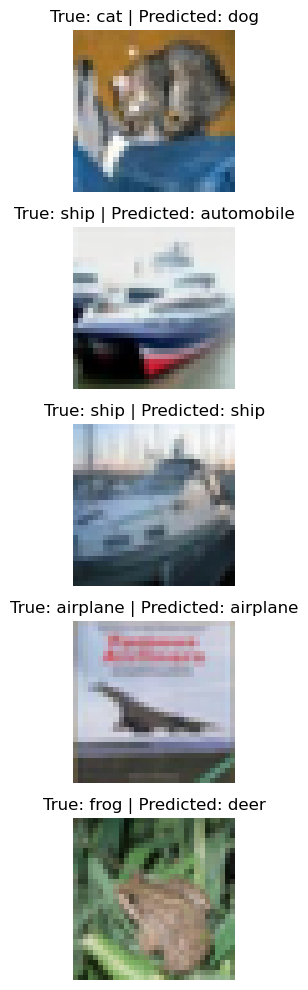

In [14]:
# Define the CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

def classify_and_display_images(model, test_loader, num_images=5):
    model.eval()  # Set the model to evaluation mode
    images, true_labels, predicted_labels = [], [], []

    with torch.no_grad():
        # Get a batch of test images
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Get model predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Store images, true labels, and predicted labels
            images.extend(inputs.cpu())
            true_labels.extend(labels.cpu())
            predicted_labels.extend(preds.cpu())

            # Stop after getting the desired number of images
            if len(images) >= num_images:
                break

    # Display each image with true and predicted labels
    plt.figure(figsize=(10, 2 * num_images))
    for i in range(num_images):
        img = images[i].numpy().transpose((1, 2, 0))  # CHW to HWC
        img = np.clip(img * np.array([0.2023, 0.1994, 0.2010]) + 
                      np.array([0.4914, 0.4822, 0.4465]), 0, 1)  # Unnormalize
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]

        # Plot each image
        ax = plt.subplot(num_images, 1, i + 1)
        ax.imshow(img)
        ax.set_title(f"True: {true_label} | Predicted: {predicted_label}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)
    
classify_and_display_images(nn, test_loader, 5)